# Analysis of predictions on yellow fever simulated reads (Sqlite)

**Plan and Actions**

Build the databases:
- Accuracy: build a database only with predictions and no probabilities, for the entire ALN dataset
    - make selection of reference sequences based on that table for probability analysis
- Expand the db with the probabilities to all selected reference sequences

Metrics:
- mean probabilities and mean probabilities per position for selected reference sequences
- consecutive predictions metrics for selected reference sequences

# 1. Imports and setup environment

In [1]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('ecutilities'):
    print('installing package: `ecutilities`')
    ! pip install -qqU ecutilities
else:
    print('`ecutilities` already installed')
if not importlib.util.find_spec('metagentools'):
    print('installing package: `metagentools')
    ! pip install -qqU metagentools
else:
    print('`metagentools` already installed')

`ecutilities` already installed
`metagentools` already installed


In [2]:
# Import all required packages
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
import sqlite3
import time

from datetime import datetime
from ecutilities.core import files_in_tree
from ecutilities.ipython import nb_setup
from functools import partial
from IPython.display import display, update_display, Markdown, HTML
from matplotlib.gridspec import GridSpec
from nbdev import show_doc
from pandas import HDFStore
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Dict, Any, Generator

# Setup the notebook for development
nb_setup()

from metagentools.cnn_virus.data import FastaFileReader, FastqFileReader, AlnFileReader, TextFileBaseReader
from metagentools.cnn_virus.data import OriginalLabels
from metagentools.core import ProjectFileSystem, SqliteDatabase

Set autoreload mode


List all computing devices available on the machine

# 2. Setup paths to files

Key folders and system information

In [3]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentools 
 - Data Dir .... /home/vtec/projects/bio/metagentools/data 
 - Notebooks ... /home/vtec/projects/bio/metagentools/nbs


- `p2model`: path to file with saved original pretrained model
- `p2virus_labels` path to file with virus names and labels mapping for original model

Path to the simulated read we want to use

In [4]:
fnames = files_in_tree(pfs.data / 'ncbi/simreads/yf', pattern='69seq')

simreads
  |--yf
  |    |--single_1seq_150bp
  |    |--single_69seq_150bp
  |    |    |--single_69seq_150bp.fq (0)
  |    |    |--single_69seq_150bp.aln (1)
  |    |--paired_1seq_150bp
  |    |--paired_69seq_150bp
  |    |    |--paired_69seq_150bp1.fq (2)
  |    |    |--paired_69seq_150bp2.fq (3)
  |    |    |--paired_69seq_150bp1.aln (4)
  |    |    |--paired_69seq_150bp2.aln (5)


In [9]:
file_stem = 'single_69seq_150bp'

p2aln = pfs.data / f"ncbi/simreads/yf/{file_stem[:-2] if file_stem[-1] in ['1', '2'] else file_stem}/{file_stem}.aln"
assert p2aln.exists()

# p2db = Path('/mnt/s/metagentools/ncbi/infer_results/yf-ncbi') / f"{file_stem}.db"
p2db = Path('/mnt/s/metagentools/ncbi/infer_results/yf-ncbi') / f"single_selected_7seq_150bp.db"
assert p2db.exists()

Select a few reference sequences to test the analysis on

In [10]:
aln = AlnFileReader(p2aln)
refseq_metadata = aln.parse_header_reference_sequences()

selected_refseqs = ['11089:ncbi:10','11089:ncbi:13', '11089:ncbi:30','11089:ncbi:37', '11089:ncbi:32', '11089:ncbi:35', '11089:ncbi:1' ]
# Originaly, 11089:ncbi:27 was also selected, but its accession (MK457701) is not in the distance matrix
print(f"      {'refseqid':^15s}  {'Accession':^13s}  {'Description':^20s}")
print(f"      {'-'*15:^15s}  {'-'*10:^13s}  {'-'*20:^20s}")
for i,rsid in enumerate(selected_refseqs):
    print(f"{i+1:2d}.   {rsid:15s}  {refseq_metadata[rsid]['refseq_accession']:^13s}  {refseq_metadata[rsid]['organism']:^20s}")

         refseqid        Accession        Description     
      ---------------   ----------    --------------------
 1.   11089:ncbi:10      GQ379163      Peru_Hsapiens_2007 
 2.   11089:ncbi:13      KU978764     Sudan_Hsapiens_1941 
 3.   11089:ncbi:30      KU978763     Nigeria_Hsapiens_1946
 4.   11089:ncbi:37      JF912190     Brazil_Hsapiens_2002
 5.   11089:ncbi:32      JF912181     Brazil_Hsapiens_1983
 6.   11089:ncbi:35      JF912182     Brazil_Hsapiens_1984
 7.   11089:ncbi:1       AY968064         Angola_1971     


# Utility Functions

# Analysis

Metrics: in effect, we have a binary classification problem here because all the simread are from yellow fever. This means prediction are either TP or FN. Consequently, accuracy = recall and we cannot evaluate precision.

## Accuracy per reference sequence

In [11]:
print('\n'.join(aln.header['reference sequences']))

@SQ	11089:ncbi:1	1	AY968064	11089	ncbi	Angola_1971	10237
@SQ	11089:ncbi:2	2	U54798	11089	ncbi	Ivory_Coast_1982	10237
@SQ	11089:ncbi:3	3	DQ235229	11089	ncbi	Ethiopia_1961	10237
@SQ	11089:ncbi:4	4	AY572535	11089	ncbi	Gambia_2001	10237
@SQ	11089:ncbi:5	5	MF405338	11089	ncbi	Ghana_Hsapiens_1927	10237
@SQ	11089:ncbi:6	6	U21056	11089	ncbi	Senegal_1927	10237
@SQ	11089:ncbi:7	7	AY968065	11089	ncbi	Uganda_1948	10237
@SQ	11089:ncbi:8	8	JX898871	11089	ncbi	ArD114896_Senegal_1995	10237
@SQ	11089:ncbi:9	9	JX898872	11089	ncbi	Senegal_Aedes-aegypti_1995	10237
@SQ	11089:ncbi:10	10	GQ379163	11089	ncbi	Peru_Hsapiens_2007	10237
@SQ	11089:ncbi:11	11	DQ118157	11089	ncbi	Spain_Vaccine_2004	10237
@SQ	11089:ncbi:12	12	MF289572	11089	ncbi	Singapore_2017	10237
@SQ	11089:ncbi:13	13	KU978764	11089	ncbi	Sudan_Hsapiens_1941	10237
@SQ	11089:ncbi:14	14	JX898878	11089	ncbi	ArD181250_Senegal_2005	10237
@SQ	11089:ncbi:15	15	JX898879	11089	ncbi	ArD181676_Senegal_2005	10237
@SQ	11089:ncbi:16	16	JX898881	11089	ncbi	Senegal

In [12]:
refseq_metadata = aln.parse_header_reference_sequences()
refseq_metadata['11089:ncbi:1']

{'organism': 'Angola_1971',
 'refseq_accession': 'AY968064',
 'refseq_length': '10237',
 'refseqid': '11089:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '11089'}

In [13]:
def refseqid2organism(refseqid:str):
    return refseq_metadata[refseqid]['organism']

refseqid2organism('11089:ncbi:1')

'Angola_1971'

### Compute accuracy stats from DB and save per refseq report on disk

In [23]:
db = SqliteDatabase(p2db)
# res = [o[0] for o in db.get_result("SELECT DISTINCT refseqid FROM predictions")]

In [42]:
BUILD_ACCURACY_DATASET = False
sequence_lenght = 10237

if BUILD_ACCURACY_DATASET:

    n_position_bins = 50
    cols = 'refseqid organism refseq_length nb_simreads mean_acc std_acc'.split(' ')
    cols_acc_per_pos = [f"acc_pos_{i:02d}" for i in range(1, n_position_bins+1)]
    cols = cols + cols_acc_per_pos

    stats_per_refseq = pd.DataFrame(columns=cols)

    for i, (refseqid, metadata) in enumerate(refseq_metadata.items()):
        # Retrieve metadata for this reference sequence
        organism = metadata['organism']
        refseq_length = metadata['refseq_length']
        print(f"{i:2d}. {organism} ({refseqid})")

        # Retrieve predictions for all simulated reads aligned to this reference sequence
        query = "SELECT readid, refseqid, lbl_true, lbl_pred, pos_true, pos_pred FROM predictions "
        query += f"WHERE refseqid = '{refseqid}'; "
        df = db.get_dataframe(query)
        if df.shape[0] > 0:
            # Compute statistics
            nb_simreads = df.shape[0]
            df['accuracy'] = df.lbl_true == df.lbl_pred
            refseq_acc_mean = df['accuracy'].mean()
            refseq_acc_std = df['accuracy'].std()

            bins = [0 + n * sequence_lenght/n_position_bins for n in range(n_position_bins+1)]
            df['pos_bin'] = pd.cut(df['pos_true'], bins, retbins=False)
            df['pos_bin'].cat.categories = range(1, n_position_bins+1) # rename categories from 1 to n_position_bins
            per_pos = df.groupby('pos_bin')
            per_pos_acc_mean = per_pos.accuracy.mean()
            
            row = pd.DataFrame(
                index=['refseqid'],
                columns=cols,
                data = [[refseqid, organism, refseq_length, nb_simreads, refseq_acc_mean, refseq_acc_std] + per_pos_acc_mean.tolist()]
            )
            # Append stats in stats_per_refseq
            stats_per_refseq = pd.concat([stats_per_refseq,row], axis=0, ignore_index=True)

        # if i > 10: break

    display(stats_per_refseq)

 0. Angola_1971 (11089:ncbi:1)
 1. Ivory_Coast_1982 (11089:ncbi:2)
 2. Ethiopia_1961 (11089:ncbi:3)
 3. Gambia_2001 (11089:ncbi:4)
 4. Ghana_Hsapiens_1927 (11089:ncbi:5)
 5. Senegal_1927 (11089:ncbi:6)
 6. Uganda_1948 (11089:ncbi:7)
 7. ArD114896_Senegal_1995 (11089:ncbi:8)
 8. Senegal_Aedes-aegypti_1995 (11089:ncbi:9)
 9. Peru_Hsapiens_2007 (11089:ncbi:10)
10. Spain_Vaccine_2004 (11089:ncbi:11)
11. Singapore_2017 (11089:ncbi:12)
12. Sudan_Hsapiens_1941 (11089:ncbi:13)
13. ArD181250_Senegal_2005 (11089:ncbi:14)
14. ArD181676_Senegal_2005 (11089:ncbi:15)
15. Senegal_Aedes_luteocephalus_2005 (11089:ncbi:16)
16. ArD181564_Senegal_2005 (11089:ncbi:17)
17. ArD181464_Senegal_2005 (11089:ncbi:18)
18. Senegal_Aedes_fucifer_2001 (11089:ncbi:19)
19. Guinea_Bissau_Hsapiens_1965 (11089:ncbi:20)
20. Senegal_Ae_fucifer_1996 (11089:ncbi:21)
21. isolate_HD117294_Senegal_1995 (11089:ncbi:22)
22. Senegal_Aedes_fucifer_2000 (11089:ncbi:23)
23. ArD149194_Senegal_2000 (11089:ncbi:24)
24. ArD149214_Senegal_

refseqid               organism refseq_length nb_simreads  mean_acc  \
0   11089:ncbi:1            Angola_1971         10237       17000  0.166765   
1  11089:ncbi:10     Peru_Hsapiens_2007         10237       17000       1.0   
2  11089:ncbi:13    Sudan_Hsapiens_1941         10237       17000       1.0   
3  11089:ncbi:30  Nigeria_Hsapiens_1946         10237       17000  0.890059   
4  11089:ncbi:32   Brazil_Hsapiens_1983         10237       17000  0.435882   
5  11089:ncbi:35   Brazil_Hsapiens_1984         10237       17000  0.400882   
6  11089:ncbi:37   Brazil_Hsapiens_2002         10237       17000  0.444118   

    std_acc acc_pos_01 acc_pos_02 acc_pos_03 acc_pos_04  ... acc_pos_41  \
0  0.372777   0.284483   0.303468   0.696721        0.0  ...        0.0   
1       0.0        1.0        1.0        1.0        1.0  ...        1.0   
2       0.0        1.0        1.0        1.0        1.0  ...        1.0   
3  0.312826   0.997015   0.990196   0.945799   0.605341  ...   0.774775   
4  0.495886   0.473239   0.764706   0.549738   0.130952  ...    0.76129   
5  0.490092   0.207977   0.242424   0.529412   0.310734  ...   0.005435   
6  0.496882   0.314024        0.5   0.615607        0.5  ...   0.377778   

  acc_pos_42 acc_pos_43 acc_pos_44 acc_pos_45 acc_pos_46 acc_pos_47  \
0   0.325153   0.217391   0.010526   0.258621    0.00295   0.151603   
1        1.0        1.0        1.0        1.0        1.0        1.0   
2        1.0        1.0        1.0        1.0        1.0        1.0   
3   0.822034   0.801075   0.978788   0.885886   0.759146   0.847645   
4   0.663717   0.339888   0.092754    0.29558   0.417445   0.601093   
5   0.334254   0.752941   0.495441   0.398281   0.156695   0.105398   
6   0.453521   0.703488   0.598784   0.545977   0.509749       0.75   

  acc_pos_48 acc_pos_49 acc_pos_50  
0   0.529412   0.322034   0.479592  
1        1.0        1.0        1.0  
2        1.0        1.0        1.0  
3    0.98615        1.0   0.972973  
4   0.225071   0.517028   0.775281  
5   0.253406   0.330383   0.510204  
6   0.714667   0.309091   0.481928  

[7 rows x 56 columns]

In [48]:
fname_seed = 'selected_7seq_'
p2stats_per_refseq = pfs.data / 'ncbi/infer_results/yf-ncbi/analysis' / f"{file_stem}/{fname_seed}{file_stem}_stats_per_refseq.csv"
print(f"Stats saved in '{p2stats_per_refseq.name}' ({p2stats_per_refseq.parent})")
# stats_per_refseq.to_csv(p2stats_per_refseq, index=False)

Stats saved in 'selected_7seq_single_69seq_150bp_stats_per_refseq.csv' (/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/analysis/single_69seq_150bp)


### Load accuracy per refseq report and plot

In [49]:
stats_per_refseq = pd.read_csv(p2stats_per_refseq, index_col='refseqid')
stats_per_refseq.shape

(7, 55)

Plot accuracy per reference sequence and per position

In [50]:
def plot_accuracy_per_refseq(df: pd.DataFrame, figsize=(15,10), ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    sorted_df = df.sort_values(by='mean_acc', ascending=True)
    sorted_df.mean_acc.plot(ax=ax, kind='barh', width=.6, title="Mean accuracy per reference sequence")
    ax.set_xlabel('Mean Accuracy')
    ax.set_yticklabels(sorted_df.organism)
    ax.set_ylabel('Reference Sequence')
    for v in [0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.vlines(x=v, ymin=-1, ymax=sorted_df.shape[0], colors='gray', linestyles='solid', alpha=0.5)
    if ax is None: plt.show()

# plot_accuracy_per_refseq(stats_per_refseq.loc[stats_per_refseq.mean_acc.notna(), :], figsize=(10,20))

In [51]:
def plot_accuracy_per_position(df: pd.DataFrame, refseqid: str, n_position_bins: int=50, figsize=(15,3), ax=None, dense=False):
    accuracy = df.loc[refseqid, 'mean_acc']
    organism = df.loc[refseqid, 'organism']
    acc_per_position = df.loc[refseqid, cols_acc_per_pos].T
    acc_per_position.index = range(1, n_position_bins+1)

    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    bar_w = 1 if dense else 0.6
    acc_per_position.plot(ax=ax, kind='bar', ylim=(0,1), width=bar_w, legend=False)
    ax.set_title(f"{organism}: accuracy per simread relative position (mean accuracy:{accuracy:.3f})")
    if dense:
        ax.hlines(y=0.5, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid', alpha=0.5)
    else:
        ax.hlines(y=0.6, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.7, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.8, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.9, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
    ax.set_xlabel('relative position in reference sequence')
    ax.set_ylabel('accuracy')
    if ax is None: plt.show()

# plot_accuracy_per_position(stats_per_refseq, '11089:ncbi:23')


In [52]:
def plot_accuracy(df: pd.DataFrame, figsize=(15,25)):
    
    # Create a figure and GridSpec object
    fig = plt.figure(figsize=(15, 25))
    fig.suptitle('Accuracy per Reference Sequence and Genome Alignment Positions', fontsize=18)
    nb_refseq = df.shape[0]
    gs = GridSpec(nb_refseq, 3, figure=fig)

    # Create left axes 
    ax_left = fig.add_subplot(gs[0:, 0])
    ax_left.set_title('Acc per refseq')
    plot_accuracy_per_refseq(df, ax=ax_left)
    ax_left.set_title(None)
    ax_left_position = ax_left.get_position()
    left_y1 = ax_left_position.y1
    left_h = ax_left_position.height
    hbar_plot_h = left_h / nb_refseq
    hbar_h = hbar_plot_h * 0.6
    hbar_padding_top = hbar_plot_h * 0.2 

    # Create other subplots
    axs = []
    for i, (refseqid, _) in enumerate(df.sort_values(by='mean_acc', ascending=False).iterrows()):
        ax = fig.add_subplot(gs[i, 1:])
        plot_accuracy_per_position(df, refseqid, ax=ax, dense=True)
        # ovwerwrite axes properties
        if i == nb_refseq-1: 
            ax.set_xlabel('alignment position of read')
        else:
            ax.set_xlabel(None)
            ax.set_xticks([])
            ax.set_xticklabels([])
        ax.set_ylabel(None)
        ax.set_yticks([0, 1])
        ax.set_yticklabels([0,1])
        ax.set_title(None)
            
        ax_pos = ax.get_position()
        ax_y0 = left_y1 - hbar_padding_top - hbar_h - i * hbar_plot_h
        ax.set_position([ax_pos.x0 , ax_y0, ax_pos.width, hbar_h])
        left_title_x = ax_left_position.x0 + ax_left_position.width/2
        right_title_x = ax_pos.x0 + ax_pos.width/2   
        title_y = ax_left_position.y1 - (1-ax_left_position.y1)*.33
        plt.annotate('Accuracy per Reference Sequence', xy=(left_title_x,title_y ), ha='center', xycoords='figure fraction', fontsize=16, color='white')
        plt.annotate('Accuracy per Position', xy=(right_title_x,title_y ), ha='left', xycoords='figure fraction', fontsize=16, color='white')
        axs.append(ax)

    plt.show()

In [54]:
# for i, _ in enumerate(aln):
#     pass
# print(f"{i:,d}")

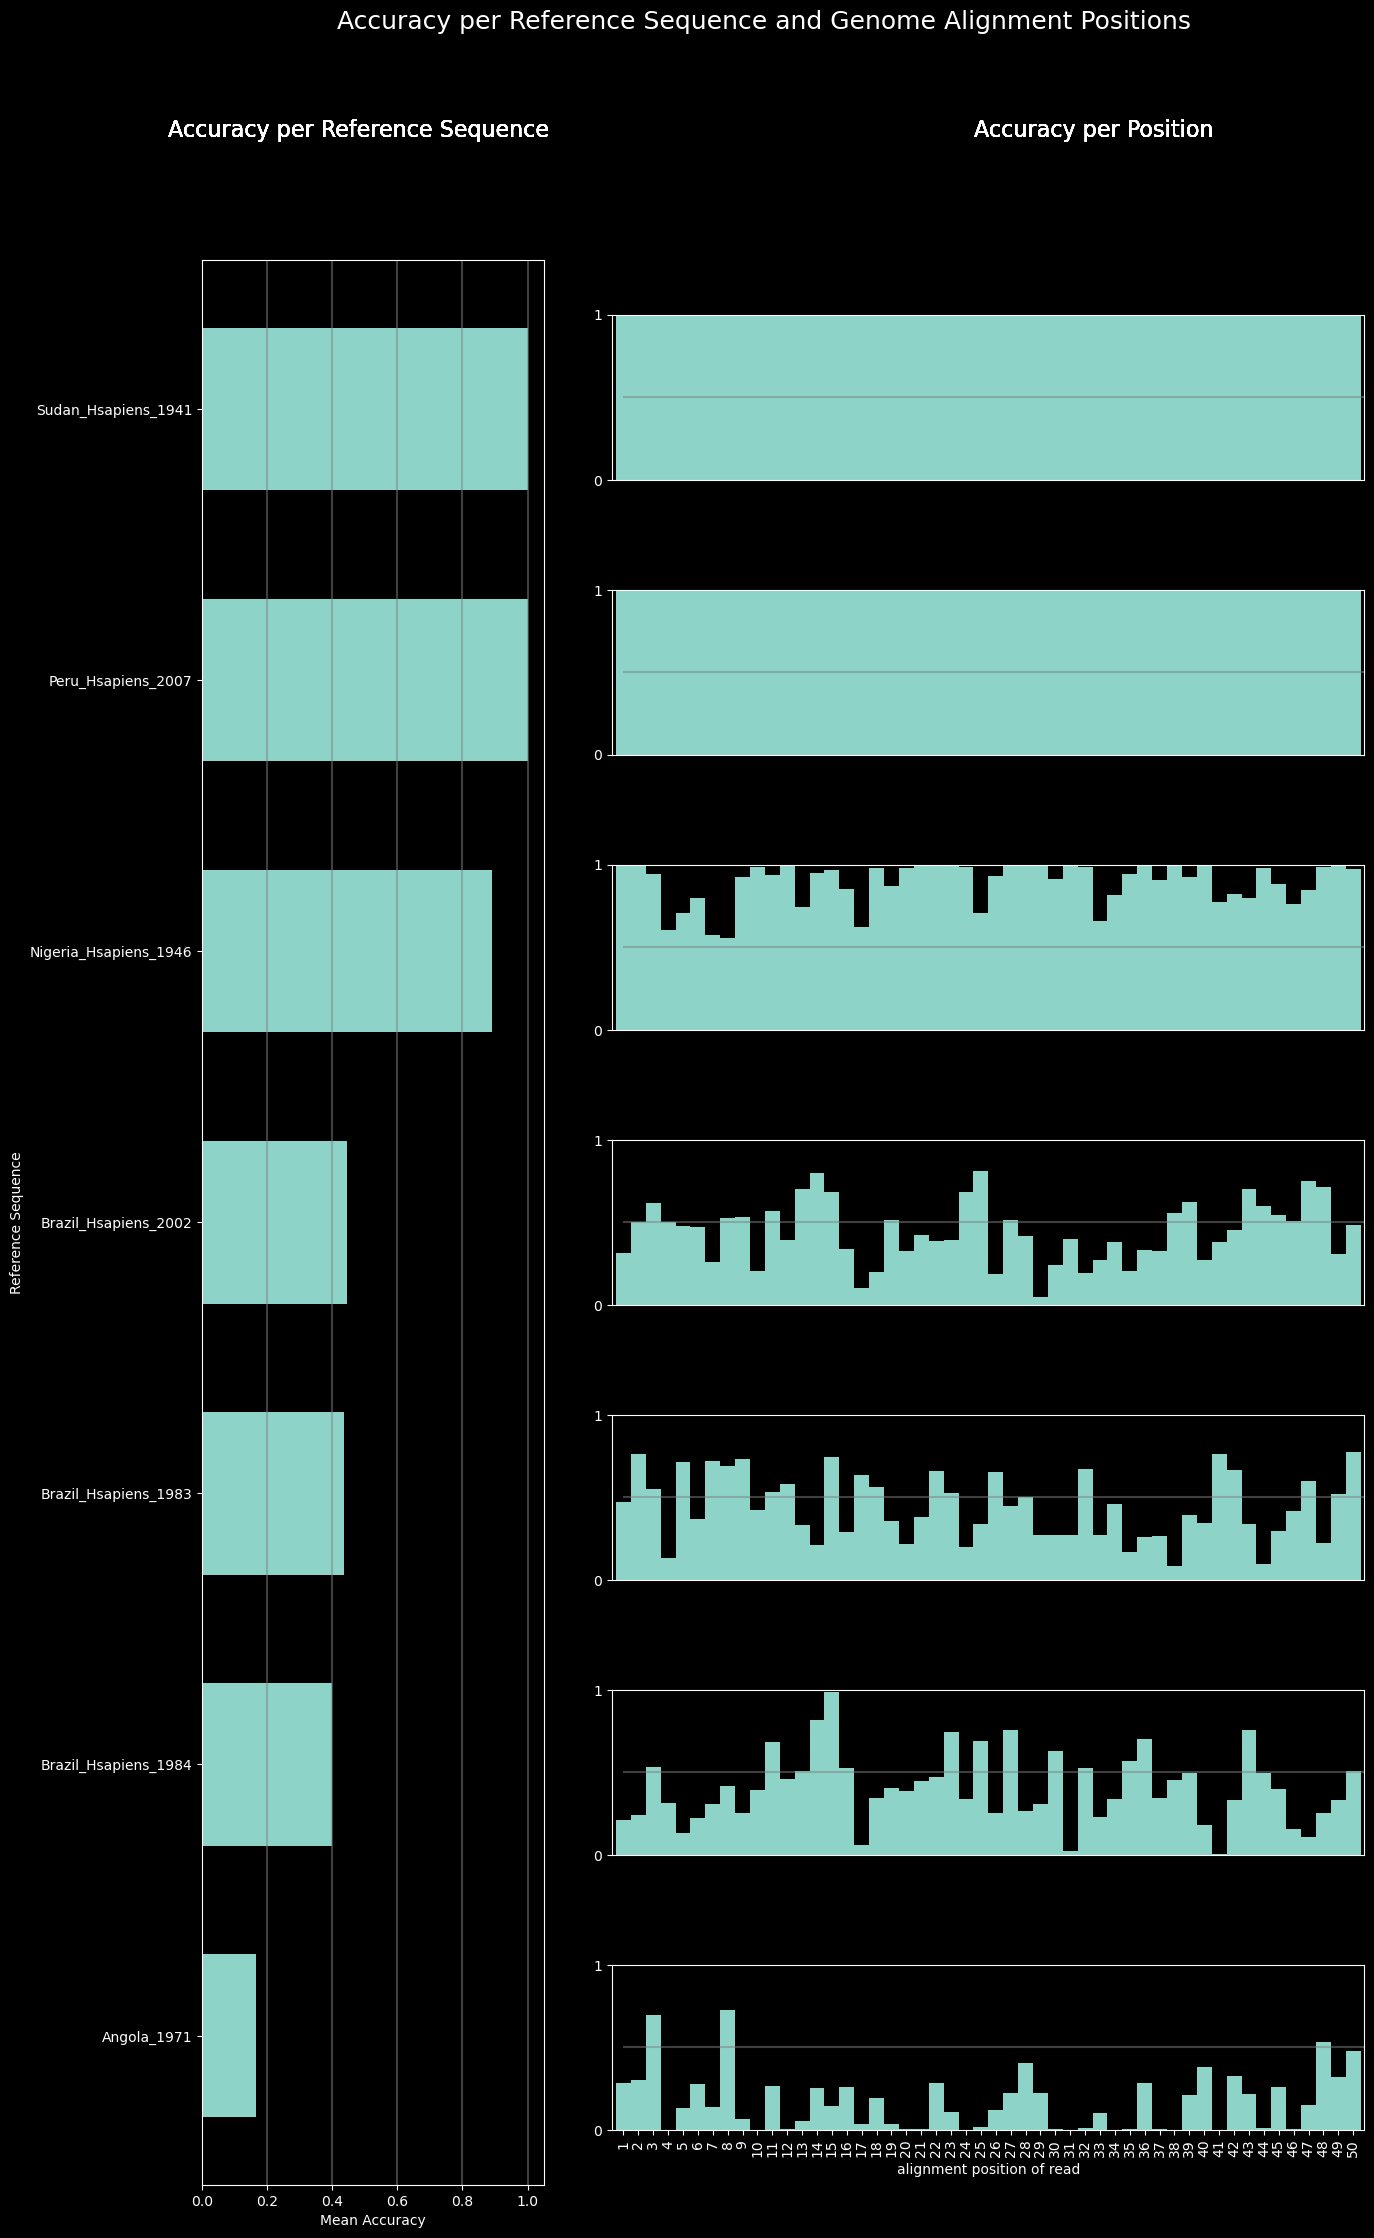

In [59]:
stats = stats_per_refseq.loc[stats_per_refseq.mean_acc.notna(), :]
plot_accuracy(stats)

## Analysis of Label Probabilities

In [60]:
aln.reset_iterator()
refseq_meta = aln.parse_header_reference_sequences()
print(refseq_meta[list(refseq_meta.keys())[0]])
print(refseq_meta['11089:ncbi:8']['organism'])
print(refseq_meta['11089:ncbi:8']['refseq_length'])

{'organism': 'Angola_1971', 'refseq_accession': 'AY968064', 'refseq_length': '10237', 'refseqid': '11089:ncbi:1', 'refseqnb': '1', 'refsource': 'ncbi', 'reftaxonomyid': '11089'}
ArD114896_Senegal_1995
10237


In [61]:
p2db = Path('/mnt/s/metagentools/ncbi/infer_results/yf-ncbi/single_selected_7seq_150bp.db')
assert p2db.exists()
db = SqliteDatabase(p2db)

In [62]:
db.print_schema()

predictions (table)
 columns: id, readid, refseqid, refsource, refseq_strand, taxonomyid, lbl_true, lbl_pred, pos_true, pos_pred, top_5_lbl_pred_0, top_5_lbl_pred_1, top_5_lbl_pred_2, top_5_lbl_pred_3, top_5_lbl_pred_4
 index: idx_preds_3
   indexed columns: readid, refseqid, pos_true
 index: idx_preds_refseqid
   indexed columns: refseqid

label_probabilities (table)
 columns: id, read_kmer_id, read_50mer_nb, refseqid, prob_000, prob_001, prob_002, prob_003, prob_004, prob_005, prob_006, prob_007, prob_008, prob_009, prob_010, prob_011, prob_012, prob_013, prob_014, prob_015, prob_016, prob_017, prob_018, prob_019, prob_020, prob_021, prob_022, prob_023, prob_024, prob_025, prob_026, prob_027, prob_028, prob_029, prob_030, prob_031, prob_032, prob_033, prob_034, prob_035, prob_036, prob_037, prob_038, prob_039, prob_040, prob_041, prob_042, prob_043, prob_044, prob_045, prob_046, prob_047, prob_048, prob_049, prob_050, prob_051, prob_052, prob_053, prob_054, prob_055, prob_056, prob_0

### Test the code with one "page" of data

Load a set of rows from `preds_probs` view for a specific reference sequence, and evaluate the metrics.

In [63]:
selected_refseqs[-1]

'11089:ncbi:1'

In [64]:
%%time
# Retrieve all columns and filtering on refseqid
# CPU times: user 973 ms, sys: 251 ms, total: 1.22 s
# Wall time: 2min 47s for 10,100 rows
# CPU times: user 954 ms, sys: 136 ms, total: 1.09 s
# Wall time: 17.5 s for 10100 with proper indexes
query = f"""
SELECT *
FROM preds_probs 
WHERE refseqid = '{selected_refseqs[-1]}'  
LIMIT 10100
"""
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail())

(10100, 200)


id      refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
10095  10096  11089:ncbi:1       118         2      4547         7   
10096  10097  11089:ncbi:1       118       130       973         6   
10097  10098  11089:ncbi:1       118       137      1225         8   
10098  10099  11089:ncbi:1       118       102      8757         6   
10099  10100  11089:ncbi:1       118        62      1183         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
10095                 2                67               118                20   
10096                62               130               137               146   
10097               143                46                67               160   
10098                67               103                20                33   
10099                93                62               104                16   

       ...      prob_177      prob_178      prob_179      prob_180  \
10095  ...  8.620532e-13  1.005013e-19  8.174250e-13  1.359655e-04   
10096  ...  4.253266e-17  4.194007e-17  2.314456e-12  2.159869e-14   
10097  ...  6.268810e-12  2.985322e-20  3.350551e-21  4.574961e-22   
10098  ...  2.444246e-15  3.396491e-15  2.003567e-09  2.412583e-15   
10099  ...  1.350260e-05  6.829806e-09  2.644628e-11  9.000741e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
10095  1.490946e-09  8.211846e-10  1.798794e-14  7.022321e-01  5.058082e-04   
10096  2.680717e-20  1.070130e-13  5.075820e-22  2.323057e-21  2.020265e-19   
10097  1.049179e-19  1.894057e-28  9.187954e-24  7.252743e-21  1.306245e-08   
10098  6.832757e-09  4.510508e-05  1.014253e-06  8.834100e-13  1.003908e-16   
10099  3.008412e-14  4.175712e-15  1.764230e-04  1.418006e-17  1.011920e-17   

           prob_186  
10095  7.322818e-22  
10096  7.973730e-29  
10097  5.765941e-27  
10098  3.001064e-16  
10099  9.009939e-22  

[5 rows x 200 columns]

CPU times: user 954 ms, sys: 136 ms, total: 1.09 s
Wall time: 17.5 s


Define lists of columns for different purposes:
- columns of interest
- columns for probabilities

Note: for some reason, pandas is not able to read some of the columns prob_i as float, so we force that

In [65]:
view_cols = 'id,read_kmer_id,read_50mer_nb,refseqid,lbl_true,lbl_pred,pos_true,pos_pred,top_5_lbl_pred_0,top_5_lbl_pred_1,top_5_lbl_pred_2,top_5_lbl_pred_3,top_5_lbl_pred_4,prob_000,prob_001,prob_002,prob_003,prob_004,prob_005,prob_006,prob_007,prob_008,prob_009,prob_010,prob_011,prob_012,prob_013,prob_014,prob_015,prob_016,prob_017,prob_018,prob_019,prob_020,prob_021,prob_022,prob_023,prob_024,prob_025,prob_026,prob_027,prob_028,prob_029,prob_030,prob_031,prob_032,prob_033,prob_034,prob_035,prob_036,prob_037,prob_038,prob_039,prob_040,prob_041,prob_042,prob_043,prob_044,prob_045,prob_046,prob_047,prob_048,prob_049,prob_050,prob_051,prob_052,prob_053,prob_054,prob_055,prob_056,prob_057,prob_058,prob_059,prob_060,prob_061,prob_062,prob_063,prob_064,prob_065,prob_066,prob_067,prob_068,prob_069,prob_070,prob_071,prob_072,prob_073,prob_074,prob_075,prob_076,prob_077,prob_078,prob_079,prob_080,prob_081,prob_082,prob_083,prob_084,prob_085,prob_086,prob_087,prob_088,prob_089,prob_090,prob_091,prob_092,prob_093,prob_094,prob_095,prob_096,prob_097,prob_098,prob_099,prob_100,prob_101,prob_102,prob_103,prob_104,prob_105,prob_106,prob_107,prob_108,prob_109,prob_110,prob_111,prob_112,prob_113,prob_114,prob_115,prob_116,prob_117,prob_118,prob_119,prob_120,prob_121,prob_122,prob_123,prob_124,prob_125,prob_126,prob_127,prob_128,prob_129,prob_130,prob_131,prob_132,prob_133,prob_134,prob_135,prob_136,prob_137,prob_138,prob_139,prob_140,prob_141,prob_142,prob_143,prob_144,prob_145,prob_146,prob_147,prob_148,prob_149,prob_150,prob_151,prob_152,prob_153,prob_154,prob_155,prob_156,prob_157,prob_158,prob_159,prob_160,prob_161,prob_162,prob_163,prob_164,prob_165,prob_166,prob_167,prob_168,prob_169,prob_170,prob_171,prob_172,prob_173,prob_174,prob_175,prob_176,prob_177,prob_178,prob_179,prob_180,prob_181,prob_182,prob_183,prob_184,prob_185,prob_186'.split(',')
assert len(view_cols) == df_probs.shape[1]

In [66]:
display(df_probs[view_cols].head())

id        read_kmer_id  read_50mer_nb      refseqid  lbl_true  lbl_pred  \
0   1  11089:ncbi:1-17000              0  11089:ncbi:1       118        10   
1   2  11089:ncbi:1-16999              0  11089:ncbi:1       118         2   
2   3  11089:ncbi:1-16998              0  11089:ncbi:1       118       144   
3   4  11089:ncbi:1-16997              0  11089:ncbi:1       118        32   
4   5  11089:ncbi:1-16996              0  11089:ncbi:1       118       118   

   pos_true  pos_pred  top_5_lbl_pred_0  top_5_lbl_pred_1  ...      prob_177  \
0      7804         0               118                32  ...  4.620669e-10   
1      6069         4                62                 2  ...  9.303694e-15   
2      5317         4               144               146  ...  2.070324e-07   
3      1717         0                32                62  ...  2.841831e-17   
4      9658         0               118                16  ...  2.384261e-05   

       prob_178      prob_179      prob_180      prob_181      prob_182  \
0  2.195646e-23  4.973716e-17  1.287073e-19  6.685301e-13  2.796299e-13   
1  5.522096e-11  9.077740e-16  5.685052e-12  9.021820e-15  4.313646e-09   
2  2.066216e-10  8.602851e-09  2.749270e-16  3.818876e-09  8.827278e-09   
3  1.257724e-20  3.984798e-20  8.843543e-24  2.310843e-16  1.785395e-16   
4  7.231542e-10  1.272906e-07  2.878808e-14  1.620230e-10  3.461863e-02   

       prob_183      prob_184      prob_185      prob_186  
0  5.020673e-22  2.393255e-15  1.298766e-21  3.557021e-18  
1  2.335988e-06  8.922423e-16  2.676930e-11  8.044394e-09  
2  2.178763e-12  1.517998e-10  6.869064e-14  9.024393e-14  
3  2.284211e-22  1.367643e-22  2.185023e-27  2.357869e-23  
4  9.617226e-12  2.706786e-13  1.076152e-12  1.402150e-17  

[5 rows x 200 columns]

In [67]:
coi = ['refseqid', 'read_kmer_id', 'read_50mer_nb', 'lbl_pred', 'pos_true']
prob_cols = [c for c in df_probs.columns if c.startswith('prob_')]

Add `accuracy` and `pos_bin`

In [68]:
df_probs['accuracy'] = df_probs.lbl_true == df_probs.lbl_pred
coi.append('accuracy')

n_position_bins = 50
bins = [0 + n * 10237/n_position_bins for n in range(n_position_bins+1)]

df_probs['pos_bin'] = pd.cut(df_probs['pos_true'], bins, retbins=False)
df_probs.pos_bin.cat.categories = range(1, n_position_bins+1) # rename categories from 1 to n_position_bins
coi.append('pos_bin')
df_probs.loc[:,coi].head()

refseqid        read_kmer_id  read_50mer_nb  lbl_pred  pos_true  \
0  11089:ncbi:1  11089:ncbi:1-17000              0        10      7804   
1  11089:ncbi:1  11089:ncbi:1-16999              0         2      6069   
2  11089:ncbi:1  11089:ncbi:1-16998              0       144      5317   
3  11089:ncbi:1  11089:ncbi:1-16997              0        32      1717   
4  11089:ncbi:1  11089:ncbi:1-16996              0       118      9658   

   accuracy pos_bin  
0     False      39  
1     False      30  
2     False      26  
3     False       9  
4      True      48

Create a DataFrame to keep the statistics for each "page":
- reads' count and sum of label probabilities for the whole "page"
- reads' count and sum of label probabilities for for each of the position bins

Once we have all the pages, we will be able to aggregate the statistics for the whole set of page together.
- total number of reads = $\sum_{pages}$ page read's counts
- mean label probability = $\sum_{pages}$ page read's sum of label probabilities / total number of reads
- same for each bin

In [69]:
page_reads_stats_cols = 'reads_count reads_acc_sum'.split(' ')
page_reads_probs_cols = [f'reads_{p}_sum' for p in df_probs.columns if p.startswith('prob_')]  
page_bins_stats_cols = []
for b in range(1, n_position_bins+1):
    page_bins_stats_cols.append(f"bin{b:02d}_count")
    page_bins_stats_cols.extend([f'bin{b:02d}_{p}_sum' for p in df_probs.columns if p.startswith('prob_')])

page_stats_cols = page_reads_stats_cols + page_reads_probs_cols + page_bins_stats_cols

print(page_reads_stats_cols)
print(page_reads_probs_cols)
print(page_bins_stats_cols)
print(page_stats_cols[:10])
print(page_stats_cols[-10:])

df_page_stats = pd.DataFrame(columns=page_stats_cols)
display(df_page_stats.head())
print(df_page_stats.shape)

['reads_count', 'reads_acc_sum']
['reads_prob_000_sum', 'reads_prob_001_sum', 'reads_prob_002_sum', 'reads_prob_003_sum', 'reads_prob_004_sum', 'reads_prob_005_sum', 'reads_prob_006_sum', 'reads_prob_007_sum', 'reads_prob_008_sum', 'reads_prob_009_sum', 'reads_prob_010_sum', 'reads_prob_011_sum', 'reads_prob_012_sum', 'reads_prob_013_sum', 'reads_prob_014_sum', 'reads_prob_015_sum', 'reads_prob_016_sum', 'reads_prob_017_sum', 'reads_prob_018_sum', 'reads_prob_019_sum', 'reads_prob_020_sum', 'reads_prob_021_sum', 'reads_prob_022_sum', 'reads_prob_023_sum', 'reads_prob_024_sum', 'reads_prob_025_sum', 'reads_prob_026_sum', 'reads_prob_027_sum', 'reads_prob_028_sum', 'reads_prob_029_sum', 'reads_prob_030_sum', 'reads_prob_031_sum', 'reads_prob_032_sum', 'reads_prob_033_sum', 'reads_prob_034_sum', 'reads_prob_035_sum', 'reads_prob_036_sum', 'reads_prob_037_sum', 'reads_prob_038_sum', 'reads_prob_039_sum', 'reads_prob_040_sum', 'reads_prob_041_sum', 'reads_prob_042_sum', 'reads_prob_043_sum'

Empty DataFrame
Columns: [reads_count, reads_acc_sum, reads_prob_000_sum, reads_prob_001_sum, reads_prob_002_sum, reads_prob_003_sum, reads_prob_004_sum, reads_prob_005_sum, reads_prob_006_sum, reads_prob_007_sum, reads_prob_008_sum, reads_prob_009_sum, reads_prob_010_sum, reads_prob_011_sum, reads_prob_012_sum, reads_prob_013_sum, reads_prob_014_sum, reads_prob_015_sum, reads_prob_016_sum, reads_prob_017_sum, reads_prob_018_sum, reads_prob_019_sum, reads_prob_020_sum, reads_prob_021_sum, reads_prob_022_sum, reads_prob_023_sum, reads_prob_024_sum, reads_prob_025_sum, reads_prob_026_sum, reads_prob_027_sum, reads_prob_028_sum, reads_prob_029_sum, reads_prob_030_sum, reads_prob_031_sum, reads_prob_032_sum, reads_prob_033_sum, reads_prob_034_sum, reads_prob_035_sum, reads_prob_036_sum, reads_prob_037_sum, reads_prob_038_sum, reads_prob_039_sum, reads_prob_040_sum, reads_prob_041_sum, reads_prob_042_sum, reads_prob_043_sum, reads_prob_044_sum, reads_prob_045_sum, reads_prob_046_sum, reads_prob_047_sum, reads_prob_048_sum, reads_prob_049_sum, reads_prob_050_sum, reads_prob_051_sum, reads_prob_052_sum, reads_prob_053_sum, reads_prob_054_sum, reads_prob_055_sum, reads_prob_056_sum, reads_prob_057_sum, reads_prob_058_sum, reads_prob_059_sum, reads_prob_060_sum, reads_prob_061_sum, reads_prob_062_sum, reads_prob_063_sum, reads_prob_064_sum, reads_prob_065_sum, reads_prob_066_sum, reads_prob_067_sum, reads_prob_068_sum, reads_prob_069_sum, reads_prob_070_sum, reads_prob_071_sum, reads_prob_072_sum, reads_prob_073_sum, reads_prob_074_sum, reads_prob_075_sum, reads_prob_076_sum, reads_prob_077_sum, reads_prob_078_sum, reads_prob_079_sum, reads_prob_080_sum, reads_prob_081_sum, reads_prob_082_sum, reads_prob_083_sum, reads_prob_084_sum, reads_prob_085_sum, reads_prob_086_sum, reads_prob_087_sum, reads_prob_088_sum, reads_prob_089_sum, reads_prob_090_sum, reads_prob_091_sum, reads_prob_092_sum, reads_prob_093_sum, reads_prob_094_sum, reads_prob_095_sum, reads_prob_096_sum, reads_prob_097_sum, ...]
Index: []

[0 rows x 9589 columns]

(0, 9589)


Evaluate the page stats:
- full page stats
- bins stats on page

In [70]:
# Full page stats
reads_count = df_probs['accuracy'].count()
reads_acc_sum = df_probs['accuracy'].sum()
reads_probs_sum = df_probs[prob_cols].sum(axis=0)
reads_probs_mean = reads_probs_sum / reads_count
print(f"{reads_count:,d} reads in this page with {reads_acc_sum:,d} read correctly predicted")
print(f"{reads_probs_sum.shape[0]} sum of label probabilities: {reads_probs_sum[115:120].values.tolist()}")
print(f"{reads_probs_mean.shape[0]} mean of label probabilities: {reads_probs_mean[116:121].values.tolist()}")

10,100 reads in this page with 1,749 read correctly predicted
187 sum of label probabilities: [7.699206538653257, 1.1111885032842446, 68.64555169647161, 792.4048255017151, 16.151510502688314]
187 mean of label probabilities: [0.00011001866369150936, 0.0067965892768783774, 0.07845592331700149, 0.0015991594557117142, 0.003212844237354981]


In [71]:
# Bins stats on this page
group =df_probs.groupby('pos_bin')
bins_count = group['refseqid'].count()
print(f"Bins count:{bins_count.values.tolist()}")
print(f"Bins count total: {bins_count.sum():,d}")

bins_probs_sum = group[prob_cols].sum()
bins_probs_sum.index = [f"bin{b:02d}" for b in range(1, n_position_bins+1)]
print(bins_count.shape, bins_probs_sum.shape)
assert bins_count.shape[0] == bins_probs_sum.shape[0]
bins_count = bins_count.replace(0,1) # avoid division by zero
bins_probs_mean = bins_probs_sum.div(bins_count.values, axis=0)

display(bins_probs_mean.iloc[-10:, 25:35])

Bins count:[143, 204, 228, 178, 249, 224, 261, 180, 222, 215, 237, 201, 260, 129, 227, 191, 178, 276, 154, 167, 262, 274, 179, 178, 247, 226, 191, 155, 180, 202, 177, 227, 263, 142, 130, 238, 202, 321, 201, 204, 201, 191, 226, 251, 200, 119, 200, 178, 165, 46]
Bins count total: 10,100
(50,) (50, 187)


prob_025      prob_026      prob_027      prob_028      prob_029  \
bin41  0.033860  4.292160e-05  1.081754e-04  3.014234e-04  1.923684e-05   
bin42  0.000251  2.884665e-09  1.349935e-02  1.619128e-07  6.341153e-09   
bin43  0.000727  5.981819e-08  2.858063e-04  6.348454e-07  1.765665e-06   
bin44  0.002033  4.399186e-08  4.012524e-02  9.016969e-08  2.055729e-11   
bin45  0.000004  5.682799e-05  3.992345e-05  4.427748e-08  2.935962e-03   
bin46  0.000457  8.876163e-07  1.225059e-03  1.411203e-05  8.051469e-05   
bin47  0.000008  2.935413e-06  1.268106e-02  3.573139e-05  6.598457e-04   
bin48  0.000001  9.665832e-05  1.380042e-06  2.797769e-05  2.512720e-08   
bin49  0.005062  3.608192e-04  8.046562e-03  5.286867e-03  2.100409e-05   
bin50  0.000002  2.247467e-09  4.195001e-12  5.662693e-08  1.156842e-11   

           prob_030      prob_031  prob_032      prob_033      prob_034  
bin41  1.094278e-04  9.025497e-07  0.102705  2.322505e-02  3.880153e-07  
bin42  2.219937e-02  7.961802e-08  0.065824  2.738930e-05  5.488382e-09  
bin43  1.801872e-03  5.045747e-06  0.019567  2.543927e-02  2.858710e-05  
bin44  1.012344e-03  3.564649e-04  0.013228  6.437331e-06  1.235529e-08  
bin45  9.177757e-04  5.034762e-08  0.007261  7.501688e-05  5.319368e-03  
bin46  3.239863e-05  6.842344e-10  0.019705  4.613760e-05  3.374885e-04  
bin47  3.791944e-06  3.083463e-06  0.025407  2.226580e-07  2.353620e-08  
bin48  1.207554e-02  7.058454e-05  0.002360  9.211209e-05  8.439196e-06  
bin49  1.614819e-03  2.100263e-04  0.035602  3.778573e-05  3.652586e-05  
bin50  7.199091e-12  1.404310e-14  0.606148  1.625515e-05  1.925436e-09

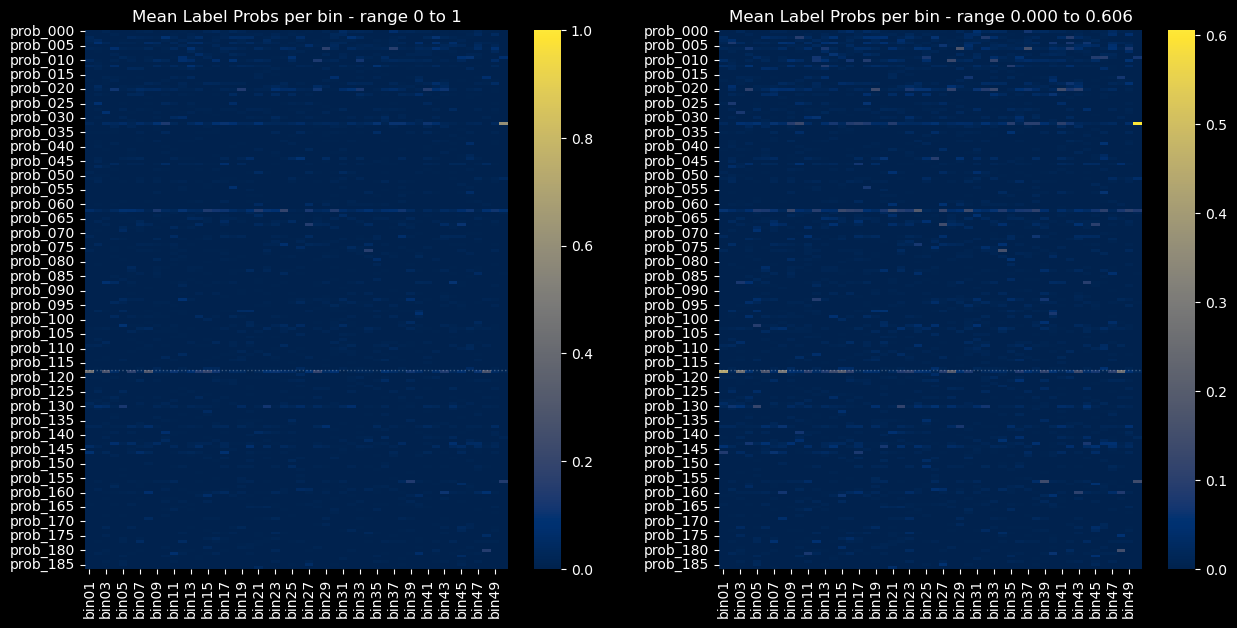

In [72]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
bin_min = bins_probs_mean.min().min()
bin_max = bins_probs_mean.max().max()
ax1.set_title(f"Mean Label Probs per bin - range 0 to 1")
ax2.set_title(f"Mean Label Probs per bin - range {bin_min:.3f} to {bin_max:.3f}")
ax1.hlines(y=118, xmin=0, xmax=50, color='white', linewidth=1, linestyles='dotted', alpha=0.25)
ax2.hlines(y=118, xmin=0, xmax=50, color='white', linewidth=1, linestyles='dotted', alpha=0.25)
sns.heatmap(bins_probs_mean.T, ax=ax1, cmap='cividis', cbar=True, vmax=1., vmin=0.);
sns.heatmap(bins_probs_mean.T, ax=ax2, cmap='cividis', cbar=True);

We need to reshape `bins_probs_sum` to fit the `reads_prob_00i_sum` columns in `df_page_stats`:

In [73]:
def flatten_probs(df):
    flattened_data = df.values.flatten()
    new_column_names = [f"{idx}_{col}" for idx in df.index for col in df.columns]
    return pd.DataFrame([flattened_data], columns=new_column_names)

cols = 'prob_000 prob_001 prob_002 prob_003 prob_004'.split(' ')
idx = 'bin01 bin02 bin03'.split(' ')
x = pd.DataFrame(np.arange(len(cols) * len(idx)).reshape(len(idx),len(cols)), columns=cols, index=idx)
display(x)
display(flatten_probs(x))
display(df_page_stats.iloc[0:1, 3 + 187:])

prob_000  prob_001  prob_002  prob_003  prob_004
bin01         0         1         2         3         4
bin02         5         6         7         8         9
bin03        10        11        12        13        14

bin01_prob_000  bin01_prob_001  bin01_prob_002  bin01_prob_003  \
0               0               1               2               3   

   bin01_prob_004  bin02_prob_000  bin02_prob_001  bin02_prob_002  \
0               4               5               6               7   

   bin02_prob_003  bin02_prob_004  bin03_prob_000  bin03_prob_001  \
0               8               9              10              11   

   bin03_prob_002  bin03_prob_003  bin03_prob_004  
0              12              13              14

Empty DataFrame
Columns: [bin01_prob_000_sum, bin01_prob_001_sum, bin01_prob_002_sum, bin01_prob_003_sum, bin01_prob_004_sum, bin01_prob_005_sum, bin01_prob_006_sum, bin01_prob_007_sum, bin01_prob_008_sum, bin01_prob_009_sum, bin01_prob_010_sum, bin01_prob_011_sum, bin01_prob_012_sum, bin01_prob_013_sum, bin01_prob_014_sum, bin01_prob_015_sum, bin01_prob_016_sum, bin01_prob_017_sum, bin01_prob_018_sum, bin01_prob_019_sum, bin01_prob_020_sum, bin01_prob_021_sum, bin01_prob_022_sum, bin01_prob_023_sum, bin01_prob_024_sum, bin01_prob_025_sum, bin01_prob_026_sum, bin01_prob_027_sum, bin01_prob_028_sum, bin01_prob_029_sum, bin01_prob_030_sum, bin01_prob_031_sum, bin01_prob_032_sum, bin01_prob_033_sum, bin01_prob_034_sum, bin01_prob_035_sum, bin01_prob_036_sum, bin01_prob_037_sum, bin01_prob_038_sum, bin01_prob_039_sum, bin01_prob_040_sum, bin01_prob_041_sum, bin01_prob_042_sum, bin01_prob_043_sum, bin01_prob_044_sum, bin01_prob_045_sum, bin01_prob_046_sum, bin01_prob_047_sum, bin01_prob_048_sum, bin01_prob_049_sum, bin01_prob_050_sum, bin01_prob_051_sum, bin01_prob_052_sum, bin01_prob_053_sum, bin01_prob_054_sum, bin01_prob_055_sum, bin01_prob_056_sum, bin01_prob_057_sum, bin01_prob_058_sum, bin01_prob_059_sum, bin01_prob_060_sum, bin01_prob_061_sum, bin01_prob_062_sum, bin01_prob_063_sum, bin01_prob_064_sum, bin01_prob_065_sum, bin01_prob_066_sum, bin01_prob_067_sum, bin01_prob_068_sum, bin01_prob_069_sum, bin01_prob_070_sum, bin01_prob_071_sum, bin01_prob_072_sum, bin01_prob_073_sum, bin01_prob_074_sum, bin01_prob_075_sum, bin01_prob_076_sum, bin01_prob_077_sum, bin01_prob_078_sum, bin01_prob_079_sum, bin01_prob_080_sum, bin01_prob_081_sum, bin01_prob_082_sum, bin01_prob_083_sum, bin01_prob_084_sum, bin01_prob_085_sum, bin01_prob_086_sum, bin01_prob_087_sum, bin01_prob_088_sum, bin01_prob_089_sum, bin01_prob_090_sum, bin01_prob_091_sum, bin01_prob_092_sum, bin01_prob_093_sum, bin01_prob_094_sum, bin01_prob_095_sum, bin01_prob_096_sum, bin01_prob_097_sum, bin01_prob_098_sum, bin01_prob_099_sum, ...]
Index: []

[0 rows x 9399 columns]

In [74]:
flatten_probs(bins_probs_sum)

bin01_prob_000  bin01_prob_001  bin01_prob_002  bin01_prob_003  \
0        0.018625        0.000792        3.582388        2.893361   

   bin01_prob_004  bin01_prob_005  bin01_prob_006  bin01_prob_007  \
0        1.514707        0.000156        2.250576        0.049481   

   bin01_prob_008  bin01_prob_009  ...  bin50_prob_177  bin50_prob_178  \
0        0.004053        0.009723  ...        0.000002    9.049625e-11   

   bin50_prob_179  bin50_prob_180  bin50_prob_181  bin50_prob_182  \
0    1.938021e-08        0.000781    6.169648e-09    3.467380e-08   

   bin50_prob_183  bin50_prob_184  bin50_prob_185  bin50_prob_186  
0    1.503264e-11    5.230736e-07    5.760928e-08    7.316577e-11  

[1 rows x 9350 columns]

In [75]:
print(page_reads_stats_cols)
print(page_reads_probs_cols[:5])
print(page_bins_stats_cols[:5])

['reads_count', 'reads_acc_sum']
['reads_prob_000_sum', 'reads_prob_001_sum', 'reads_prob_002_sum', 'reads_prob_003_sum', 'reads_prob_004_sum']
['bin01_count', 'bin01_prob_000_sum', 'bin01_prob_001_sum', 'bin01_prob_002_sum', 'bin01_prob_003_sum']


Now we can update the stats in df_page_stats with the new values:
- build one row_page_stats for each page
- append the row_page_stats to df_page_stats for each page

In [76]:
row_page_stats = pd.DataFrame(data=0, index=[0], columns=page_stats_cols)
row_page_stats.loc[0, page_reads_stats_cols] = [reads_count, reads_acc_sum]
assert len(page_reads_probs_cols) == len(reads_probs_sum)
row_page_stats.loc[0, page_reads_probs_cols] = reads_probs_sum.values
for b in range(n_position_bins):
    row_page_stats.loc[0, f"bin{b+1:02d}_count"] = bins_count.iloc[b]
    bin_probs_cols = [c for c in row_page_stats.columns if f"bin{b+1:02d}_prob_" in c]
    assert len(bin_probs_cols) == len(bins_probs_sum.iloc[b])
    row_page_stats.loc[0, bin_probs_cols] = bins_probs_sum.iloc[b].values


display(row_page_stats.loc[:, [c for c in row_page_stats.columns if 'count' in c]])
display(row_page_stats.loc[:, [c for c in row_page_stats.columns if '_prob_005' in c]])

reads_count  bin01_count  bin02_count  bin03_count  bin04_count  \
0        10100          143          204          228          178   

   bin05_count  bin06_count  bin07_count  bin08_count  bin09_count  ...  \
0          249          224          261          180          222  ...   

   bin41_count  bin42_count  bin43_count  bin44_count  bin45_count  \
0          201          191          226          251          200   

   bin46_count  bin47_count  bin48_count  bin49_count  bin50_count  
0          119          200          178          165           46  

[1 rows x 51 columns]

reads_prob_005_sum  bin01_prob_005_sum  bin02_prob_005_sum  \
0           93.746996            0.000156            0.097369   

   bin03_prob_005_sum  bin04_prob_005_sum  bin05_prob_005_sum  \
0            0.000033            0.000295            0.022392   

   bin06_prob_005_sum  bin07_prob_005_sum  bin08_prob_005_sum  \
0            0.783679            0.062676            0.193361   

   bin09_prob_005_sum  ...  bin41_prob_005_sum  bin42_prob_005_sum  \
0            1.783825  ...            1.029517            1.368584   

   bin43_prob_005_sum  bin44_prob_005_sum  bin45_prob_005_sum  \
0            5.425226            9.498016            5.379764   

   bin46_prob_005_sum  bin47_prob_005_sum  bin48_prob_005_sum  \
0             0.02839            8.552927            0.000042   

   bin49_prob_005_sum  bin50_prob_005_sum  
0            3.824379            0.000006  

[1 rows x 51 columns]

## Handle probabilities with Pages

In [77]:
p2aln = pfs.data / 'ncbi/simreads/yf/single_69seq_150bp/single_69seq_150bp.aln'
assert p2aln.exists()
aln = AlnFileReader(p2aln)
refseq_metadata = aln.parse_header_reference_sequences()

In [78]:
# selected_refseqs = ['11089:ncbi:10','11089:ncbi:13', '11089:ncbi:27' ,'11089:ncbi:30','11089:ncbi:37', '11089:ncbi:32', '11089:ncbi:35', '11089:ncbi:1' ]
print("Selected reference sequences:")
for rsid in selected_refseqs:
    print(f"    - {rsid:14s}:    {refseq_metadata[rsid]['organism']}")

Selected reference sequences:
    - 11089:ncbi:10 :    Peru_Hsapiens_2007
    - 11089:ncbi:13 :    Sudan_Hsapiens_1941
    - 11089:ncbi:30 :    Nigeria_Hsapiens_1946
    - 11089:ncbi:37 :    Brazil_Hsapiens_2002
    - 11089:ncbi:32 :    Brazil_Hsapiens_1983
    - 11089:ncbi:35 :    Brazil_Hsapiens_1984
    - 11089:ncbi:1  :    Angola_1971


In [79]:
def fetch_df_page(db, refseqid, last_seen_id=None, limit=10):
    if last_seen_id:
        sql = f"""
        SELECT * FROM preds_probs
        WHERE refseqid = '{refseqid}' AND id > {last_seen_id}
        ORDER BY id ASC
        LIMIT {limit}
        """
    else:
        sql = f"""
        SELECT * FROM preds_probs
        WHERE refseqid = '{refseqid}'
        ORDER BY id ASC
        LIMIT {limit}
        """
    return db.get_dataframe(sql)

In [81]:
p2db = Path('/mnt/s/metagentools/ncbi/infer_results/yf-ncbi/single_selected_7seq_150bp.db')
assert p2db.exists()
db = SqliteDatabase(p2db=p2db)
db.print_schema()

predictions (table)
 columns: id, readid, refseqid, refsource, refseq_strand, taxonomyid, lbl_true, lbl_pred, pos_true, pos_pred, top_5_lbl_pred_0, top_5_lbl_pred_1, top_5_lbl_pred_2, top_5_lbl_pred_3, top_5_lbl_pred_4
 index: idx_preds_3
   indexed columns: readid, refseqid, pos_true
 index: idx_preds_refseqid
   indexed columns: refseqid

label_probabilities (table)
 columns: id, read_kmer_id, read_50mer_nb, refseqid, prob_000, prob_001, prob_002, prob_003, prob_004, prob_005, prob_006, prob_007, prob_008, prob_009, prob_010, prob_011, prob_012, prob_013, prob_014, prob_015, prob_016, prob_017, prob_018, prob_019, prob_020, prob_021, prob_022, prob_023, prob_024, prob_025, prob_026, prob_027, prob_028, prob_029, prob_030, prob_031, prob_032, prob_033, prob_034, prob_035, prob_036, prob_037, prob_038, prob_039, prob_040, prob_041, prob_042, prob_043, prob_044, prob_045, prob_046, prob_047, prob_048, prob_049, prob_050, prob_051, prob_052, prob_053, prob_054, prob_055, prob_056, prob_0

In [84]:
%%time
# With no composite index
# CPU times: user 2.79 s, sys: 1.25 s, total: 4.03 s
# Wall time: 6min 58s
# CPU times: user 10.3 s, sys: 1.1 s, total: 11.4 s
# Wall time: 1min 51s
for rsid in selected_refseqs[0:2]:
    print(rsid, refseq_metadata[rsid]['organism'])
    last_seen_id = None
    for i in range(2):
        print(f"Page {i+1} (id: {last_seen_id})")
        start_time = datetime.now()
        df = fetch_df_page(db, refseqid=rsid, last_seen_id=last_seen_id, limit=25250)
        display(df.tail(3))
        # print(df.shape)
        last_seen_id = df.iloc[-1,0]
        print(last_seen_id)
        print(f"{(datetime.now()-start_time).total_seconds():.1f} seconds")
    print()

11089:ncbi:10 Peru_Hsapiens_2007
Page 1 (id: None)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1742248  11089:ncbi:10       118       118      5848         4   
25248  1742249  11089:ncbi:10       118       118      3581         6   
25249  1742250  11089:ncbi:10       118       118        34         9   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               156               177   
25248               118               102                20                32   
25249               118                62                44                32   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.409263e-17  1.249136e-18  5.285488e-17  1.350795e-21   
25248  ...  2.080065e-15  1.107599e-18  3.063467e-18  8.936780e-20   
25249  ...  2.148936e-14  1.841622e-20  1.034070e-12  3.871894e-16   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.857007e-08  6.170517e-13  8.854706e-16  1.030758e-18  6.205543e-22   
25248  5.989704e-17  2.923832e-15  2.593282e-27  6.372109e-19  1.959979e-18   
25249  2.962153e-19  8.199974e-20  7.926088e-23  2.374184e-13  2.199686e-15   

           prob_186  
25247  9.667734e-16  
25248  1.641311e-22  
25249  2.953846e-20  

[3 rows x 200 columns]

1742250
11.9 seconds
Page 2 (id: 1742250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1767498  11089:ncbi:10       118       118      3669         6   
25248  1767499  11089:ncbi:10       118       118      9171         8   
25249  1767500  11089:ncbi:10       118       118     10020         9   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130                46                 9   
25248               118               160                67               103   
25249               118                32                62               135   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.787423e-17  4.073307e-26  2.020223e-13  9.973717e-15   
25248  ...  9.139292e-19  1.532826e-20  6.314936e-23  8.049606e-17   
25249  ...  1.190419e-14  8.011387e-30  3.914204e-24  2.504835e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.412239e-15  1.864688e-13  6.663732e-28  2.091368e-17  1.803899e-22   
25248  1.620448e-25  1.095533e-26  2.193305e-26  2.392993e-18  2.503746e-17   
25249  3.223541e-19  8.215421e-25  5.398359e-25  4.221621e-24  3.999732e-21   

           prob_186  
25247  3.238205e-28  
25248  2.779821e-33  
25249  1.388060e-31  

[3 rows x 200 columns]

1767500
44.2 seconds

11089:ncbi:13 Sudan_Hsapiens_1941
Page 1 (id: None)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3459248  11089:ncbi:13       118       118       573         8   
25248  3459249  11089:ncbi:13       118       118      6014         3   
25249  3459250  11089:ncbi:13       118       118      3087         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               146                67   
25248               118               177                12               109   
25249               118                 0                18                27   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.788658e-14  1.170171e-23  5.016542e-20  4.793501e-22   
25248  ...  3.371561e-09  6.019572e-26  5.888047e-20  4.765773e-14   
25249  ...  6.485062e-09  3.153904e-11  3.282344e-11  9.878778e-12   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.357801e-15  1.326641e-22  1.690231e-20  3.592389e-20  2.065754e-21   
25248  3.933271e-18  2.745805e-17  1.052744e-21  1.045276e-08  8.437952e-17   
25249  2.282005e-20  8.022896e-11  1.175741e-15  1.156485e-21  7.288513e-17   

           prob_186  
25247  5.441170e-27  
25248  1.675176e-17  
25249  2.830148e-21  

[3 rows x 200 columns]

3459250
11.7 seconds
Page 2 (id: 3459250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3484498  11089:ncbi:13       118       118      4976         4   
25248  3484499  11089:ncbi:13       118       118      8383         7   
25249  3484500  11089:ncbi:13       118       118      8653         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                10                62   
25248               118                62               160                32   
25249               118                67               130               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  8.182090e-18  6.683293e-21  3.539135e-13  1.007867e-17   
25248  ...  9.227114e-20  3.649366e-27  2.699216e-31  2.128359e-24   
25249  ...  9.359256e-16  6.111803e-24  1.714922e-30  9.501512e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.247110e-17  1.251630e-11  5.312824e-19  1.255436e-16  2.673427e-16   
25248  4.590484e-25  2.475068e-25  4.497406e-32  3.095737e-26  3.065751e-23   
25249  2.119203e-25  1.143005e-20  9.918874e-26  4.382713e-13  1.597690e-23   

           prob_186  
25247  3.796977e-26  
25248  6.374945e-29  
25249  3.459854e-22  

[3 rows x 200 columns]

3484500
44.1 seconds

CPU times: user 10.3 s, sys: 1.1 s, total: 11.4 s
Wall time: 1min 51s


### Full paginated loop

In [89]:
def handle_predictions(df):

    sequence_length = 10_237
    # define lists of columns for different purposes
    coi = ['refseqid', 'read_kmer_id', 'read_50mer_nb', 'lbl_pred', 'pos_true']
    prob_cols = [c for c in df.columns if c.startswith('prob_')]
    # Add accuracy and pos_bin
    df['accuracy'] = df.lbl_true == df.lbl_pred
    coi.append('accuracy')
    n_position_bins = 50
    bins = [0 + n * sequence_length/n_position_bins for n in range(n_position_bins+1)]
    df['pos_bin'] = pd.cut(df['pos_true'], bins, retbins=False)
    df.pos_bin.cat.categories = range(1, n_position_bins+1) # rename categories from 1 to n_position_bins
    coi.append('pos_bin')
    print("accuracy and pos_bin added")

    # create a dataframe to store page stats (df_page_stats)
    page_reads_stats_cols = 'reads_count reads_acc_sum'.split(' ')
    page_reads_probs_cols = [f'reads_{p}_sum' for p in df.columns if p.startswith('prob_')]  
    page_bins_stats_cols = []
    for b in range(1, n_position_bins+1):
        page_bins_stats_cols.append(f"bin{b:02d}_count")
        page_bins_stats_cols.extend([f'bin{b:02d}_{p}_sum' for p in df.columns if p.startswith('prob_')])

    page_stats_cols = page_reads_stats_cols + page_reads_probs_cols + page_bins_stats_cols

    df_page_stats = pd.DataFrame(columns=page_stats_cols)
    display(df_page_stats)

    # Evaluate full page stats
    reads_count = df['accuracy'].count()
    reads_acc_sum = df['accuracy'].sum()
    reads_probs_sum = df[prob_cols].sum(axis=0)
    reads_probs_mean = reads_probs_sum / reads_count

    # Evaluate bins stats for this page
    group =df.groupby('pos_bin')
    bins_count = group['refseqid'].count()
    bins_count = bins_count.replace(0,1) # avoid division by zero
    bins_probs_sum = group[prob_cols].sum()
    bins_probs_sum.index = [f"bin{b:02d}" for b in range(1, n_position_bins+1)]    
    bins_probs_mean = bins_probs_sum.div(bins_count.values, axis=0)

    # Create a row for df_page_stats
    
    # TODO: continue this function
    

In [ ]:
limit = 20250
reference_sequences = selected_refseqs[0:2]
for rsid in reference_sequences:
    print(rsid, refseq_metadata[rsid]['organism'])
    last_seen_id = None
    # TODO: replace by a WHILE rows_available, and when df has no rows, break
    for i in range(2):
        print(f"Page {i+1} (id: {last_seen_id})")
        start_time = datetime.now()
        df = fetch_df_page(db, refseqid=rsid, last_seen_id=last_seen_id, limit=limit)
        display(df.tail(3))
        # print(df.shape)
        last_seen_id = df.iloc[-1,0]
        print(last_seen_id)
        print(f"{(datetime.now()-start_time).total_seconds():.1f} seconds")
        df = handle_predictions

        
    print()

In [91]:
limit = 25_250
reference_sequences = selected_refseqs[0:2]
for rsid in reference_sequences:
    print(rsid, refseq_metadata[rsid]['organism'])
    last_seen_id = None
    rows_available = True
    page = 1
    while rows_available:
        print(f"Page {i} (id: {last_seen_id})")
        start_time = datetime.now()
        df = fetch_df_page(db, refseqid=rsid, last_seen_id=last_seen_id, limit=limit)
        if df.shape[0] == 0:
            rows_available = False
            print('No more rows for', rsid)
            break
        else:
            i += 1
            display(df.tail(3))
            # print(df.shape)
            last_seen_id = df.iloc[-1,0]
            print(last_seen_id)
            print(f"{(datetime.now()-start_time).total_seconds():.1f} seconds")
            # df = handle_predictions

        
    print()

11089:ncbi:10 Peru_Hsapiens_2007
Page 1 (id: None)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1742248  11089:ncbi:10       118       118      5848         4   
25248  1742249  11089:ncbi:10       118       118      3581         6   
25249  1742250  11089:ncbi:10       118       118        34         9   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               156               177   
25248               118               102                20                32   
25249               118                62                44                32   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.409263e-17  1.249136e-18  5.285488e-17  1.350795e-21   
25248  ...  2.080065e-15  1.107599e-18  3.063467e-18  8.936780e-20   
25249  ...  2.148936e-14  1.841622e-20  1.034070e-12  3.871894e-16   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.857007e-08  6.170517e-13  8.854706e-16  1.030758e-18  6.205543e-22   
25248  5.989704e-17  2.923832e-15  2.593282e-27  6.372109e-19  1.959979e-18   
25249  2.962153e-19  8.199974e-20  7.926088e-23  2.374184e-13  2.199686e-15   

           prob_186  
25247  9.667734e-16  
25248  1.641311e-22  
25249  2.953846e-20  

[3 rows x 200 columns]

1742250
3.4 seconds
Page 2 (id: 1742250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1767498  11089:ncbi:10       118       118      3669         6   
25248  1767499  11089:ncbi:10       118       118      9171         8   
25249  1767500  11089:ncbi:10       118       118     10020         9   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130                46                 9   
25248               118               160                67               103   
25249               118                32                62               135   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.787423e-17  4.073307e-26  2.020223e-13  9.973717e-15   
25248  ...  9.139292e-19  1.532826e-20  6.314936e-23  8.049606e-17   
25249  ...  1.190419e-14  8.011387e-30  3.914204e-24  2.504835e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.412239e-15  1.864688e-13  6.663732e-28  2.091368e-17  1.803899e-22   
25248  1.620448e-25  1.095533e-26  2.193305e-26  2.392993e-18  2.503746e-17   
25249  3.223541e-19  8.215421e-25  5.398359e-25  4.221621e-24  3.999732e-21   

           prob_186  
25247  3.238205e-28  
25248  2.779821e-33  
25249  1.388060e-31  

[3 rows x 200 columns]

1767500
3.1 seconds
Page 3 (id: 1767500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1792748  11089:ncbi:10       118       118      9928         9   
25248  1792749  11089:ncbi:10       118       118      7375         2   
25249  1792750  11089:ncbi:10       118       118      8283         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67               103               160   
25248               118                67               185               104   
25249               118               129               146                46   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.583391e-18  6.846827e-24  1.708484e-22  1.889077e-24   
25248  ...  1.169680e-16  7.042201e-20  1.284084e-16  2.324991e-14   
25249  ...  1.526237e-16  1.182360e-19  5.028939e-20  1.347725e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.795907e-16  3.493696e-17  7.377331e-32  4.183658e-16  5.855373e-24   
25248  1.727484e-13  3.883443e-18  1.615383e-15  1.320288e-17  1.781534e-18   
25249  1.065096e-14  2.394870e-23  2.152992e-20  1.996369e-22  4.257984e-29   

           prob_186  
25247  1.757024e-30  
25248  3.897450e-27  
25249  1.068719e-21  

[3 rows x 200 columns]

1792750
3.4 seconds
Page 4 (id: 1792750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1817998  11089:ncbi:10       118       118      9318         0   
25248  1817999  11089:ncbi:10       118       118      4291         4   
25249  1818000  11089:ncbi:10       118       118      1479         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32                62               109   
25248               118                67                 2               143   
25249               118                62               146               160   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.432468e-14  7.013307e-26  4.086760e-16  3.140418e-22   
25248  ...  2.389733e-15  4.697953e-30  1.932894e-17  1.522866e-28   
25249  ...  2.155735e-14  1.785640e-22  3.201972e-19  2.625578e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.768949e-17  3.692030e-28  1.764683e-28  1.060700e-15  7.516723e-18   
25248  3.517349e-19  7.456238e-25  3.396465e-25  1.786163e-24  3.811135e-26   
25249  4.143076e-11  3.940477e-26  1.845748e-22  1.388318e-25  1.585511e-23   

           prob_186  
25247  2.275009e-21  
25248  2.638057e-31  
25249  2.363396e-23  

[3 rows x 200 columns]

1818000
3.5 seconds
Page 5 (id: 1818000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1843248  11089:ncbi:10       118       118       366         0   
25248  1843249  11089:ncbi:10       118       118      2172         7   
25249  1843250  11089:ncbi:10       118       118      4763         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                62                19   
25248               118                12               144               103   
25249               118               157                62                67   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.820874e-13  6.697118e-20  9.477822e-23  3.674162e-26   
25248  ...  4.198398e-12  5.469691e-15  1.132269e-19  9.825303e-12   
25249  ...  2.051724e-16  3.119425e-24  3.731351e-19  9.498181e-19   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  7.014796e-21  1.497197e-30  7.330059e-26  5.905095e-27  3.207138e-22   
25248  1.016580e-17  4.831422e-09  8.963387e-17  1.403767e-10  2.811302e-14   
25249  1.591372e-21  2.051706e-19  3.340895e-28  3.051046e-18  5.241392e-12   

           prob_186  
25247  6.245055e-17  
25248  5.019855e-19  
25249  2.528376e-16  

[3 rows x 200 columns]

1843250
3.3 seconds
Page 6 (id: 1843250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1868498  11089:ncbi:10       118       118      2262         7   
25248  1868499  11089:ncbi:10       118       118      5161         4   
25249  1868500  11089:ncbi:10       118       118      1647         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103                46               130   
25248               118                62               130               102   
25249               118               119                94                 4   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.819008e-26  4.000817e-28  1.821086e-24  1.580087e-25   
25248  ...  4.985922e-08  3.442009e-18  4.947467e-13  4.557534e-09   
25249  ...  4.087564e-19  6.223846e-38  6.277588e-24  6.197390e-28   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.027466e-18  1.133537e-23  2.279518e-21  3.814392e-19  8.265572e-22   
25248  2.779408e-10  1.327899e-18  1.801154e-16  4.469297e-13  5.984906e-09   
25249  7.590068e-22  3.045501e-25  1.738391e-36  3.413973e-26  4.376034e-30   

           prob_186  
25247  1.961186e-31  
25248  7.309212e-15  
25249  2.793012e-34  

[3 rows x 200 columns]

1868500
3.4 seconds
Page 7 (id: 1868500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1893748  11089:ncbi:10       118       118      5861         4   
25248  1893749  11089:ncbi:10       118       118      6992         3   
25249  1893750  11089:ncbi:10       118       118      6504         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               156               146               130   
25248               118                67               177               130   
25249               118               172               129               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.522856e-11  1.911553e-20  3.564007e-15  3.777224e-18   
25248  ...  2.810512e-16  7.865817e-23  1.809690e-21  5.832146e-24   
25249  ...  2.208150e-17  3.614464e-28  1.814718e-26  1.922429e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.376874e-10  5.190983e-15  2.527166e-20  6.995802e-12  4.114245e-15   
25248  4.503556e-23  5.705007e-23  3.474641e-22  4.031991e-23  9.004978e-21   
25249  4.602673e-24  5.544558e-25  4.258720e-19  1.382330e-27  4.461138e-29   

           prob_186  
25247  2.088835e-23  
25248  1.681601e-20  
25249  1.227410e-31  

[3 rows x 200 columns]

1893750
3.8 seconds
Page 8 (id: 1893750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1918998  11089:ncbi:10       118       118      9566         8   
25248  1918999  11089:ncbi:10       118       118      4621         5   
25249  1919000  11089:ncbi:10       118       118      9167         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               103                67   
25248               118                62               177               156   
25249               118               119                51               104   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.353849e-20  6.401835e-26  1.633394e-14  1.003147e-25   
25248  ...  1.461590e-21  1.710780e-30  1.094350e-23  8.113230e-27   
25249  ...  5.680088e-15  8.160744e-17  2.579847e-09  9.839063e-13   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.618215e-21  5.270099e-21  2.013204e-20  2.838655e-24  7.882207e-18   
25248  8.794871e-28  6.875335e-30  3.043698e-34  1.258993e-23  1.697150e-28   
25249  9.943902e-13  2.866783e-14  2.074210e-17  6.726209e-14  4.906508e-15   

           prob_186  
25247  2.094902e-28  
25248  0.000000e+00  
25249  3.391552e-16  

[3 rows x 200 columns]

1919000
35.9 seconds
Page 9 (id: 1919000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1944248  11089:ncbi:10       118       118       559         0   
25248  1944249  11089:ncbi:10       118       118      8458         1   
25249  1944250  11089:ncbi:10       118       118      8020         2   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                10                32                46   
25248               118                35                32               177   
25249               118                32                46                20   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.601619e-17  7.460469e-27  8.283585e-17  1.246235e-22   
25248  ...  1.743107e-13  2.925070e-30  4.365078e-31  4.162568e-30   
25249  ...  1.662588e-18  1.526189e-25  3.050544e-19  5.516532e-13   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.139605e-12  2.354970e-25  6.665832e-24  1.556684e-23  1.379670e-25   
25248  1.190556e-13  2.400749e-25  1.209110e-29  2.041202e-30  9.714532e-33   
25249  1.651814e-20  3.394592e-22  4.237802e-25  1.479339e-20  3.696751e-13   

           prob_186  
25247  1.278400e-22  
25248  1.386046e-35  
25249  2.252107e-23  

[3 rows x 200 columns]

1944250
44.4 seconds
Page 10 (id: 1944250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1969498  11089:ncbi:10       118       118      3724         3   
25248  1969499  11089:ncbi:10       118       118      8413         7   
25249  1969500  11089:ncbi:10       118       118      2943         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                46               109               164   
25248               118               160                67                83   
25249               118                32                67               117   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.813612e-27  2.086145e-29  2.444630e-23  1.503523e-29   
25248  ...  7.414155e-23  4.803758e-27  7.843346e-23  4.314172e-32   
25249  ...  8.239753e-23  1.068479e-19  1.495741e-16  1.984322e-13   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.658728e-23  6.511585e-26  1.569603e-26  5.617353e-30  5.244219e-32   
25248  4.327305e-26  5.653363e-29  1.769662e-31  2.023737e-20  9.338070e-24   
25249  2.797691e-09  6.323310e-21  1.082799e-19  1.884858e-18  6.161194e-17   

           prob_186  
25247  4.211618e-38  
25248  1.177373e-28  
25249  4.024799e-08  

[3 rows x 200 columns]

1969500
44.8 seconds
Page 11 (id: 1969500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  1994748  11089:ncbi:10       118       118      5896         5   
25248  1994749  11089:ncbi:10       118       118      8325         1   
25249  1994750  11089:ncbi:10       118       118      1488         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62               103                32   
25248               118                10               117                45   
25249               118                62               146                67   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.695430e-11  9.844233e-22  4.809459e-15  4.177211e-21   
25248  ...  1.343407e-20  8.825005e-23  2.416507e-25  2.020247e-24   
25249  ...  2.031788e-09  3.728464e-13  3.315087e-22  3.308967e-18   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.683317e-16  5.629199e-16  4.776622e-22  7.730375e-12  1.821910e-11   
25248  1.073981e-16  4.488361e-15  3.220957e-21  1.150889e-12  6.831072e-16   
25249  6.619856e-14  3.097665e-27  2.690442e-22  4.841059e-17  1.437221e-21   

           prob_186  
25247  2.764581e-15  
25248  6.332081e-26  
25249  2.647969e-25  

[3 rows x 200 columns]

1994750
45.4 seconds
Page 12 (id: 1994750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2019998  11089:ncbi:10       118       118      5255         4   
25248  2019999  11089:ncbi:10       118       118      5955         3   
25249  2020000  11089:ncbi:10       118       118      4542         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                60                67   
25248               118               130                35               144   
25249               118                67               160                62   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.925041e-19  5.313541e-28  1.613396e-20  2.778050e-19   
25248  ...  8.356594e-11  8.168553e-12  2.981634e-16  9.685337e-18   
25249  ...  2.167185e-24  4.925799e-22  1.014884e-23  4.764102e-27   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.770239e-20  3.296683e-15  1.512391e-23  3.645020e-22  1.253729e-26   
25248  5.360373e-18  6.143545e-17  1.350928e-16  2.497460e-18  3.702590e-22   
25249  3.744896e-20  1.124387e-21  8.729505e-25  2.219129e-24  1.438691e-25   

           prob_186  
25247  6.541220e-31  
25248  3.953003e-26  
25249  5.431820e-26  

[3 rows x 200 columns]

2020000
43.5 seconds
Page 13 (id: 2020000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2045248  11089:ncbi:10       118       118      4018         5   
25248  2045249  11089:ncbi:10       118       118      1087         1   
25249  2045250  11089:ncbi:10       118       118      8178         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                67                32   
25248               118               130               146                46   
25249               118                62                67               160   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.465846e-20  1.076917e-26  4.328856e-19  9.261945e-30   
25248  ...  5.871361e-26  2.688971e-30  6.808525e-21  2.644526e-31   
25249  ...  4.200437e-11  1.475567e-21  1.643882e-19  2.574740e-28   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.990916e-17  2.623597e-30  3.604147e-23  2.140437e-28  6.805785e-25   
25248  2.198572e-29  8.368730e-34  2.648166e-34  8.061800e-27  8.707882e-26   
25249  1.086753e-24  1.099594e-28  1.710697e-20  3.636976e-23  2.802512e-25   

           prob_186  
25247  5.773273e-29  
25248  3.256572e-31  
25249  9.146421e-32  

[3 rows x 200 columns]

2045250
43.4 seconds
Page 14 (id: 2045250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2070498  11089:ncbi:10       118       118      3478         6   
25248  2070499  11089:ncbi:10       118       118      1879         7   
25249  2070500  11089:ncbi:10       118       118      7662         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                 6               130                67   
25248               118                62               144                 5   
25249               118                62                 6               103   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.562508e-11  1.877962e-20  1.933874e-14  7.849887e-15   
25248  ...  3.005515e-22  3.750535e-32  1.110982e-22  1.694099e-26   
25249  ...  8.480525e-21  7.092486e-26  2.151542e-24  1.911245e-22   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.614421e-13  1.434348e-18  7.641186e-21  2.893591e-14  1.479530e-17   
25248  9.878612e-28  2.544038e-25  4.664447e-32  1.077563e-17  1.551132e-20   
25249  5.047273e-20  1.013227e-26  3.842993e-32  7.219152e-16  3.321376e-21   

           prob_186  
25247  7.628362e-16  
25248  3.967824e-26  
25249  4.748488e-24  

[3 rows x 200 columns]

2070500
43.6 seconds
Page 15 (id: 2070500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2095748  11089:ncbi:10       118       118      3843         3   
25248  2095749  11089:ncbi:10       118       118      9604         0   
25249  2095750  11089:ncbi:10       118       118       778         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32                62                67   
25248               118                32                 9               130   
25249               118               103                35                67   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.567942e-09  3.187249e-19  1.964161e-12  6.909244e-13   
25248  ...  1.866167e-22  9.079040e-27  1.696526e-24  4.494382e-27   
25249  ...  6.986653e-12  1.297343e-15  9.078444e-21  4.630113e-15   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.128416e-07  2.655493e-16  1.311944e-16  5.138789e-08  3.783268e-13   
25248  3.108681e-20  8.624890e-29  4.596422e-26  1.109690e-21  2.961418e-27   
25249  1.515733e-19  1.904669e-18  7.043490e-20  5.783019e-20  1.548592e-18   

           prob_186  
25247  7.461946e-20  
25248  2.735010e-28  
25249  5.946637e-29  

[3 rows x 200 columns]

2095750
43.2 seconds
Page 16 (id: 2095750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2120998  11089:ncbi:10       118       118      4860         4   
25248  2120999  11089:ncbi:10       118       118      1594         8   
25249  2121000  11089:ncbi:10       118       118      5639         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103               130               144   
25248               118                67               130               103   
25249               118                67               103               160   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.538611e-27  9.729579e-35  1.084892e-32  1.274988e-19   
25248  ...  1.323418e-20  1.772899e-23  9.056080e-18  2.262426e-21   
25249  ...  9.363767e-21  8.017920e-25  9.495400e-25  8.444124e-33   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.980321e-24  3.929978e-29  8.489288e-38  1.431439e-23  3.546989e-28   
25248  4.108042e-19  1.904618e-26  3.996704e-25  1.661485e-18  1.070998e-17   
25249  9.763581e-16  2.363641e-29  1.432451e-29  9.038988e-27  1.838686e-29   

           prob_186  
25247  2.692816e-33  
25248  6.151139e-26  
25249  5.555788e-22  

[3 rows x 200 columns]

2121000
43.8 seconds
Page 17 (id: 2121000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2146248  11089:ncbi:10       118       118      6839         6   
25248  2146249  11089:ncbi:10       118       118      1991         1   
25249  2146250  11089:ncbi:10       118       118      1139         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               176                67               130   
25248               118                 6                46               136   
25249               118               130                10               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.905849e-13  1.778795e-18  1.756117e-22  4.435446e-19   
25248  ...  1.187394e-11  5.545921e-29  2.924193e-20  1.588673e-21   
25249  ...  8.660145e-10  2.709841e-23  2.596869e-23  7.631621e-19   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.124589e-16  3.728220e-24  1.660834e-21  4.473511e-18  4.546330e-20   
25248  6.002037e-15  5.094055e-16  3.075278e-20  2.134662e-15  1.463279e-08   
25249  1.148255e-16  9.138195e-11  5.375239e-17  1.805272e-18  6.969302e-25   

           prob_186  
25247  3.006592e-27  
25248  1.391926e-23  
25249  7.975826e-23  

[3 rows x 200 columns]

2146250
43.6 seconds
Page 18 (id: 2146250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2171498  11089:ncbi:10       118       118      3472         3   
25248  2171499  11089:ncbi:10       118       118      7504         2   
25249  2171500  11089:ncbi:10       118       118      6325         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               144               181               102   
25248               118                67               130               144   
25249               118               130               144               177   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  6.941186e-15  1.400904e-18  7.582401e-20  6.684044e-21   
25248  ...  8.391151e-16  2.584723e-24  2.206079e-17  1.237921e-21   
25249  ...  5.298330e-17  7.152107e-23  2.066758e-18  6.398475e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.053431e-12  8.479761e-17  1.056766e-30  4.833777e-14  1.741608e-23   
25248  6.918228e-20  4.913745e-24  4.543113e-27  2.441247e-16  2.038340e-22   
25249  5.687724e-18  2.180040e-21  2.322147e-28  3.645665e-19  2.175771e-20   

           prob_186  
25247  1.432745e-22  
25248  1.630859e-27  
25249  2.107105e-24  

[3 rows x 200 columns]

2171500
43.4 seconds
Page 19 (id: 2171500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2196748  11089:ncbi:10       118       118       576         0   
25248  2196749  11089:ncbi:10       118       118      8615         1   
25249  2196750  11089:ncbi:10       118       118      3360         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32                46                10   
25248               118               160                35                 2   
25249               118                18               181                 0   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.281810e-12  7.185928e-25  1.655936e-18  1.901373e-26   
25248  ...  4.246234e-17  2.682017e-21  4.766641e-22  1.018526e-22   
25249  ...  3.063049e-24  4.597689e-24  9.593634e-17  9.761707e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  7.398063e-12  5.453194e-22  1.350463e-18  1.833831e-22  1.320790e-20   
25248  1.224726e-15  9.419034e-16  1.270717e-24  5.564691e-24  3.286501e-22   
25249  6.973499e-20  1.664242e-21  1.742821e-28  5.682282e-25  5.022741e-22   

           prob_186  
25247  6.072723e-28  
25248  2.833348e-28  
25249  4.276193e-24  

[3 rows x 200 columns]

2196750
43.7 seconds
Page 20 (id: 2196750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2221998  11089:ncbi:10       118       118      7864         7   
25248  2221999  11089:ncbi:10       118       118      9642         9   
25249  2222000  11089:ncbi:10       118       118      4508         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103                 6               130   
25248               118               146               137               103   
25249               118               146               160                66   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.175443e-16  5.423101e-12  1.002207e-09  1.195761e-17   
25248  ...  4.336839e-19  1.247265e-26  1.359583e-23  7.981073e-21   
25249  ...  3.667977e-12  3.330996e-20  9.717116e-20  1.758730e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.262682e-16  4.356528e-16  5.676453e-18  4.599585e-16  6.972691e-23   
25248  3.087825e-17  1.528330e-22  1.391373e-32  2.464002e-22  5.263577e-18   
25249  2.742436e-22  9.715157e-19  8.312282e-20  3.914996e-16  3.795961e-17   

           prob_186  
25247  1.506101e-20  
25248  4.949591e-21  
25249  3.736979e-26  

[3 rows x 200 columns]

2222000
43.5 seconds
Page 21 (id: 2222000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2247248  11089:ncbi:10       118       118      4909         4   
25248  2247249  11089:ncbi:10       118       118      4224         5   
25249  2247250  11089:ncbi:10       118       118      1578         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130                67               104   
25248               118                60                62                20   
25249               118                67               130                10   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.322385e-21  8.102968e-25  1.152600e-25  8.625497e-18   
25248  ...  5.796002e-18  2.680655e-19  4.074434e-19  1.782381e-18   
25249  ...  6.779543e-23  4.248853e-27  3.202927e-25  6.564688e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  8.970414e-22  9.231701e-18  2.869032e-29  1.466188e-19  4.013002e-19   
25248  6.774473e-13  9.165801e-22  1.340867e-18  9.966229e-11  2.911384e-15   
25249  1.570259e-23  5.711425e-25  2.892948e-28  2.442200e-21  1.419692e-25   

           prob_186  
25247  6.641383e-26  
25248  4.671829e-17  
25249  6.790460e-32  

[3 rows x 200 columns]

2247250
42.8 seconds
Page 22 (id: 2247250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2272498  11089:ncbi:10       118       118      9237         0   
25248  2272499  11089:ncbi:10       118       118      3948         5   
25249  2272500  11089:ncbi:10       118       118      1373         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                62                72   
25248               118                67               130               143   
25249               118               144                46               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.353006e-17  9.213706e-29  2.937582e-23  2.546555e-31   
25248  ...  2.405595e-20  2.091419e-22  1.443182e-18  4.193349e-20   
25249  ...  2.116594e-10  1.402674e-19  6.803058e-14  4.235673e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.949436e-19  1.223719e-27  1.309823e-26  4.833220e-28  6.555949e-19   
25248  5.641635e-17  7.060654e-20  8.426022e-30  8.985744e-25  1.929836e-18   
25249  1.600982e-19  2.504352e-22  1.051686e-26  5.444671e-15  1.096437e-26   

           prob_186  
25247  2.162100e-30  
25248  6.366132e-19  
25249  2.951381e-27  

[3 rows x 200 columns]

2272500
42.8 seconds
Page 23 (id: 2272500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2297748  11089:ncbi:10       118       118      1843         1   
25248  2297749  11089:ncbi:10       118       118      4112         5   
25249  2297750  11089:ncbi:10       118       118      2176         2   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               177               103               146   
25248               118               156               103                45   
25249               118                32                20               181   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.391125e-14  1.121831e-33  2.868723e-23  4.280199e-28   
25248  ...  7.443400e-14  2.260731e-15  8.131517e-16  4.492248e-22   
25249  ...  3.077677e-17  5.660778e-25  1.545936e-25  4.106323e-32   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.580035e-28  9.102385e-33  2.928327e-32  1.148560e-27  4.114114e-25   
25248  8.652540e-12  2.335223e-19  4.335862e-18  3.112644e-26  1.238895e-17   
25249  3.195337e-17  6.051165e-23  1.943952e-29  2.378761e-25  6.633029e-18   

           prob_186  
25247  1.066427e-34  
25248  6.567942e-24  
25249  1.829405e-26  

[3 rows x 200 columns]

2297750
42.7 seconds
Page 24 (id: 2297750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2322998  11089:ncbi:10       118       118      5141         4   
25248  2322999  11089:ncbi:10       118       118      1544         1   
25249  2323000  11089:ncbi:10       118       118      1214         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130                62               146   
25248               118                72                35               156   
25249               118               130                67               160   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.587344e-15  2.634500e-21  1.811340e-15  1.513012e-27   
25248  ...  4.125716e-16  7.859776e-26  4.331534e-18  1.115697e-27   
25249  ...  1.220925e-10  6.035719e-23  5.646321e-20  7.409369e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.256944e-16  2.618900e-20  7.561000e-21  3.224459e-22  7.237083e-21   
25248  6.914918e-12  7.899943e-24  9.269436e-23  8.632765e-27  4.617303e-17   
25249  2.293982e-20  9.383496e-23  5.922317e-24  1.826430e-23  1.738398e-21   

           prob_186  
25247  7.026958e-28  
25248  1.354028e-25  
25249  2.121060e-21  

[3 rows x 200 columns]

2323000
43.2 seconds
Page 25 (id: 2323000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2348248  11089:ncbi:10       118       118      4682         5   
25248  2348249  11089:ncbi:10       118       118      3575         3   
25249  2348250  11089:ncbi:10       118       118      4945         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               117                62                18   
25248               118                67                62               143   
25249               118               175               176                67   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.201280e-10  3.757466e-23  1.372516e-16  1.905893e-14   
25248  ...  1.567372e-18  2.498072e-23  4.924366e-24  6.405597e-26   
25249  ...  7.255847e-15  1.516268e-22  9.937861e-16  2.523728e-19   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.667210e-11  7.516376e-14  7.541545e-15  3.125582e-16  5.077925e-10   
25248  1.415243e-16  4.203412e-25  1.256278e-29  5.294984e-29  1.332964e-26   
25249  1.622121e-10  5.925992e-19  1.190229e-21  7.337660e-13  2.958462e-10   

           prob_186  
25247  5.366470e-17  
25248  2.949012e-23  
25249  1.065245e-17  

[3 rows x 200 columns]

2348250
43.2 seconds
Page 26 (id: 2348250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2373498  11089:ncbi:10       118       118      4986         4   
25248  2373499  11089:ncbi:10       118       118      9681         0   
25249  2373500  11089:ncbi:10       118       118      4235         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                32                 2   
25248               118                 4               120               104   
25249               118                67               143               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.243025e-09  1.275680e-17  9.772221e-17  1.644792e-19   
25248  ...  2.469222e-17  5.237101e-25  3.078935e-12  7.542165e-27   
25249  ...  1.086476e-15  3.042023e-21  9.439611e-23  2.478800e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.144592e-17  9.283094e-23  1.737401e-24  1.393252e-18  3.504883e-24   
25248  1.248699e-17  9.479528e-29  8.470183e-20  1.261415e-24  1.633507e-25   
25249  2.056194e-21  1.221550e-19  1.137978e-24  4.035187e-25  5.053862e-20   

           prob_186  
25247  1.082050e-23  
25248  1.144762e-23  
25249  4.838773e-28  

[3 rows x 200 columns]

2373500
43.4 seconds
Page 27 (id: 2373500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2398748  11089:ncbi:10       118       118      4806         5   
25248  2398749  11089:ncbi:10       118       118      9137         1   
25249  2398750  11089:ncbi:10       118       118      8441         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103               144               146   
25248               118                72               104               160   
25249               118               129                35               177   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.694472e-17  4.668376e-26  4.856893e-21  1.495345e-26   
25248  ...  9.651637e-16  9.041489e-23  1.129087e-17  3.133652e-25   
25249  ...  3.309339e-12  7.099478e-24  2.871849e-27  3.964084e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.367079e-20  1.104731e-14  5.216331e-22  6.156938e-25  1.967884e-24   
25248  4.150980e-21  2.895001e-28  1.045827e-22  3.747567e-28  1.163327e-21   
25249  4.586812e-16  1.402426e-22  2.459744e-33  2.800036e-23  1.253242e-25   

           prob_186  
25247  6.149804e-32  
25248  1.184812e-26  
25249  1.652015e-29  

[3 rows x 200 columns]

2398750
43.2 seconds
Page 28 (id: 2398750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2423998  11089:ncbi:10       118       118      8109         7   
25248  2423999  11089:ncbi:10       118       118      9554         8   
25249  2424000  11089:ncbi:10       118       118      1272         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                32                67   
25248               118               130               103                67   
25249               118                45                72               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.290447e-17  8.347884e-25  7.782757e-22  8.621438e-21   
25248  ...  1.619801e-16  3.031368e-27  2.769946e-14  8.109152e-25   
25249  ...  3.503451e-17  1.383602e-25  8.780789e-13  8.576903e-18   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  8.561930e-26  8.728424e-21  4.374529e-24  2.021971e-19  8.853669e-15   
25248  5.089740e-17  2.196008e-28  3.718684e-30  3.921915e-24  1.709451e-20   
25249  1.143035e-21  7.273223e-22  8.163442e-16  8.211266e-14  8.527171e-21   

           prob_186  
25247  1.662853e-28  
25248  4.735827e-23  
25249  3.965432e-26  

[3 rows x 200 columns]

2424000
44.2 seconds
Page 29 (id: 2424000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2449248  11089:ncbi:10       118       118      4522         5   
25248  2449249  11089:ncbi:10       118       118      4278         5   
25249  2449250  11089:ncbi:10       118       118      4062         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               160                66                49   
25248               118                62                20                32   
25249               118                67               177               181   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.434574e-18  4.615277e-25  4.884064e-26  2.669541e-23   
25248  ...  4.731671e-17  2.198310e-23  1.885775e-21  4.702678e-26   
25249  ...  1.461601e-11  5.771531e-30  1.612980e-25  6.147324e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.476711e-25  6.780125e-19  1.184840e-25  2.224572e-22  1.111146e-23   
25248  7.623802e-18  3.426901e-20  3.084658e-25  4.416046e-30  4.454650e-25   
25249  1.235281e-18  4.542466e-29  4.062187e-31  1.313025e-14  2.369166e-14   

           prob_186  
25247  2.939324e-28  
25248  4.398095e-28  
25249  2.612860e-22  

[3 rows x 200 columns]

2449250
43.9 seconds
Page 30 (id: 2449250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2474498  11089:ncbi:10       118       118      2343         7   
25248  2474499  11089:ncbi:10       118       118      9436         8   
25249  2474500  11089:ncbi:10       118       118      4500         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                46                20   
25248               118               160               130                67   
25249               118               146                66                35   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  8.048303e-16  5.656680e-18  3.748422e-17  2.889216e-25   
25248  ...  9.063625e-23  2.109434e-34  1.324309e-24  2.042864e-20   
25249  ...  7.325461e-22  1.328121e-27  2.328362e-23  1.963107e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.623722e-19  2.322795e-21  1.041979e-19  1.498738e-20  5.732085e-23   
25248  7.473060e-27  3.601129e-20  1.581829e-26  1.750095e-21  1.896222e-20   
25249  8.080951e-27  1.718095e-26  2.768745e-23  8.654475e-24  7.010926e-26   

           prob_186  
25247  1.244803e-20  
25248  3.548560e-20  
25249  3.135687e-31  

[3 rows x 200 columns]

2474500
44.3 seconds
Page 31 (id: 2474500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2499748  11089:ncbi:10       118       118      5406         4   
25248  2499749  11089:ncbi:10       118       118      3465         3   
25249  2499750  11089:ncbi:10       118       118      2647         2   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                10               146                32   
25248               118               144               181               121   
25249               118               177               146                72   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.181387e-11  4.206929e-15  9.899741e-19  1.066346e-17   
25248  ...  2.677566e-17  1.136945e-24  1.666488e-17  4.939258e-20   
25249  ...  4.683257e-17  2.071741e-31  2.537821e-13  3.227876e-17   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.765475e-15  2.985005e-14  3.337388e-15  9.015005e-11  5.187551e-17   
25248  4.966150e-17  5.607435e-17  5.711462e-27  9.943562e-21  3.396009e-19   
25249  1.847057e-16  4.024766e-24  1.099723e-16  1.647896e-17  6.553405e-17   

           prob_186  
25247  5.305023e-17  
25248  3.040668e-27  
25249  2.861172e-30  

[3 rows x 200 columns]

2499750
44.0 seconds
Page 32 (id: 2499750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2524998  11089:ncbi:10       118       118      1277         1   
25248  2524999  11089:ncbi:10       118       118      4644         5   
25249  2525000  11089:ncbi:10       118       118      8765         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                45                72               130   
25248               118               177                62               156   
25249               118               130                40                51   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.922102e-15  2.447691e-23  1.679549e-20  3.689687e-23   
25248  ...  2.454531e-09  1.970730e-23  4.913699e-17  5.042378e-20   
25249  ...  3.737964e-10  9.427268e-23  2.115987e-26  6.691571e-22   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.714003e-22  3.017002e-22  6.580713e-24  6.867157e-15  4.536335e-22   
25248  4.312062e-16  1.046386e-19  8.977231e-18  6.494913e-16  3.706105e-14   
25249  9.747758e-25  1.401333e-18  4.822877e-25  2.299777e-17  1.708158e-23   

           prob_186  
25247  1.189618e-25  
25248  1.820959e-24  
25249  1.341275e-31  

[3 rows x 200 columns]

2525000
44.1 seconds
Page 33 (id: 2525000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2550248  11089:ncbi:10       118       118      7704         7   
25248  2550249  11089:ncbi:10       118       118      6629         6   
25249  2550250  11089:ncbi:10       118       118      9267         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                 6                62   
25248               118               144                67               177   
25249               118                67               160               143   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.133577e-12  1.392201e-17  3.093957e-16  4.131331e-27   
25248  ...  2.824558e-10  2.330440e-17  7.050007e-17  2.813377e-23   
25249  ...  5.576757e-12  1.780994e-19  7.083897e-10  3.319856e-19   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.659345e-12  5.777787e-22  4.352440e-16  1.343023e-12  9.204241e-17   
25248  1.656587e-25  8.608273e-18  4.778498e-20  2.004662e-25  1.698948e-24   
25249  3.154408e-07  4.783148e-14  7.556218e-25  4.877421e-07  1.025866e-13   

           prob_186  
25247  4.555397e-20  
25248  4.079668e-26  
25249  2.019948e-20  

[3 rows x 200 columns]

2550250
40.8 seconds
Page 34 (id: 2550250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2575498  11089:ncbi:10       118       118      1799         1   
25248  2575499  11089:ncbi:10       118       118      3523         6   
25249  2575500  11089:ncbi:10       118       118      3070         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                10               103                20   
25248               118               130                 6               129   
25249               118               137               130               144   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.809835e-14  8.596059e-27  2.371063e-15  1.010778e-20   
25248  ...  3.067779e-20  6.901423e-24  5.471911e-28  5.714365e-33   
25249  ...  9.303985e-21  6.886389e-29  7.410264e-20  6.444287e-29   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  7.454380e-20  4.097599e-21  8.922401e-21  1.944168e-21  1.441280e-23   
25248  2.800421e-23  5.709981e-27  1.294099e-33  8.572763e-30  8.880883e-26   
25249  3.574478e-22  2.466210e-24  2.895075e-30  8.776788e-32  4.099468e-32   

           prob_186  
25247  1.868338e-31  
25248  8.307984e-32  
25249  1.513035e-26  

[3 rows x 200 columns]

2575500
43.5 seconds
Page 35 (id: 2575500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2600748  11089:ncbi:10       118       118      2193         2   
25248  2600749  11089:ncbi:10       118       118      6484         6   
25249  2600750  11089:ncbi:10       118       118      8677         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32               181               177   
25248               118                12               129                46   
25249               118               130               101               109   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.615491e-18  7.831711e-16  8.213742e-10  1.612705e-14   
25248  ...  1.128893e-17  4.393347e-29  3.457780e-23  2.838891e-25   
25249  ...  2.090205e-12  1.604053e-23  4.938705e-29  8.219718e-16   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.014367e-09  6.416657e-09  6.856282e-14  1.158705e-17  1.162963e-14   
25248  2.250855e-21  3.572139e-26  4.986319e-20  3.618383e-27  2.083942e-28   
25249  2.037423e-21  5.402063e-18  3.923320e-24  2.503118e-12  1.386695e-14   

           prob_186  
25247  5.485383e-23  
25248  1.476041e-34  
25249  3.443554e-21  

[3 rows x 200 columns]

2600750
42.6 seconds
Page 36 (id: 2600750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2625998  11089:ncbi:10       118       118      7210         6   
25248  2625999  11089:ncbi:10       118       118      9694         0   
25249  2626000  11089:ncbi:10       118       118      6976         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                93               177               143   
25248               118                 4               104                67   
25249               118               177               130                18   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.349441e-11  3.371387e-21  3.967134e-21  3.452962e-18   
25248  ...  1.722138e-17  1.826582e-25  1.813465e-12  3.324225e-23   
25249  ...  9.229377e-18  6.957140e-25  2.070745e-24  2.568596e-30   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  7.632032e-10  1.983149e-18  3.440160e-16  7.270951e-20  4.672370e-16   
25248  1.090326e-27  5.807370e-24  1.562900e-26  8.670195e-26  1.738134e-27   
25249  1.297105e-16  5.550700e-23  4.101116e-29  1.163344e-23  4.314863e-32   

           prob_186  
25247  3.567978e-21  
25248  8.153492e-29  
25249  3.944388e-33  

[3 rows x 200 columns]

2626000
43.7 seconds
Page 37 (id: 2626000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2651248  11089:ncbi:10       118       118      9161         8   
25248  2651249  11089:ncbi:10       118       118      6636         6   
25249  2651250  11089:ncbi:10       118       118      6212         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               160                88                67   
25248               118                67               176               144   
25249               118                10               146                32   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.405402e-05  7.555884e-11  3.873065e-09  4.181148e-17   
25248  ...  9.814905e-16  5.421919e-16  1.441065e-08  1.689564e-05   
25249  ...  5.068344e-08  1.010785e-21  1.391580e-16  4.267516e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.678017e-13  2.208442e-18  8.211060e-25  3.292250e-19  8.428908e-15   
25248  3.500835e-19  1.468610e-12  6.589852e-21  7.186990e-15  1.073544e-13   
25249  1.215331e-08  3.944176e-11  2.357701e-18  2.318784e-12  2.068054e-08   

           prob_186  
25247  1.785986e-07  
25248  1.655434e-09  
25249  4.741063e-18  

[3 rows x 200 columns]

2651250
43.2 seconds
Page 38 (id: 2651250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2676498  11089:ncbi:10       118       118      2905         6   
25248  2676499  11089:ncbi:10       118       118      2996         2   
25249  2676500  11089:ncbi:10       118       118      4874         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                93               117                46   
25248               118               156               104                10   
25249               118               144               130               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.635516e-15  4.355683e-22  6.332929e-25  3.313353e-21   
25248  ...  2.382859e-21  3.302073e-19  2.139435e-17  9.333369e-22   
25249  ...  1.109620e-17  1.688853e-19  3.621125e-15  6.633498e-21   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.149236e-18  2.902692e-24  5.795318e-21  1.609422e-16  6.269054e-21   
25248  2.840855e-14  7.053641e-22  7.695001e-25  2.170325e-18  2.983122e-16   
25249  7.765952e-19  1.951315e-28  5.847942e-23  1.375057e-18  1.910303e-16   

           prob_186  
25247  4.986586e-28  
25248  3.946921e-29  
25249  7.099385e-19  

[3 rows x 200 columns]

2676500
44.0 seconds
Page 39 (id: 2676500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2701748  11089:ncbi:10       118       118      5297         4   
25248  2701749  11089:ncbi:10       118       118      1803         1   
25249  2701750  11089:ncbi:10       118       118      3758         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                60                87   
25248               118                10               103                20   
25249               118                46                19                 6   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.814626e-20  2.144685e-23  4.318818e-16  2.132303e-22   
25248  ...  3.361380e-25  3.071933e-22  1.388183e-30  1.039504e-27   
25249  ...  1.307673e-05  9.741915e-16  8.776115e-15  4.924175e-15   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.370111e-22  9.214686e-15  2.215700e-34  1.453469e-26  6.306536e-16   
25248  1.588513e-24  1.072651e-23  1.438336e-30  8.269382e-31  7.546776e-33   
25249  5.621431e-18  2.887347e-18  3.171112e-14  2.121888e-12  3.803818e-14   

           prob_186  
25247  4.944164e-33  
25248  4.892445e-30  
25249  6.813173e-19  

[3 rows x 200 columns]

2701750
43.7 seconds
Page 40 (id: 2701750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2726998  11089:ncbi:10       118       118       523         8   
25248  2726999  11089:ncbi:10       118       118      3072         3   
25249  2727000  11089:ncbi:10       118       118      3928         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               146                67               130   
25248               118               177                10                67   
25249               118                32               103                62   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.310699e-15  1.840426e-22  2.168876e-21  4.286484e-16   
25248  ...  7.007577e-13  6.614049e-27  1.354974e-24  2.948391e-32   
25249  ...  1.413410e-21  3.209030e-25  1.051275e-13  1.174304e-22   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  7.981322e-20  1.337935e-27  8.367714e-25  8.449050e-19  8.112342e-17   
25248  6.561690e-23  4.031323e-26  9.265226e-31  7.213593e-23  3.466422e-21   
25249  2.405307e-16  8.758411e-28  1.332044e-26  3.874758e-25  6.710207e-29   

           prob_186  
25247  1.263244e-26  
25248  5.612898e-30  
25249  4.454141e-25  

[3 rows x 200 columns]

2727000
42.9 seconds
Page 41 (id: 2727000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2752248  11089:ncbi:10       118       118       227         9   
25248  2752249  11089:ncbi:10       118       118      7870         2   
25249  2752250  11089:ncbi:10       118       118      7656         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                46                67               130   
25248               118                72                 2               146   
25249               118                62                 6               103   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.157806e-21  1.273822e-33  1.832004e-24  9.283461e-28   
25248  ...  1.319428e-16  1.619055e-21  1.364183e-12  2.456446e-23   
25249  ...  3.104572e-18  6.054566e-28  3.489793e-25  1.551741e-14   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.820535e-20  8.006320e-14  8.072725e-27  1.265491e-19  2.271865e-25   
25248  8.668833e-20  2.390375e-19  4.898577e-20  1.310198e-14  1.327711e-12   
25249  1.463452e-23  5.974016e-28  1.702237e-32  7.131894e-11  5.230684e-13   

           prob_186  
25247  5.164119e-31  
25248  9.033462e-22  
25249  1.262157e-23  

[3 rows x 200 columns]

2752250
43.5 seconds
Page 42 (id: 2752250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2777498  11089:ncbi:10       118       118      4111         5   
25248  2777499  11089:ncbi:10       118       118      8426         1   
25249  2777500  11089:ncbi:10       118       118      5338         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103               156                45   
25248               118               129                35               103   
25249               118                62                10               177   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.841536e-17  3.668032e-24  1.357212e-20  1.074717e-19   
25248  ...  6.844312e-19  1.881041e-36  1.099200e-20  2.542963e-31   
25249  ...  4.028330e-03  1.357993e-07  3.992131e-13  1.100462e-08   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.911325e-24  3.601173e-26  9.419849e-26  7.653838e-20  7.257189e-19   
25248  4.273395e-21  1.070441e-28  1.138920e-32  1.348397e-29  2.672007e-23   
25249  9.474175e-07  6.450720e-08  3.217476e-19  7.528016e-12  1.973732e-07   

           prob_186  
25247  3.583704e-24  
25248  2.224852e-30  
25249  1.938528e-12  

[3 rows x 200 columns]

2777500
44.7 seconds
Page 43 (id: 2777500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2802748  11089:ncbi:10       118       118      3716         6   
25248  2802749  11089:ncbi:10       118       118       567         8   
25249  2802750  11089:ncbi:10       118       118      2816         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130                 9               177   
25248               118               146               130                67   
25249               118               146               102               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.348710e-16  2.247427e-26  2.314912e-28  5.516405e-21   
25248  ...  3.039288e-20  1.171622e-31  1.893823e-19  3.605213e-19   
25249  ...  7.019013e-17  4.724797e-25  9.466016e-21  1.586295e-19   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.865227e-26  2.745349e-12  1.452434e-24  1.517398e-13  3.340691e-21   
25248  1.313864e-15  1.010679e-25  7.025694e-29  1.308980e-13  1.456579e-09   
25249  2.155919e-19  9.608641e-19  1.237655e-23  3.206157e-23  7.307010e-23   

           prob_186  
25247  5.455902e-36  
25248  1.921406e-22  
25249  2.824407e-32  

[3 rows x 200 columns]

2802750
43.0 seconds
Page 44 (id: 2802750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2827998  11089:ncbi:10       118       118      1655         7   
25248  2827999  11089:ncbi:10       118       118      7060         2   
25249  2828000  11089:ncbi:10       118       118      3949         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62               156                67   
25248               118               177                10               130   
25249               118                32               103               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.377000e-26  1.693250e-30  1.349801e-15  1.765697e-24   
25248  ...  4.878164e-10  1.033374e-23  6.507030e-22  4.792079e-20   
25249  ...  2.364606e-12  7.979560e-17  6.562226e-18  1.214815e-13   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.694085e-20  6.581826e-29  6.599906e-28  2.445668e-21  2.398951e-13   
25248  3.171839e-16  9.866462e-10  1.456824e-23  2.531011e-16  1.301044e-17   
25249  8.985932e-12  1.049250e-15  1.769876e-17  3.066663e-21  2.479701e-21   

           prob_186  
25247  1.400942e-26  
25248  3.476489e-27  
25249  2.702052e-19  

[3 rows x 200 columns]

2828000
43.4 seconds
Page 45 (id: 2828000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2853248  11089:ncbi:10       118       118      2667         2   
25248  2853249  11089:ncbi:10       118       118      1296         1   
25249  2853250  11089:ncbi:10       118       118      6743         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32               177               144   
25248               118               130                72                45   
25249               118               130                32                46   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.076685e-12  6.361014e-17  5.482026e-26  1.108935e-17   
25248  ...  8.136783e-20  1.037847e-28  6.028757e-27  1.775406e-28   
25249  ...  1.300434e-17  9.050035e-33  1.684518e-17  7.367238e-24   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.924638e-20  2.591105e-20  3.323332e-25  1.574947e-14  2.265117e-15   
25248  2.322151e-24  5.888443e-29  1.055794e-26  6.019373e-22  2.092126e-25   
25249  6.138958e-23  2.024890e-25  2.849660e-29  1.476078e-24  7.108010e-25   

           prob_186  
25247  1.791561e-31  
25248  3.009241e-31  
25249  1.636972e-28  

[3 rows x 200 columns]

2853250
44.3 seconds
Page 46 (id: 2853250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2878498  11089:ncbi:10       118       118      7186         6   
25248  2878499  11089:ncbi:10       118       118      9645         0   
25249  2878500  11089:ncbi:10       118       118      1900         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                93               119               146   
25248               118                 4                12               160   
25249               118                62               144                32   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.280518e-16  4.956529e-27  7.597302e-24  1.261495e-27   
25248  ...  3.191075e-12  5.199043e-24  3.162302e-26  4.523075e-25   
25249  ...  4.546358e-18  6.063277e-29  3.315959e-28  1.965257e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.397292e-23  6.433394e-25  3.619456e-22  2.504632e-20  7.351205e-25   
25248  6.630202e-12  1.844394e-17  2.084085e-21  9.973239e-19  3.621876e-20   
25249  2.730030e-26  9.967300e-28  7.953998e-27  4.268059e-25  1.560746e-29   

           prob_186  
25247  1.252390e-27  
25248  7.525342e-22  
25249  6.935523e-31  

[3 rows x 200 columns]

2878500
44.4 seconds
Page 47 (id: 2878500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2903748  11089:ncbi:10       118       118      4808         4   
25248  2903749  11089:ncbi:10       118       118       755         0   
25249  2903750  11089:ncbi:10       118       118       516         9   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62               144               177   
25248               118               146                23               179   
25249               118               146                67                35   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.109620e-17  1.688853e-19  3.621125e-15  6.633498e-21   
25248  ...  2.316309e-19  3.756373e-34  2.343820e-26  7.213430e-30   
25249  ...  1.472144e-21  7.051070e-28  8.421757e-28  1.974208e-24   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  7.765952e-19  1.951315e-28  5.847942e-23  1.375057e-18  1.910303e-16   
25248  6.182379e-26  9.902835e-28  1.862137e-34  2.239818e-26  1.882597e-30   
25249  1.091232e-22  8.979275e-31  8.590740e-29  4.860840e-22  5.781421e-24   

           prob_186  
25247  7.099385e-19  
25248  1.270701e-27  
25249  5.113298e-28  

[3 rows x 200 columns]

2903750
44.0 seconds
Page 48 (id: 2903750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2928998  11089:ncbi:10       118       118      7095         6   
25248  2928999  11089:ncbi:10       118       118      3150         6   
25249  2929000  11089:ncbi:10       118       118      6621         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103                62               162   
25248               118               130               177                 0   
25249               118                65               144               129   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  8.572564e-12  3.696881e-26  1.005118e-21  3.633458e-21   
25248  ...  1.878227e-17  1.355975e-20  4.751159e-21  1.408297e-29   
25249  ...  8.280003e-20  1.568881e-23  2.762766e-21  1.634961e-15   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.763062e-13  1.705581e-21  4.183484e-23  4.680243e-23  4.815914e-23   
25248  1.023124e-24  4.680965e-27  5.746730e-29  1.105273e-26  8.650335e-27   
25249  4.402358e-21  3.755498e-27  3.133165e-23  3.790449e-24  1.253613e-19   

           prob_186  
25247  5.431516e-31  
25248  4.619103e-31  
25249  5.678645e-24  

[3 rows x 200 columns]

2929000
43.8 seconds
Page 49 (id: 2929000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2954248  11089:ncbi:10       118       118      3057         6   
25248  2954249  11089:ncbi:10       118       118      6783         3   
25249  2954250  11089:ncbi:10       118       118      5357         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               137               160               144   
25248               118                32                 8                27   
25249               118               176                12                20   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.130803e-18  2.806942e-25  4.685185e-18  1.612464e-24   
25248  ...  1.659328e-14  8.853687e-26  2.593520e-19  5.882230e-27   
25249  ...  2.879551e-26  4.096099e-21  2.254311e-20  1.092660e-24   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.172987e-23  5.316665e-20  1.830161e-23  3.701148e-23  4.473021e-19   
25248  6.649431e-15  1.700680e-16  3.103303e-27  9.106078e-23  2.177846e-28   
25249  1.406907e-21  9.542055e-26  5.167942e-31  3.587393e-19  3.300669e-17   

           prob_186  
25247  9.628591e-21  
25248  7.775389e-24  
25249  2.883785e-25  

[3 rows x 200 columns]

2954250
43.3 seconds
Page 50 (id: 2954250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  2979498  11089:ncbi:10       118       118      3779         3   
25248  2979499  11089:ncbi:10       118       118      1900         1   
25249  2979500  11089:ncbi:10       118       118      1732         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                46               130   
25248               118               146               177                35   
25249               118                99                32               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  9.681478e-16  1.387144e-18  1.850989e-11  1.809032e-18   
25248  ...  5.378721e-20  8.681474e-20  1.258200e-13  5.687688e-23   
25249  ...  1.972013e-21  4.100191e-30  5.882158e-21  7.345607e-30   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.892282e-06  5.267907e-16  1.514136e-16  1.351312e-23  1.470831e-22   
25248  2.460896e-12  9.249608e-18  4.897532e-27  5.316599e-22  3.748870e-20   
25249  8.921199e-16  6.160911e-25  7.315276e-20  3.114923e-21  3.183052e-23   

           prob_186  
25247  2.039511e-27  
25248  8.746162e-27  
25249  1.610237e-26  

[3 rows x 200 columns]

2979500
43.5 seconds
Page 51 (id: 2979500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3004748  11089:ncbi:10       118       118      9095         1   
25248  3004749  11089:ncbi:10       118       118      6357         6   
25249  3004750  11089:ncbi:10       118       118      6095         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                72                93               130   
25248               118               130                66                35   
25249               118                 9                88               137   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.475254e-12  4.513122e-17  1.297993e-17  5.358145e-21   
25248  ...  1.693542e-28  7.224565e-35  2.987549e-27  2.471075e-34   
25249  ...  3.483542e-17  9.702490e-34  1.692987e-20  2.413622e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.466904e-14  1.927746e-14  2.474800e-16  1.971763e-19  4.505598e-20   
25248  8.299801e-27  2.505723e-26  7.399760e-34  4.140596e-33  1.236961e-38   
25249  1.813474e-17  1.841461e-19  3.506521e-28  4.995703e-29  7.237738e-23   

           prob_186  
25247  2.503637e-17  
25248  4.204926e-37  
25249  9.880674e-30  

[3 rows x 200 columns]

3004750
43.4 seconds
Page 52 (id: 3004750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3029998  11089:ncbi:10       118       118      1812         1   
25248  3029999  11089:ncbi:10       118       118      1990         1   
25249  3030000  11089:ncbi:10       118       118      8837         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                10               103                 9   
25248               118                 6                46               136   
25249               118               156               130               121   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.413447e-18  1.198700e-19  1.291848e-28  1.374021e-14   
25248  ...  5.314432e-21  1.001828e-24  3.017052e-19  1.601500e-21   
25249  ...  1.144357e-13  9.280433e-16  1.554546e-25  4.897865e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.598525e-16  2.733106e-17  1.350132e-28  3.984185e-13  1.951604e-15   
25248  1.128673e-18  3.610268e-17  1.153496e-27  1.298540e-18  1.848112e-18   
25249  1.732330e-17  2.517206e-21  2.511550e-19  9.781970e-21  3.468053e-18   

           prob_186  
25247  1.832954e-25  
25248  3.797346e-27  
25249  1.574591e-20  

[3 rows x 200 columns]

3030000
43.5 seconds
Page 53 (id: 3030000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3055248  11089:ncbi:10       118       118         8         0   
25248  3055249  11089:ncbi:10       118       118      3689         3   
25249  3055250  11089:ncbi:10       118       118      9366         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                72                 2                 6   
25248               118                74                62               177   
25249               118               160                55               177   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  8.110351e-27  1.173140e-28  7.001362e-25  2.132228e-23   
25248  ...  1.352147e-10  4.931346e-26  4.531155e-23  5.586166e-23   
25249  ...  1.510982e-19  1.926260e-27  2.449602e-19  5.102900e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.745458e-24  7.740390e-29  9.455856e-25  1.326306e-31  2.311033e-33   
25248  1.574997e-06  4.904272e-20  6.014363e-21  1.779317e-18  3.782111e-23   
25249  4.595686e-26  5.443493e-28  3.687786e-24  1.146393e-21  2.535367e-25   

           prob_186  
25247  1.521116e-31  
25248  3.998778e-22  
25249  4.435796e-32  

[3 rows x 200 columns]

3055250
44.1 seconds
Page 54 (id: 3055250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3080498  11089:ncbi:10       118       118      1354         1   
25248  3080499  11089:ncbi:10       118       118      5041         4   
25249  3080500  11089:ncbi:10       118       118      5912         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                99               130                67   
25248               118                67                 2                 7   
25249               118                62                32               103   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.245765e-14  8.092070e-31  1.639894e-25  1.229721e-22   
25248  ...  6.192413e-12  4.256818e-18  1.028540e-14  1.635813e-13   
25249  ...  1.072740e-17  5.952350e-24  1.521037e-21  3.662426e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  9.192144e-23  1.034761e-26  5.878507e-27  2.571127e-21  1.882922e-13   
25248  8.479100e-12  8.760368e-22  1.466767e-20  5.682037e-18  2.186979e-19   
25249  5.559877e-23  1.514666e-23  9.728283e-27  2.140491e-24  1.024584e-25   

           prob_186  
25247  1.110558e-29  
25248  2.255277e-16  
25249  3.623773e-26  

[3 rows x 200 columns]

3080500
43.9 seconds
Page 55 (id: 3080500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3105748  11089:ncbi:10       118       118      6679         3   
25248  3105749  11089:ncbi:10       118       118      9452         8   
25249  3105750  11089:ncbi:10       118       118       960         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                65               144                67   
25248               118               160                67               143   
25249               118               130                32               144   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.725772e-09  3.800928e-15  2.763125e-17  1.347227e-22   
25248  ...  4.664260e-12  3.952372e-16  5.605651e-07  8.320642e-11   
25249  ...  1.775067e-21  1.939627e-20  7.812247e-19  4.465744e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.660700e-13  1.554598e-09  1.436539e-18  2.114377e-19  1.541036e-23   
25248  5.820583e-13  6.605929e-18  1.115475e-19  1.616640e-07  8.406087e-13   
25249  9.540756e-31  2.023718e-24  1.190660e-28  2.029281e-26  1.219257e-23   

           prob_186  
25247  1.069350e-19  
25248  4.463610e-18  
25249  2.680512e-30  

[3 rows x 200 columns]

3105750
44.1 seconds
Page 56 (id: 3105750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3130998  11089:ncbi:10       118       118      9313         8   
25248  3130999  11089:ncbi:10       118       118      7830         7   
25249  3131000  11089:ncbi:10       118       118      4756         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103               146                55   
25248               118                 6               103               130   
25249               118               144               143               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.131922e-13  4.077742e-17  3.233549e-22  1.695538e-22   
25248  ...  2.228952e-18  2.000778e-20  5.700476e-25  3.699865e-22   
25249  ...  2.794170e-10  5.081584e-27  9.352672e-19  1.687497e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.612294e-21  2.382412e-25  6.771647e-19  3.486184e-19  1.961431e-17   
25248  1.061381e-21  2.896714e-20  3.389127e-32  5.515444e-26  1.265289e-17   
25249  4.346800e-12  6.540284e-27  1.701121e-23  1.585836e-17  4.637127e-16   

           prob_186  
25247  2.760763e-29  
25248  8.960972e-30  
25249  2.210537e-23  

[3 rows x 200 columns]

3131000
43.9 seconds
Page 57 (id: 3131000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3156248  11089:ncbi:10       118       118      6266         5   
25248  3156249  11089:ncbi:10       118       118      5676         4   
25249  3156250  11089:ncbi:10       118       118      4079         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                35                44                88   
25248               118               130               144                46   
25249               118               177               181                67   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.979674e-19  5.042602e-33  6.559874e-27  1.088732e-32   
25248  ...  1.097647e-26  3.831354e-33  1.702516e-17  3.197957e-18   
25249  ...  3.906733e-15  4.478104e-21  2.356662e-15  1.309163e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.933967e-21  1.642748e-26  5.914722e-27  3.310303e-24  2.302986e-21   
25248  7.015501e-26  4.068300e-22  1.908494e-27  6.222759e-21  3.738148e-11   
25249  4.811919e-12  1.114923e-19  2.902081e-26  1.298878e-24  4.864209e-25   

           prob_186  
25247  1.024142e-34  
25248  7.219478e-32  
25249  1.741262e-25  

[3 rows x 200 columns]

3156250
43.2 seconds
Page 58 (id: 3156250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3181498  11089:ncbi:10       118       118      4559         5   
25248  3181499  11089:ncbi:10       118       118      4326         4   
25249  3181500  11089:ncbi:10       118       118        64         9   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               177               108               146   
25248               118                67                 2                62   
25249               118               146                35               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.263158e-09  1.529180e-17  1.273989e-14  1.129452e-13   
25248  ...  1.689881e-22  6.168312e-27  7.283579e-15  4.038398e-21   
25249  ...  4.388304e-15  1.151381e-19  8.375547e-15  4.668882e-16   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.094890e-14  2.724802e-16  1.508352e-18  1.577256e-13  4.695226e-18   
25248  5.652260e-12  1.118439e-24  1.798510e-25  3.188675e-25  1.989581e-29   
25249  2.014199e-23  8.094279e-19  1.328861e-27  8.514339e-12  1.163061e-12   

           prob_186  
25247  1.883795e-19  
25248  1.895365e-24  
25249  1.122413e-25  

[3 rows x 200 columns]

3181500
43.4 seconds
Page 59 (id: 3181500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3206748  11089:ncbi:10       118       118      6227         5   
25248  3206749  11089:ncbi:10       118       118       382         9   
25249  3206750  11089:ncbi:10       118       118      6774         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                44               103   
25248               118               103                62               144   
25249               118                67               130                32   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.450034e-12  7.929228e-13  1.662796e-12  3.586903e-21   
25248  ...  4.815507e-13  6.817954e-15  2.370061e-21  1.149689e-23   
25249  ...  4.265690e-13  8.932790e-16  1.791881e-13  2.559275e-18   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.306655e-09  2.477860e-17  6.513643e-16  3.470813e-14  1.839476e-21   
25248  7.259993e-17  6.394877e-19  8.306750e-24  8.912289e-23  1.535926e-24   
25249  6.599553e-16  5.037723e-19  1.887312e-12  6.393240e-08  1.173302e-15   

           prob_186  
25247  1.332829e-12  
25248  5.549631e-27  
25249  3.493401e-21  

[3 rows x 200 columns]

3206750
42.2 seconds
Page 60 (id: 3206750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3231998  11089:ncbi:10       118       118      6534         3   
25248  3231999  11089:ncbi:10       118       118      1416         1   
25249  3232000  11089:ncbi:10       118       118      8659         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67               130               137   
25248               118               130               177               103   
25249               118               160                67               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  9.554963e-23  4.768591e-28  4.598065e-21  3.260283e-19   
25248  ...  3.767355e-17  4.199796e-22  2.865498e-22  1.292470e-20   
25249  ...  7.463138e-14  1.874352e-27  6.716611e-36  4.024959e-27   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  7.988361e-19  3.043106e-19  1.624263e-22  1.003524e-20  2.242876e-21   
25248  3.699784e-28  8.480612e-31  5.500130e-25  1.293076e-21  2.277358e-17   
25249  6.433969e-22  8.786505e-24  1.036078e-23  1.950706e-20  2.522703e-30   

           prob_186  
25247  9.368355e-33  
25248  2.690123e-35  
25249  8.047627e-29  

[3 rows x 200 columns]

3232000
42.4 seconds
Page 61 (id: 3232000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3257248  11089:ncbi:10       118       118      3097         6   
25248  3257249  11089:ncbi:10       118       118      6511         3   
25249  3257250  11089:ncbi:10       118       118       179         0   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                 0               130                87   
25248               118               137               130               144   
25249               118               130                62               123   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.391055e-16  3.832316e-27  7.344595e-16  1.560485e-21   
25248  ...  2.057741e-19  6.426407e-24  1.765645e-22  6.353807e-19   
25249  ...  1.022154e-22  1.117377e-24  2.082307e-27  5.538279e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.373680e-15  1.579028e-24  7.190038e-26  1.645745e-27  1.066822e-26   
25248  3.613366e-18  1.076343e-18  3.038774e-22  2.164707e-16  2.753182e-20   
25249  2.759000e-25  2.287492e-25  3.403480e-26  5.376873e-28  4.217087e-29   

           prob_186  
25247  3.199333e-27  
25248  3.768334e-31  
25249  2.271371e-33  

[3 rows x 200 columns]

3257250
41.8 seconds
Page 62 (id: 3257250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3282498  11089:ncbi:10       118       118      5523         4   
25248  3282499  11089:ncbi:10       118       118      2941         6   
25249  3282500  11089:ncbi:10       118       118      1911         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               177               146   
25248               118                32                93                67   
25249               118               146               177                67   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.440073e-11  2.923927e-26  3.275090e-20  8.699946e-26   
25248  ...  3.275064e-21  3.510433e-26  1.702156e-21  5.241607e-29   
25249  ...  3.059051e-19  1.925732e-26  1.598567e-24  4.087992e-31   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.805316e-24  2.634278e-22  2.263989e-28  1.139342e-15  2.277133e-24   
25248  4.367968e-20  1.481202e-28  4.384822e-23  1.993835e-22  1.032417e-29   
25249  5.108890e-21  3.959880e-21  2.457626e-24  5.460475e-24  2.426031e-31   

           prob_186  
25247  7.209830e-29  
25248  1.018552e-31  
25249  1.611969e-27  

[3 rows x 200 columns]

3282500
44.0 seconds
Page 63 (id: 3282500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3307748  11089:ncbi:10       118       118      8001         7   
25248  3307749  11089:ncbi:10       118       118      4598         5   
25249  3307750  11089:ncbi:10       118       118      7657         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130                19                10   
25248               118               143                62               177   
25249               118                62                 6               103   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.984180e-18  4.951146e-26  7.036299e-26  7.397508e-25   
25248  ...  1.875267e-13  8.783430e-22  9.002245e-18  2.475079e-16   
25249  ...  1.935977e-13  5.854745e-15  1.161117e-11  1.369372e-31   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.884995e-18  5.946577e-19  3.923101e-22  4.315971e-22  1.266063e-23   
25248  3.993601e-22  3.870630e-21  8.943519e-23  2.050154e-15  3.896846e-17   
25249  1.584346e-25  8.588918e-31  2.101269e-14  1.758328e-24  1.760392e-20   

           prob_186  
25247  1.991138e-28  
25248  3.292407e-32  
25249  1.246293e-19  

[3 rows x 200 columns]

3307750
44.5 seconds
Page 64 (id: 3307750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3332998  11089:ncbi:10       118       118      1143         1   
25248  3332999  11089:ncbi:10       118       118      6829         3   
25249  3333000  11089:ncbi:10       118       118      8696         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                10               146               130   
25248               118                32                67                46   
25249               118                40               103               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.024043e-08  8.116843e-18  9.634170e-19  1.084008e-20   
25248  ...  4.614012e-09  1.093189e-24  1.411387e-17  6.758728e-16   
25249  ...  1.095656e-07  1.935462e-18  3.681903e-14  4.885237e-13   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.339220e-20  1.474555e-17  1.334070e-20  3.498006e-20  1.589610e-21   
25248  1.120558e-15  3.385105e-19  1.423537e-24  1.141160e-16  3.828121e-20   
25249  2.576401e-14  4.249158e-15  8.937039e-17  1.501179e-04  6.673685e-13   

           prob_186  
25247  6.959208e-30  
25248  1.107064e-23  
25249  3.016903e-20  

[3 rows x 200 columns]

3333000
50.5 seconds
Page 65 (id: 3333000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3358248  11089:ncbi:10       118       118      3319         3   
25248  3358249  11089:ncbi:10       118       118      5344         5   
25249  3358250  11089:ncbi:10       118       118      3941         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                32                 6   
25248               118               176                12               137   
25249               118                32               130               113   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  6.938727e-23  1.198486e-18  3.787156e-15  6.933653e-21   
25248  ...  1.115253e-15  1.004411e-16  3.563557e-16  2.536562e-21   
25249  ...  1.185117e-16  1.458327e-20  3.600332e-20  1.504840e-24   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  6.963341e-21  1.333746e-21  1.022398e-17  2.018099e-23  3.563415e-19   
25248  3.896186e-20  1.628824e-29  1.865820e-20  4.183888e-21  1.366737e-18   
25249  2.049065e-16  3.601819e-26  2.299370e-20  3.311595e-22  1.622361e-23   

           prob_186  
25247  7.885078e-22  
25248  4.681881e-25  
25249  7.312429e-28  

[3 rows x 200 columns]

3358250
44.5 seconds
Page 66 (id: 3358250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3383498  11089:ncbi:10       118       118      5615         4   
25248  3383499  11089:ncbi:10       118       118      4178         4   
25249  3383500  11089:ncbi:10       118       118      9840         0   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               103               175   
25248               118               130                62               165   
25249               118               144                 2                62   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.792754e-15  3.136564e-18  1.260413e-16  3.271873e-14   
25248  ...  4.456558e-16  3.512408e-30  1.904566e-20  4.875990e-24   
25249  ...  2.659829e-19  1.106055e-23  2.108099e-19  3.586135e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.339688e-22  8.557958e-20  2.851579e-15  1.089493e-11  4.643991e-15   
25248  4.186460e-20  5.604227e-17  4.928027e-18  1.286720e-19  3.873777e-13   
25249  6.062544e-19  8.350707e-20  2.512924e-24  8.166201e-27  1.085885e-27   

           prob_186  
25247  5.290255e-20  
25248  5.212091e-24  
25249  5.034007e-27  

[3 rows x 200 columns]

3383500
44.9 seconds
Page 67 (id: 3383500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3408748  11089:ncbi:10       118       118      4909         4   
25248  3408749  11089:ncbi:10       118       118      9268         8   
25249  3408750  11089:ncbi:10       118       118      9686         0   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               175               144               146   
25248               118                67               160               146   
25249               118                 4               104                67   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.608358e-12  9.510750e-19  4.836142e-11  5.637776e-17   
25248  ...  7.548533e-07  4.830018e-19  1.990976e-16  1.179905e-19   
25249  ...  3.137339e-16  9.685539e-22  1.360087e-11  1.626882e-19   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  8.910131e-05  2.618420e-14  2.698573e-17  1.229574e-10  1.288631e-08   
25248  2.901325e-06  2.554158e-20  3.580620e-22  8.221516e-11  4.654568e-16   
25249  4.594396e-23  2.471808e-21  5.146553e-25  2.139793e-20  2.359704e-22   

           prob_186  
25247  1.290944e-15  
25248  3.141795e-23  
25249  3.154062e-26  

[3 rows x 200 columns]

3408750
45.4 seconds
Page 68 (id: 3408750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3433998  11089:ncbi:10       118       118       843         8   
25248  3433999  11089:ncbi:10       118       118      8800         8   
25249  3434000  11089:ncbi:10       118       118      6485         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67               160                62   
25248               118                46               130               160   
25249               118               137               130                67   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.727115e-13  5.115100e-25  4.653221e-22  1.500432e-25   
25248  ...  4.482204e-14  6.101583e-22  2.550108e-27  1.964990e-16   
25249  ...  1.367392e-14  3.073427e-26  1.515095e-22  1.312538e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.361979e-19  2.981765e-27  2.456172e-32  5.591207e-15  4.113066e-16   
25248  1.811212e-18  1.422835e-26  3.009634e-29  2.344753e-12  1.411888e-24   
25249  2.060971e-26  8.045333e-27  2.259620e-23  1.008832e-22  7.563696e-25   

           prob_186  
25247  2.636068e-29  
25248  1.485256e-24  
25249  5.040538e-28  

[3 rows x 200 columns]

3434000
44.7 seconds
Page 69 (id: 3434000)
No more rows for 11089:ncbi:10

11089:ncbi:13 Sudan_Hsapiens_1941
Page 69 (id: None)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3459248  11089:ncbi:13       118       118       573         8   
25248  3459249  11089:ncbi:13       118       118      6014         3   
25249  3459250  11089:ncbi:13       118       118      3087         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               146                67   
25248               118               177                12               109   
25249               118                 0                18                27   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.788658e-14  1.170171e-23  5.016542e-20  4.793501e-22   
25248  ...  3.371561e-09  6.019572e-26  5.888047e-20  4.765773e-14   
25249  ...  6.485062e-09  3.153904e-11  3.282344e-11  9.878778e-12   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.357801e-15  1.326641e-22  1.690231e-20  3.592389e-20  2.065754e-21   
25248  3.933271e-18  2.745805e-17  1.052744e-21  1.045276e-08  8.437952e-17   
25249  2.282005e-20  8.022896e-11  1.175741e-15  1.156485e-21  7.288513e-17   

           prob_186  
25247  5.441170e-27  
25248  1.675176e-17  
25249  2.830148e-21  

[3 rows x 200 columns]

3459250
3.3 seconds
Page 70 (id: 3459250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3484498  11089:ncbi:13       118       118      4976         4   
25248  3484499  11089:ncbi:13       118       118      8383         7   
25249  3484500  11089:ncbi:13       118       118      8653         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                10                62   
25248               118                62               160                32   
25249               118                67               130               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  8.182090e-18  6.683293e-21  3.539135e-13  1.007867e-17   
25248  ...  9.227114e-20  3.649366e-27  2.699216e-31  2.128359e-24   
25249  ...  9.359256e-16  6.111803e-24  1.714922e-30  9.501512e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.247110e-17  1.251630e-11  5.312824e-19  1.255436e-16  2.673427e-16   
25248  4.590484e-25  2.475068e-25  4.497406e-32  3.095737e-26  3.065751e-23   
25249  2.119203e-25  1.143005e-20  9.918874e-26  4.382713e-13  1.597690e-23   

           prob_186  
25247  3.796977e-26  
25248  6.374945e-29  
25249  3.459854e-22  

[3 rows x 200 columns]

3484500
3.1 seconds
Page 71 (id: 3484500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3509748  11089:ncbi:13       118       118      3231         3   
25248  3509749  11089:ncbi:13       118       118      6483         6   
25249  3509750  11089:ncbi:13       118       118      8424         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67               146                60   
25248               118                12               129                46   
25249               118               160                22                83   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.165981e-16  1.382189e-25  6.562186e-17  1.001364e-20   
25248  ...  2.294237e-19  2.936118e-21  1.762939e-22  2.431184e-22   
25249  ...  1.390476e-16  3.885987e-27  1.312818e-12  3.820513e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.836810e-19  1.976785e-25  9.972407e-26  5.199236e-19  7.096855e-23   
25248  1.402196e-11  6.810344e-21  4.383920e-30  4.629488e-18  5.423022e-18   
25249  1.329424e-19  3.360586e-23  2.792920e-22  1.245633e-12  2.173413e-21   

           prob_186  
25247  2.770353e-14  
25248  2.228755e-26  
25249  2.251743e-18  

[3 rows x 200 columns]

3509750
43.1 seconds
Page 72 (id: 3509750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3534998  11089:ncbi:13       118       118      1090         8   
25248  3534999  11089:ncbi:13       118       118      1076         1   
25249  3535000  11089:ncbi:13       118       118      6826         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               146               137               130   
25248               118               130                46                35   
25249               118                32                67                46   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.843741e-17  4.451395e-30  7.668962e-31  2.599472e-27   
25248  ...  1.528502e-10  1.218001e-16  3.818427e-17  1.982617e-14   
25249  ...  2.686278e-20  2.091373e-28  1.449686e-27  2.822154e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.450580e-19  3.314075e-20  4.648355e-32  5.023524e-23  2.508278e-17   
25248  2.229240e-10  9.772228e-15  2.597954e-13  5.467331e-16  1.301392e-16   
25249  1.232454e-15  5.373339e-23  1.101222e-30  9.189465e-26  4.519386e-32   

           prob_186  
25247  9.963284e-33  
25248  5.665509e-24  
25249  4.714096e-28  

[3 rows x 200 columns]

3535000
43.1 seconds
Page 73 (id: 3535000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3560248  11089:ncbi:13       118       118       943         8   
25248  3560249  11089:ncbi:13       118       118      6001         3   
25249  3560250  11089:ncbi:13       118       118      7602         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               144                32   
25248               118                62                32                12   
25249               118                62                 6                32   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  6.215516e-16  1.962254e-25  3.039264e-20  2.372584e-22   
25248  ...  1.846536e-01  2.730977e-20  6.005119e-19  5.728306e-13   
25249  ...  4.476302e-13  5.889615e-24  2.816213e-25  8.309596e-14   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.430476e-26  2.451792e-24  2.983806e-32  5.528549e-25  9.245438e-27   
25248  1.312735e-11  2.625246e-10  3.184422e-18  4.299867e-08  7.812384e-15   
25249  1.541133e-11  1.140485e-21  1.962360e-27  2.965293e-17  1.480044e-09   

           prob_186  
25247  1.682629e-33  
25248  4.519752e-16  
25249  9.946555e-18  

[3 rows x 200 columns]

3560250
43.3 seconds
Page 74 (id: 3560250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3585498  11089:ncbi:13       118       118      4832         4   
25248  3585499  11089:ncbi:13       118       118      7966         2   
25249  3585500  11089:ncbi:13       118       118      3146         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                60               144   
25248               118                32                66                10   
25249               118                 0               130               177   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.428843e-19  6.617885e-27  7.835959e-23  2.848082e-16   
25248  ...  8.778139e-14  2.457273e-17  5.742638e-08  1.168292e-10   
25249  ...  2.163713e-08  1.208850e-17  2.281700e-22  5.339464e-22   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.294252e-25  2.376622e-24  1.147343e-19  2.481973e-15  6.200339e-15   
25248  8.953235e-14  4.514728e-15  7.047130e-13  4.065890e-13  3.499825e-13   
25249  2.514364e-15  4.372494e-24  1.238347e-26  1.690268e-22  1.768742e-19   

           prob_186  
25247  2.182951e-23  
25248  1.961843e-13  
25249  7.786140e-30  

[3 rows x 200 columns]

3585500
43.1 seconds
Page 75 (id: 3585500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3610748  11089:ncbi:13       118       118      8202         7   
25248  3610749  11089:ncbi:13       118       118      7711         7   
25249  3610750  11089:ncbi:13       118       118      4928         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                67               103   
25248               118                67                 6               146   
25249               118               130                67                10   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.730881e-15  3.253951e-24  2.373375e-19  1.333351e-18   
25248  ...  6.609824e-16  2.196509e-22  1.417744e-17  1.978453e-31   
25249  ...  1.980552e-24  2.142331e-30  1.643977e-33  3.265357e-29   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.040505e-20  4.614189e-16  1.063612e-26  7.295640e-17  5.346997e-18   
25248  5.019237e-29  3.773628e-31  2.076059e-25  7.104343e-27  7.366992e-22   
25249  8.007409e-24  1.978411e-28  1.119075e-32  4.835171e-22  4.228204e-28   

           prob_186  
25247  1.336540e-24  
25248  5.436896e-27  
25249  1.542664e-35  

[3 rows x 200 columns]

3610750
43.3 seconds
Page 76 (id: 3610750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3635998  11089:ncbi:13       118       118      9889         0   
25248  3635999  11089:ncbi:13       118       118      8139         7   
25249  3636000  11089:ncbi:13       118       118      4396         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                 2                67   
25248               118               160                62                67   
25249               118                32                62               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  9.146193e-21  1.867863e-21  1.264321e-15  6.682988e-14   
25248  ...  5.228471e-20  1.777854e-34  2.744474e-24  4.417057e-30   
25249  ...  1.592438e-13  2.789737e-23  2.064909e-15  7.578508e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.037551e-18  1.789290e-20  2.454700e-26  7.343642e-16  5.974084e-13   
25248  7.430936e-18  9.255460e-27  4.494726e-19  2.063037e-28  4.604570e-24   
25249  6.056513e-26  1.680107e-27  8.930850e-20  4.377743e-20  1.337384e-20   

           prob_186  
25247  9.519000e-27  
25248  3.172387e-29  
25249  4.758154e-16  

[3 rows x 200 columns]

3636000
42.0 seconds
Page 77 (id: 3636000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3661248  11089:ncbi:13       118       118      6217         5   
25248  3661249  11089:ncbi:13       118       118      7721         7   
25249  3661250  11089:ncbi:13       118       118      4003         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                44               103   
25248               118                67               146                32   
25249               118                67               146               103   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.324250e-14  9.452446e-29  1.070676e-23  5.194360e-19   
25248  ...  3.003700e-13  1.950846e-21  3.998668e-19  2.275111e-23   
25249  ...  1.345166e-14  3.960136e-15  1.164911e-10  2.405691e-18   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  7.550051e-20  4.701741e-20  1.218756e-22  1.123040e-15  7.168266e-11   
25248  2.072212e-11  6.495194e-24  1.982783e-23  2.491123e-10  1.029026e-11   
25249  8.507116e-17  1.230545e-18  1.875334e-19  1.627705e-12  1.586003e-14   

           prob_186  
25247  1.593132e-23  
25248  3.744660e-24  
25249  2.195169e-23  

[3 rows x 200 columns]

3661250
42.5 seconds
Page 78 (id: 3661250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3686498  11089:ncbi:13       118       118      7061         6   
25248  3686499  11089:ncbi:13       118       118      9134         1   
25249  3686500  11089:ncbi:13       118       118      3196         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103                35                32   
25248               118                46               104                72   
25249               118                35               177               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.297704e-17  4.351867e-28  1.164792e-22  2.429230e-20   
25248  ...  3.298790e-19  6.417828e-33  4.880942e-23  1.573622e-31   
25249  ...  1.860923e-19  4.279656e-30  2.059854e-19  2.195171e-28   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  9.485856e-22  5.841747e-30  1.419030e-27  3.130239e-15  4.401350e-21   
25248  1.426784e-22  3.758624e-26  8.317263e-35  3.684669e-29  3.472433e-27   
25249  2.343022e-20  7.068993e-32  5.886308e-37  1.537277e-36  7.874290e-29   

           prob_186  
25247  3.281824e-32  
25248  1.807467e-30  
25249  1.519428e-25  

[3 rows x 200 columns]

3686500
42.2 seconds
Page 79 (id: 3686500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3711748  11089:ncbi:13       118       118      8292         7   
25248  3711749  11089:ncbi:13       118       118      6304         3   
25249  3711750  11089:ncbi:13       118       118      9257         0   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               129               146               130   
25248               118               130                62               144   
25249               118                62                67               109   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  8.240633e-23  1.168908e-24  3.194846e-19  3.731378e-20   
25248  ...  2.108428e-19  6.593991e-21  3.901397e-17  9.770989e-25   
25249  ...  1.026546e-22  1.727186e-30  3.372828e-23  1.721539e-34   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.796571e-20  2.633446e-28  1.486525e-33  1.842076e-23  1.403070e-20   
25248  8.494404e-16  2.906423e-19  9.739603e-28  1.699572e-22  8.702445e-24   
25249  1.073618e-21  2.032241e-33  8.577240e-31  1.951888e-29  1.416301e-24   

           prob_186  
25247  6.337020e-38  
25248  1.414556e-17  
25249  1.860806e-30  

[3 rows x 200 columns]

3711750
42.8 seconds
Page 80 (id: 3711750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3736998  11089:ncbi:13       118       118      7146         6   
25248  3736999  11089:ncbi:13       118       118      8317         1   
25249  3737000  11089:ncbi:13       118       118      6276         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               146               156                62   
25248               118               184               117               180   
25249               118                88                95                44   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.994694e-10  5.625531e-18  2.259359e-12  3.758050e-17   
25248  ...  2.408596e-12  9.830563e-16  3.014943e-16  5.287028e-06   
25249  ...  5.327545e-21  1.754209e-25  1.974085e-27  9.646795e-35   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.386270e-16  2.784989e-18  5.698042e-23  3.595785e-13  8.138308e-17   
25248  2.270551e-13  2.986508e-09  1.346138e-20  1.570764e-07  2.311643e-11   
25249  6.531183e-20  8.033135e-25  7.108807e-37  2.389723e-30  5.444918e-31   

           prob_186  
25247  6.822635e-29  
25248  3.077081e-17  
25249  2.133825e-29  

[3 rows x 200 columns]

3737000
42.8 seconds
Page 81 (id: 3737000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3762248  11089:ncbi:13       118       118      8648         1   
25248  3762249  11089:ncbi:13       118       118      6635         3   
25249  3762250  11089:ncbi:13       118       118      2409         2   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               160                35               103   
25248               118                67               129               144   
25249               118                76                72               177   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  9.450715e-14  5.864610e-23  1.615851e-23  4.137869e-23   
25248  ...  2.771204e-18  2.557165e-24  2.863556e-20  3.969865e-20   
25249  ...  4.106425e-10  2.661865e-19  1.031661e-19  1.638432e-27   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.915084e-24  6.495407e-27  3.480602e-27  2.347057e-20  3.294275e-19   
25248  5.752760e-22  1.037301e-21  8.520106e-31  1.946709e-25  2.711838e-24   
25249  2.013493e-19  5.666777e-24  1.465671e-19  4.163086e-22  8.110602e-23   

           prob_186  
25247  2.277444e-25  
25248  8.877123e-26  
25249  7.307265e-26  

[3 rows x 200 columns]

3762250
42.5 seconds
Page 82 (id: 3762250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3787498  11089:ncbi:13       118       118      1817         7   
25248  3787499  11089:ncbi:13       118       118      3534         6   
25249  3787500  11089:ncbi:13       118       118      7393         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62               121               129   
25248               118                 6                 0               130   
25249               118                62               146               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.523269e-17  9.273527e-18  4.283461e-23  4.422137e-20   
25248  ...  1.522427e-10  9.787893e-24  1.222739e-19  3.433615e-19   
25249  ...  2.420431e-22  1.027077e-25  5.456180e-26  3.262860e-33   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.238836e-15  1.480171e-24  2.022136e-24  2.470156e-23  3.395996e-19   
25248  2.750839e-14  6.711927e-20  7.326523e-22  3.364181e-22  1.613919e-28   
25249  9.685564e-32  6.741336e-27  1.248100e-31  2.744761e-28  4.839595e-24   

           prob_186  
25247  8.724416e-24  
25248  4.308028e-21  
25249  1.346668e-31  

[3 rows x 200 columns]

3787500
43.4 seconds
Page 83 (id: 3787500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3812748  11089:ncbi:13       118       118      9655         0   
25248  3812749  11089:ncbi:13       118       118      8417         7   
25249  3812750  11089:ncbi:13       118       118      9406         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               160                62               177   
25248               118               160                62                22   
25249               118               160                32                67   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  9.197269e-11  1.203356e-26  6.784488e-22  1.599324e-24   
25248  ...  2.351473e-22  1.308871e-30  1.905528e-32  5.091550e-38   
25249  ...  1.604967e-13  6.484518e-29  2.052400e-17  1.562226e-14   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.196680e-16  4.971900e-22  1.911404e-23  7.708907e-17  1.244177e-18   
25248  2.892682e-29  6.399742e-24  1.772004e-34  5.996063e-38  3.452775e-29   
25249  5.673061e-19  8.558590e-24  6.596763e-23  1.177036e-23  4.356735e-16   

           prob_186  
25247  2.230870e-21  
25248  5.591991e-32  
25249  5.994064e-22  

[3 rows x 200 columns]

3812750
43.5 seconds
Page 84 (id: 3812750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3837998  11089:ncbi:13       118       118      1157         1   
25248  3837999  11089:ncbi:13       118       118      8644         8   
25249  3838000  11089:ncbi:13       118       118      1126         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                10               177                72   
25248               118                67               160               146   
25249               118                10               130               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.065118e-09  1.068981e-16  3.544877e-20  2.244637e-22   
25248  ...  7.496561e-13  1.094217e-19  2.408776e-30  8.185135e-17   
25249  ...  1.693287e-16  5.531384e-29  9.950553e-19  1.685914e-30   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.298227e-18  1.038658e-20  6.657886e-20  2.418852e-21  2.580100e-25   
25248  9.172168e-16  2.448164e-16  1.095937e-22  1.864473e-13  4.198647e-26   
25249  4.517923e-15  2.274955e-22  2.130928e-22  4.392843e-22  1.716161e-20   

           prob_186  
25247  6.893874e-29  
25248  5.257598e-23  
25249  7.987777e-20  

[3 rows x 200 columns]

3838000
44.1 seconds
Page 85 (id: 3838000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3863248  11089:ncbi:13       118       118      8372         1   
25248  3863249  11089:ncbi:13       118       118      8337         7   
25249  3863250  11089:ncbi:13       118       118      4962         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103               144                46   
25248               118                62               160               129   
25249               118                67               130                62   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  6.140223e-13  2.771920e-21  8.302450e-16  1.081281e-19   
25248  ...  3.886633e-17  8.147081e-24  2.589395e-15  5.053987e-25   
25249  ...  1.432225e-17  1.350672e-21  2.298228e-22  9.648582e-31   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.977357e-12  1.383612e-12  1.691128e-14  1.426222e-19  1.065815e-13   
25248  2.144440e-16  4.411664e-18  2.472715e-21  2.674185e-19  4.435831e-17   
25249  3.241597e-25  1.184143e-27  7.521115e-32  1.388814e-21  8.228558e-26   

           prob_186  
25247  8.293255e-27  
25248  1.255659e-17  
25249  4.761887e-34  

[3 rows x 200 columns]

3863250
43.2 seconds
Page 86 (id: 3863250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3888498  11089:ncbi:13       118       118      7356         6   
25248  3888499  11089:ncbi:13       118       118        70         0   
25249  3888500  11089:ncbi:13       118       118      3317         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62               130                46   
25248               118                32                 6                97   
25249               118                62               177               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.435851e-18  2.116463e-26  6.770690e-12  9.048433e-21   
25248  ...  5.254495e-23  2.390348e-26  4.557874e-24  1.248864e-34   
25249  ...  2.435682e-14  4.293916e-30  3.882028e-22  1.724168e-19   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.784181e-23  7.383620e-22  1.380338e-26  2.427051e-22  2.953751e-16   
25248  7.688260e-25  3.965359e-33  1.976192e-29  1.646864e-26  8.036415e-25   
25249  1.234834e-17  4.764751e-22  1.167891e-26  4.452631e-13  3.959997e-16   

           prob_186  
25247  4.376764e-25  
25248  3.718603e-35  
25249  7.115961e-17  

[3 rows x 200 columns]

3888500
43.6 seconds
Page 87 (id: 3888500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3913748  11089:ncbi:13       118       118      7107         2   
25248  3913749  11089:ncbi:13       118       118      7658         2   
25249  3913750  11089:ncbi:13       118       118       926         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               129               177               144   
25248               118               177                67               130   
25249               118               130               144               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.404402e-16  1.492988e-23  3.767084e-23  8.181804e-24   
25248  ...  3.651901e-19  3.708720e-25  1.085433e-21  2.729439e-24   
25249  ...  3.872295e-23  1.008698e-21  1.809879e-18  7.826741e-27   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.071920e-20  3.291689e-26  8.630241e-32  1.219644e-22  3.039618e-24   
25248  2.833153e-21  5.937977e-22  4.548820e-26  6.792117e-25  1.208069e-20   
25249  5.056588e-25  1.140941e-19  4.988767e-31  2.003781e-26  1.113079e-27   

           prob_186  
25247  7.331498e-30  
25248  5.550353e-26  
25249  7.979484e-30  

[3 rows x 200 columns]

3913750
43.9 seconds
Page 88 (id: 3913750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3938998  11089:ncbi:13       118       118      7538         7   
25248  3938999  11089:ncbi:13       118       118      3275         6   
25249  3939000  11089:ncbi:13       118       118      7379         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                10               146               130   
25248               118                62                67               130   
25249               118                62               130                72   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.771852e-15  2.913104e-23  7.371943e-17  7.469032e-14   
25248  ...  4.137935e-01  4.393111e-13  3.816148e-16  1.562243e-11   
25249  ...  1.725955e-22  8.484792e-22  1.249966e-11  1.673661e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.886456e-12  4.327119e-24  1.302150e-16  1.550569e-14  1.352069e-10   
25248  1.273256e-09  1.833730e-09  3.951952e-11  9.052433e-09  1.431817e-07   
25249  5.481878e-20  3.082588e-17  1.788799e-19  9.058392e-26  1.145802e-22   

           prob_186  
25247  1.858897e-19  
25248  1.578817e-14  
25249  8.242992e-23  

[3 rows x 200 columns]

3939000
43.7 seconds
Page 89 (id: 3939000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3964248  11089:ncbi:13       118       118      2171         7   
25248  3964249  11089:ncbi:13       118       118        43         9   
25249  3964250  11089:ncbi:13       118       118      3706         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                12               144               103   
25248               118               146                35                 6   
25249               118                46               145               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.805506e-20  2.150676e-28  2.361236e-28  5.707158e-32   
25248  ...  6.599853e-18  1.467978e-24  2.949570e-23  5.491443e-17   
25249  ...  5.139627e-18  1.693949e-28  8.284942e-25  2.158692e-27   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.520426e-17  2.850771e-20  2.910410e-31  2.134808e-23  3.758210e-25   
25248  1.482379e-16  2.929372e-17  2.031920e-26  9.332676e-13  3.971925e-24   
25249  3.199662e-20  9.386505e-30  3.358050e-31  1.287767e-24  3.166683e-20   

           prob_186  
25247  3.666802e-38  
25248  1.134406e-28  
25249  1.132805e-26  

[3 rows x 200 columns]

3964250
43.8 seconds
Page 90 (id: 3964250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  3989498  11089:ncbi:13       118       118      4707         5   
25248  3989499  11089:ncbi:13       118       118      7237         6   
25249  3989500  11089:ncbi:13       118       118      9874         9   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               143               130               103   
25248               118               177               141               119   
25249               118               103                67               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.118009e-23  4.819090e-32  6.855668e-22  4.473987e-29   
25248  ...  1.686776e-16  6.510027e-24  1.705757e-28  4.438170e-22   
25249  ...  2.858150e-08  4.234245e-26  2.158083e-19  5.734912e-19   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.744665e-25  4.981113e-27  1.872849e-29  3.451898e-26  9.728973e-30   
25248  5.208606e-19  2.763509e-25  3.830957e-27  1.543083e-19  3.870480e-22   
25249  3.335862e-22  2.990966e-30  2.130453e-26  3.197351e-16  8.691150e-20   

           prob_186  
25247  2.745493e-29  
25248  1.594259e-28  
25249  2.425863e-25  

[3 rows x 200 columns]

3989500
44.4 seconds
Page 91 (id: 3989500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4014748  11089:ncbi:13       118       118      8142         1   
25248  4014749  11089:ncbi:13       118       118      1763         1   
25249  4014750  11089:ncbi:13       118       118      9535         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                10               146                32   
25248               118                62               103               109   
25249               118               130                62               160   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.678276e-18  3.044665e-16  3.637870e-19  9.192522e-16   
25248  ...  2.802040e-19  1.931264e-26  7.287316e-34  5.888156e-20   
25249  ...  2.226910e-15  2.334772e-21  7.719757e-15  9.285951e-21   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.591056e-13  9.663380e-17  1.261664e-14  9.131905e-19  7.998475e-28   
25248  1.685150e-22  2.899031e-23  2.992988e-36  1.408632e-19  6.511251e-22   
25249  2.916357e-07  4.514947e-17  2.795835e-23  5.640791e-22  2.132892e-22   

           prob_186  
25247  9.904706e-23  
25248  3.437271e-27  
25249  7.328372e-24  

[3 rows x 200 columns]

4014750
44.0 seconds
Page 92 (id: 4014750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4039998  11089:ncbi:13       118       118      3327         6   
25248  4039999  11089:ncbi:13       118       118      7158         6   
25249  4040000  11089:ncbi:13       118       118       248         0   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62               144               146   
25248               118               146               156                62   
25249               118               130               104               160   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.452037e-23  6.825683e-30  4.607574e-24  6.842598e-24   
25248  ...  4.444168e-15  1.850926e-13  2.271103e-18  1.346080e-10   
25249  ...  3.459918e-16  1.242636e-16  1.433153e-11  4.219850e-24   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.663457e-19  3.026615e-30  5.626973e-26  2.406726e-26  4.552524e-16   
25248  6.920616e-17  1.794790e-24  1.513026e-24  5.234923e-07  8.025454e-09   
25249  8.488407e-17  5.599838e-20  2.519060e-22  4.173435e-19  1.014607e-18   

           prob_186  
25247  5.867051e-22  
25248  9.118540e-20  
25249  1.746660e-22  

[3 rows x 200 columns]

4040000
43.6 seconds
Page 93 (id: 4040000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4065248  11089:ncbi:13       118       118      2664         7   
25248  4065249  11089:ncbi:13       118       118      1097         8   
25249  4065250  11089:ncbi:13       118       118      2306         2   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                 5                 8                32   
25248               118               146               137               130   
25249               118               129               177               156   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.422699e-20  3.974846e-22  6.078970e-17  1.227431e-19   
25248  ...  9.559910e-14  3.631273e-15  8.549847e-16  6.437817e-20   
25249  ...  8.398512e-17  1.455591e-37  1.836431e-27  2.208260e-32   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.182045e-19  4.837300e-19  1.645583e-18  2.160446e-20  4.551993e-20   
25248  2.479094e-20  4.688933e-13  1.553688e-12  2.230280e-20  2.729157e-21   
25249  1.175017e-20  1.988430e-27  2.831496e-31  1.090812e-28  3.300281e-23   

           prob_186  
25247  8.474986e-23  
25248  2.030683e-22  
25249  4.484411e-29  

[3 rows x 200 columns]

4065250
40.6 seconds
Page 94 (id: 4065250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4090498  11089:ncbi:13       118       118      3344         6   
25248  4090499  11089:ncbi:13       118       118      7892         2   
25249  4090500  11089:ncbi:13       118       118      4582         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103               177                62   
25248               118                10                72                66   
25249               118               143               177               160   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.182610e-18  1.219833e-32  1.434507e-22  1.355991e-34   
25248  ...  5.711557e-07  3.285308e-21  4.199389e-15  8.484705e-25   
25249  ...  2.279490e-15  6.711560e-30  1.823486e-22  6.328740e-21   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.368256e-23  2.573839e-26  1.315493e-31  2.028862e-28  8.712064e-27   
25248  4.148604e-12  3.844813e-21  6.388816e-21  8.724412e-15  4.197167e-21   
25249  2.168444e-22  5.857232e-23  4.651111e-29  1.118118e-19  2.419299e-19   

           prob_186  
25247  1.663653e-34  
25248  4.108898e-20  
25249  1.131668e-36  

[3 rows x 200 columns]

4090500
44.1 seconds
Page 95 (id: 4090500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4115748  11089:ncbi:13       118       118      5505         5   
25248  4115749  11089:ncbi:13       118       118      1865         7   
25249  4115750  11089:ncbi:13       118       118      7213         2   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               181               104               146   
25248               118                62               144               103   
25249               118                66                46               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.782282e-19  9.017143e-22  4.601339e-24  2.177270e-24   
25248  ...  7.583929e-15  6.074478e-23  2.846706e-21  5.034902e-15   
25249  ...  6.130886e-14  1.954814e-15  1.962099e-11  6.200456e-15   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.926111e-21  1.687012e-26  3.330651e-36  8.129828e-21  4.530853e-22   
25248  4.097141e-16  8.501259e-20  8.284335e-19  3.256967e-17  3.733767e-14   
25249  1.141826e-12  6.503937e-11  1.494848e-19  4.357324e-16  3.175761e-08   

           prob_186  
25247  6.390376e-31  
25248  4.032156e-25  
25249  2.532089e-18  

[3 rows x 200 columns]

4115750
43.6 seconds
Page 96 (id: 4115750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4140998  11089:ncbi:13       118       118      8356         7   
25248  4140999  11089:ncbi:13       118       118      3571         3   
25249  4141000  11089:ncbi:13       118       118      5199         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               160                62                32   
25248               118                67                62               130   
25249               118               103               130               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.226562e-18  1.107327e-20  1.059626e-19  8.650438e-26   
25248  ...  2.678027e-16  2.431950e-25  1.509978e-28  6.435542e-29   
25249  ...  2.718601e-17  1.966516e-19  1.348356e-14  8.392826e-21   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.097383e-18  1.781967e-21  1.140452e-28  1.272616e-21  2.375648e-19   
25248  7.072557e-16  3.739038e-23  1.434857e-29  4.539756e-25  1.867171e-29   
25249  4.127831e-21  8.885644e-22  2.292683e-31  1.682940e-22  7.453682e-24   

           prob_186  
25247  7.285952e-27  
25248  1.063847e-26  
25249  2.000744e-23  

[3 rows x 200 columns]

4141000
43.9 seconds
Page 97 (id: 4141000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4166248  11089:ncbi:13       118       118      5918         5   
25248  4166249  11089:ncbi:13       118       118      1053         1   
25249  4166250  11089:ncbi:13       118       118      9973         9   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32               144               103   
25248               118                35                46               130   
25249               118                67               160                65   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  9.587283e-14  1.220562e-28  1.606244e-18  5.841719e-17   
25248  ...  1.924839e-15  3.262304e-16  5.615129e-21  2.902227e-24   
25249  ...  6.754332e-17  1.032573e-21  6.788329e-12  1.701204e-14   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.642468e-18  3.030827e-18  4.218208e-24  6.056234e-19  6.612174e-22   
25248  1.541178e-18  8.083445e-28  5.724976e-23  2.515282e-25  4.953111e-26   
25249  7.320346e-12  2.159156e-13  3.863801e-24  1.596656e-18  2.563225e-17   

           prob_186  
25247  3.740990e-24  
25248  7.577940e-31  
25249  5.512401e-20  

[3 rows x 200 columns]

4166250
43.6 seconds
Page 98 (id: 4166250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4191498  11089:ncbi:13       118       118      9660         9   
25248  4191499  11089:ncbi:13       118       118      9960         0   
25249  4191500  11089:ncbi:13       118       118      9011         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               103               137   
25248               118                62               130                67   
25249               118               146               156                19   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  6.276512e-16  6.189741e-26  1.339779e-27  2.066963e-25   
25248  ...  3.799204e-08  3.850257e-07  7.202094e-11  1.292109e-15   
25249  ...  6.095117e-09  1.538333e-12  1.179872e-09  5.467771e-11   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.092091e-18  3.262980e-21  7.720817e-27  2.218635e-26  2.894626e-20   
25248  6.765371e-10  3.466620e-15  1.903473e-14  3.839807e-14  1.634270e-16   
25249  4.944538e-14  2.207218e-10  6.010669e-16  2.475186e-08  2.123091e-07   

           prob_186  
25247  1.958223e-26  
25248  2.727817e-17  
25249  2.230328e-10  

[3 rows x 200 columns]

4191500
44.3 seconds
Page 99 (id: 4191500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4216748  11089:ncbi:13       118       118      2202         7   
25248  4216749  11089:ncbi:13       118       118      7324         6   
25249  4216750  11089:ncbi:13       118       118      5086         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103               130                46   
25248               118                46               130                62   
25249               118               130                67               143   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.165237e-17  7.275534e-15  7.827592e-18  6.762051e-12   
25248  ...  1.866051e-24  2.268281e-24  1.010238e-21  3.660236e-22   
25249  ...  3.092797e-19  9.123173e-33  1.430984e-19  3.813264e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  8.040271e-14  5.273894e-14  4.364652e-15  2.649121e-10  2.197104e-09   
25248  7.604030e-16  8.160766e-16  1.691028e-24  5.511191e-20  1.018135e-19   
25249  1.009208e-17  1.579267e-26  1.380060e-32  2.362112e-19  1.221827e-16   

           prob_186  
25247  1.159071e-15  
25248  1.732673e-27  
25249  2.252244e-24  

[3 rows x 200 columns]

4216750
44.0 seconds
Page 100 (id: 4216750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4241998  11089:ncbi:13       118       118      6199         3   
25248  4241999  11089:ncbi:13       118       118      6966         6   
25249  4242000  11089:ncbi:13       118       118      8901         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               177               181               130   
25248               118               130                18                 0   
25249               118               130               144               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.572973e-06  9.071173e-18  7.870022e-19  2.783151e-24   
25248  ...  2.958932e-13  1.009851e-32  7.155928e-23  1.480922e-25   
25249  ...  8.344814e-28  7.966271e-26  2.646541e-26  1.458187e-29   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.879298e-18  8.946246e-20  2.274950e-16  1.054624e-19  1.104717e-21   
25248  7.867453e-19  4.465722e-27  8.564343e-27  1.413564e-32  7.066011e-29   
25249  3.767573e-23  1.483988e-31  2.439033e-37  3.699010e-34  1.349095e-31   

           prob_186  
25247  1.756308e-25  
25248  7.578551e-30  
25249  2.096831e-26  

[3 rows x 200 columns]

4242000
43.8 seconds
Page 101 (id: 4242000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4267248  11089:ncbi:13       118       118      7554         7   
25248  4267249  11089:ncbi:13       118       118      1290         8   
25249  4267250  11089:ncbi:13       118       118      6907         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32               146                67   
25248               118               160               103               143   
25249               118                67                60               177   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.374815e-19  1.806961e-33  1.894018e-19  3.415886e-27   
25248  ...  1.893893e-16  1.356807e-17  1.018583e-12  9.452634e-22   
25249  ...  3.149686e-14  6.975262e-21  1.366587e-19  1.461200e-16   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.966917e-21  9.573587e-27  4.774462e-24  4.378337e-23  2.316784e-14   
25248  7.529703e-18  8.887209e-23  2.862314e-20  1.222731e-12  2.641214e-22   
25249  7.561586e-14  1.287134e-12  8.177571e-17  1.222267e-17  1.600461e-09   

           prob_186  
25247  4.417711e-24  
25248  7.791087e-21  
25249  9.936005e-19  

[3 rows x 200 columns]

4267250
42.9 seconds
Page 102 (id: 4267250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4292498  11089:ncbi:13       118       118      7413         2   
25248  4292499  11089:ncbi:13       118       118       885         8   
25249  4292500  11089:ncbi:13       118       118      2476         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67               144                62   
25248               118               144               130               146   
25249               118                62                32                74   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.947247e-15  1.525572e-18  2.356940e-12  9.219756e-21   
25248  ...  3.872295e-23  1.008698e-21  1.809879e-18  7.826741e-27   
25249  ...  2.677656e-18  6.272543e-22  5.271873e-19  2.239240e-16   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  9.461172e-15  5.150467e-23  8.244417e-28  1.153698e-20  4.469268e-19   
25248  5.056588e-25  1.140941e-19  4.988767e-31  2.003781e-26  1.113079e-27   
25249  4.643246e-19  6.964631e-24  1.483260e-21  1.552152e-18  8.595491e-22   

           prob_186  
25247  1.078699e-24  
25248  7.979484e-30  
25249  1.763935e-22  

[3 rows x 200 columns]

4292500
42.7 seconds
Page 103 (id: 4292500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4317748  11089:ncbi:13       118       118      6073         5   
25248  4317749  11089:ncbi:13       118       118      3562         3   
25249  4317750  11089:ncbi:13       118       118      2489         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                20                32               181   
25248               118                67                62                 2   
25249               118                32                62                25   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.814290e-15  1.241234e-23  1.350867e-16  7.157634e-19   
25248  ...  5.256833e-19  5.826631e-24  4.403745e-24  5.624275e-24   
25249  ...  8.819254e-13  1.425601e-21  1.822827e-15  3.828945e-19   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.471825e-19  1.193556e-22  4.335822e-30  2.073708e-18  9.049864e-18   
25248  2.274302e-17  5.065470e-17  2.293187e-27  1.415411e-22  1.280830e-24   
25249  2.060851e-08  7.861804e-16  1.775435e-20  3.446088e-06  1.227788e-07   

           prob_186  
25247  7.745857e-21  
25248  8.909084e-25  
25249  2.187646e-16  

[3 rows x 200 columns]

4317750
43.0 seconds
Page 104 (id: 4317750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4342998  11089:ncbi:13       118       118      2948         6   
25248  4342999  11089:ncbi:13       118       118      6565         3   
25249  4343000  11089:ncbi:13       118       118      2261         2   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32                95                 5   
25248               118               144               129                67   
25249               118               177               129                72   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.903543e-20  2.101797e-15  1.502919e-09  1.605722e-16   
25248  ...  7.144114e-24  9.472845e-28  2.268993e-22  2.072927e-16   
25249  ...  1.164401e-14  6.136189e-25  1.730966e-22  2.284727e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.201182e-15  5.731182e-20  1.133824e-25  6.953560e-14  4.474933e-16   
25248  1.799614e-19  7.517686e-21  7.381874e-22  4.322630e-29  9.212127e-21   
25249  2.353804e-16  2.767924e-21  1.222895e-23  1.161214e-18  1.834263e-17   

           prob_186  
25247  2.012950e-18  
25248  5.352433e-30  
25249  8.924673e-23  

[3 rows x 200 columns]

4343000
43.1 seconds
Page 105 (id: 4343000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4368248  11089:ncbi:13       118       118      2806         6   
25248  4368249  11089:ncbi:13       118       118      2585         2   
25249  4368250  11089:ncbi:13       118       118      3354         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               146               102               143   
25248               118                32               102                18   
25249               118                18               144               181   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.577703e-12  2.293939e-26  4.427166e-20  1.233188e-14   
25248  ...  4.718657e-17  1.670021e-31  6.685271e-29  1.165438e-19   
25249  ...  5.966949e-15  1.378370e-19  1.530188e-18  1.932152e-15   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.073598e-19  5.548411e-24  1.179377e-21  2.281250e-12  3.701785e-14   
25248  3.186924e-25  3.682033e-26  1.040137e-23  3.415804e-22  8.203542e-20   
25249  4.579556e-16  1.448743e-17  1.762735e-25  5.441881e-14  4.080590e-09   

           prob_186  
25247  1.329132e-31  
25248  1.075290e-36  
25249  2.862591e-23  

[3 rows x 200 columns]

4368250
42.6 seconds
Page 106 (id: 4368250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4393498  11089:ncbi:13       118       118      7611         7   
25248  4393499  11089:ncbi:13       118       118      7278         2   
25249  4393500  11089:ncbi:13       118       118      1817         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                 6                32   
25248               118                20                67                66   
25249               118                62               130               121   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.767810e-20  8.873300e-33  2.665878e-23  1.490796e-24   
25248  ...  1.007102e-14  6.704051e-26  2.536745e-22  1.708878e-27   
25249  ...  4.696241e-14  3.902798e-15  1.047076e-14  5.695169e-14   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.617044e-19  4.003200e-27  1.154260e-22  1.769492e-18  2.766600e-17   
25248  1.316908e-17  3.118727e-29  4.442138e-28  1.721450e-23  2.663605e-20   
25249  1.895432e-13  2.189367e-19  6.268216e-20  2.765760e-20  2.019765e-19   

           prob_186  
25247  2.264690e-27  
25248  7.265751e-26  
25249  7.364699e-18  

[3 rows x 200 columns]

4393500
42.9 seconds
Page 107 (id: 4393500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4418748  11089:ncbi:13       118       118      5884         4   
25248  4418749  11089:ncbi:13       118       118      9637         9   
25249  4418750  11089:ncbi:13       118       118       964         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               156               130               144   
25248               118               146               137               103   
25249               118               130                32               102   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.133099e-18  5.154545e-20  1.196382e-16  1.361671e-14   
25248  ...  5.597864e-23  5.606834e-25  8.458820e-27  9.862210e-25   
25249  ...  1.360184e-17  5.855011e-26  4.001057e-30  5.600224e-27   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.688871e-16  1.861018e-17  9.208582e-13  4.337577e-11  3.723654e-14   
25248  1.370482e-23  1.233856e-22  2.292559e-33  2.155664e-19  2.764526e-21   
25249  3.745207e-22  5.068152e-19  2.340733e-37  1.504171e-28  7.814699e-32   

           prob_186  
25247  2.052042e-12  
25248  6.717001e-27  
25249  1.991950e-29  

[3 rows x 200 columns]

4418750
43.3 seconds
Page 108 (id: 4418750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4443998  11089:ncbi:13       118       118      9400         0   
25248  4443999  11089:ncbi:13       118       118      4856         4   
25249  4444000  11089:ncbi:13       118       118      3676         3   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               146               130               109   
25248               118               144               146                62   
25249               118                87               130               160   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.487760e-16  4.323916e-21  9.444090e-20  4.953423e-29   
25248  ...  2.074043e-15  2.780301e-24  2.060419e-20  1.304164e-18   
25249  ...  2.900698e-18  4.515500e-28  1.729811e-22  2.013544e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.426640e-18  4.295872e-34  8.102525e-27  3.379878e-27  3.743179e-29   
25248  2.978616e-20  4.608766e-18  8.597778e-24  4.652453e-17  3.237511e-15   
25249  6.119035e-13  9.307281e-22  4.521592e-25  5.553355e-28  2.659831e-25   

           prob_186  
25247  1.276792e-36  
25248  2.251816e-23  
25249  1.995049e-25  

[3 rows x 200 columns]

4444000
43.2 seconds
Page 109 (id: 4444000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4469248  11089:ncbi:13       118       118      1457         1   
25248  4469249  11089:ncbi:13       118       118      3970         3   
25249  4469250  11089:ncbi:13       118       118      2693         2   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130                35               177   
25248               118                32                67               103   
25249               118                32               146                46   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.165130e-14  2.017960e-23  1.467061e-25  4.322736e-18   
25248  ...  4.705698e-16  1.378288e-24  1.594736e-13  1.583067e-19   
25249  ...  7.065467e-15  2.247103e-17  3.022668e-23  3.569546e-14   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.690121e-25  2.986269e-22  7.631427e-25  2.848238e-20  7.203695e-15   
25248  1.625631e-17  3.590506e-16  2.356811e-19  5.224670e-25  4.336038e-22   
25249  1.436410e-18  1.339869e-23  7.165777e-26  1.150049e-16  6.160551e-12   

           prob_186  
25247  4.670370e-27  
25248  5.526960e-20  
25249  9.817418e-27  

[3 rows x 200 columns]

4469250
41.8 seconds
Page 110 (id: 4469250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4494498  11089:ncbi:13       118       118      6118         3   
25248  4494499  11089:ncbi:13       118       118      9113         1   
25249  4494500  11089:ncbi:13       118       118      7045         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32                 9               129   
25248               118                46                 9                13   
25249               118               103                35               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.699752e-15  2.819630e-22  7.681396e-14  4.444633e-14   
25248  ...  4.372367e-08  7.655480e-20  5.611231e-16  1.445345e-23   
25249  ...  4.724263e-15  1.262497e-19  4.813201e-21  2.221623e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.352773e-14  3.514189e-15  1.032140e-24  5.689822e-12  3.081942e-16   
25248  3.434645e-09  4.385431e-11  6.448116e-18  4.261839e-22  3.629844e-22   
25249  2.529612e-23  1.129593e-21  9.944676e-26  1.094925e-25  2.709789e-25   

           prob_186  
25247  6.625852e-23  
25248  3.193767e-25  
25249  2.755440e-21  

[3 rows x 200 columns]

4494500
43.1 seconds
Page 111 (id: 4494500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4519748  11089:ncbi:13       118       118      6949         3   
25248  4519749  11089:ncbi:13       118       118      7980         7   
25249  4519750  11089:ncbi:13       118       118      1034         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67                60               177   
25248               118                19               129               130   
25249               118                35               177                72   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.820807e-14  2.242233e-22  4.120948e-17  8.274768e-26   
25248  ...  3.763901e-20  7.399122e-31  1.140437e-25  1.906565e-20   
25249  ...  1.498853e-14  8.000729e-15  3.175974e-20  8.462220e-17   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.942169e-18  3.298620e-15  2.645900e-22  1.134788e-22  9.071950e-18   
25248  1.178827e-16  8.997719e-24  1.293706e-23  2.744877e-20  1.703219e-23   
25249  3.457068e-16  4.602713e-22  1.350710e-19  1.558320e-21  6.520043e-24   

           prob_186  
25247  2.828835e-27  
25248  1.857291e-35  
25249  1.485659e-30  

[3 rows x 200 columns]

4519750
43.0 seconds
Page 112 (id: 4519750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4544998  11089:ncbi:13       118       118      6986         6   
25248  4544999  11089:ncbi:13       118       118      7311         6   
25249  4545000  11089:ncbi:13       118       118      1075         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                18               177                 0   
25248               118                46               146               130   
25249               118               146               137               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.081047e-14  4.336237e-22  5.567180e-22  1.366328e-21   
25248  ...  6.187953e-24  5.396717e-23  4.933293e-18  1.108411e-24   
25249  ...  1.510465e-17  5.176155e-29  7.578916e-25  4.160899e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.866467e-21  7.414817e-20  3.858060e-26  1.983419e-23  3.740234e-24   
25248  5.417249e-27  1.636208e-24  9.696795e-26  7.635308e-23  3.910254e-21   
25249  1.088500e-16  1.427441e-17  1.476160e-26  7.892448e-15  6.756732e-19   

           prob_186  
25247  1.654217e-20  
25248  1.328416e-26  
25249  2.204703e-29  

[3 rows x 200 columns]

4545000
43.2 seconds
Page 113 (id: 4545000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4570248  11089:ncbi:13       118       118      8572         1   
25248  4570249  11089:ncbi:13       118       118      9038         8   
25249  4570250  11089:ncbi:13       118       118      7515         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32                18                35   
25248               118               160                71               146   
25249               118               146               130               103   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.892835e-15  9.953120e-20  2.640574e-14  2.365694e-11   
25248  ...  1.537529e-13  2.476974e-19  1.054552e-15  5.030535e-26   
25249  ...  1.198877e-14  6.707369e-28  3.016717e-20  1.667635e-14   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.547888e-10  1.840605e-12  1.580326e-18  5.616616e-12  1.035770e-13   
25248  1.768373e-17  1.461061e-20  2.792319e-19  3.016176e-28  1.074657e-24   
25249  5.660926e-18  9.787585e-18  1.109225e-20  3.994188e-18  5.972778e-15   

           prob_186  
25247  4.870238e-10  
25248  1.971493e-22  
25249  6.092034e-26  

[3 rows x 200 columns]

4570250
41.1 seconds
Page 114 (id: 4570250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4595498  11089:ncbi:13       118       118      1140         8   
25248  4595499  11089:ncbi:13       118       118      3163         3   
25249  4595500  11089:ncbi:13       118       118      4595         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                67               143               103   
25248               118                20               108                62   
25249               118                67               177                64   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.109648e-15  1.032922e-21  6.109492e-25  9.316766e-22   
25248  ...  1.763022e-07  3.751531e-14  1.148940e-14  2.737100e-17   
25249  ...  1.345146e-20  1.767102e-20  1.547762e-22  6.454732e-25   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.315701e-14  5.307059e-28  4.534127e-27  1.802473e-17  6.076602e-18   
25248  5.259694e-12  8.473036e-16  5.247842e-11  1.420163e-16  7.091649e-09   
25249  1.493174e-25  4.481053e-24  1.721484e-29  2.518368e-29  1.257569e-21   

           prob_186  
25247  7.527690e-24  
25248  3.735685e-15  
25249  1.356086e-32  

[3 rows x 200 columns]

4595500
42.8 seconds
Page 115 (id: 4595500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4620748  11089:ncbi:13       118       118      2992         2   
25248  4620749  11089:ncbi:13       118       118      9255         0   
25249  4620750  11089:ncbi:13       118       118      1926         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               104               156                10   
25248               118                62                67               109   
25249               118                32               144                 5   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  6.450200e-26  6.066840e-29  2.244007e-27  6.143500e-24   
25248  ...  6.844222e-15  5.774846e-26  1.013189e-23  2.315654e-28   
25249  ...  2.528353e-27  1.436782e-26  5.129738e-17  4.467923e-26   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  3.104399e-30  8.805696e-32  6.160875e-29  1.115109e-29  1.383218e-31   
25248  3.609522e-18  1.167973e-22  5.553877e-23  1.131629e-20  3.023099e-20   
25249  3.263217e-28  2.294196e-24  1.149683e-19  6.381526e-18  4.480275e-28   

           prob_186  
25247  1.386659e-37  
25248  6.446239e-26  
25249  3.308344e-18  

[3 rows x 200 columns]

4620750
42.5 seconds
Page 116 (id: 4620750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4645998  11089:ncbi:13       118       118      1281         8   
25248  4645999  11089:ncbi:13       118       118      7055         2   
25249  4646000  11089:ncbi:13       118       118      9288         0   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               160               103   
25248               118               129               177                64   
25249               118                62               109                32   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  2.776494e-08  3.884473e-19  6.174102e-17  2.206589e-06   
25248  ...  4.874127e-11  2.900467e-18  5.098385e-19  1.552532e-18   
25249  ...  7.997788e-18  3.916957e-29  1.274768e-21  1.911903e-28   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.086799e-06  2.116197e-23  2.895195e-21  3.043408e-05  3.194137e-10   
25248  1.204485e-12  5.659689e-14  3.127534e-21  7.352279e-16  6.201187e-17   
25249  4.036013e-20  1.997208e-21  1.074739e-25  3.203454e-24  7.233711e-15   

           prob_186  
25247  5.549055e-18  
25248  3.318836e-26  
25249  3.646699e-32  

[3 rows x 200 columns]

4646000
43.1 seconds
Page 117 (id: 4646000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4671248  11089:ncbi:13       118       118      7984         2   
25248  4671249  11089:ncbi:13       118       118      4732         5   
25249  4671250  11089:ncbi:13       118       118      5122         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32               177               130   
25248               118               144               143               137   
25249               118               130               103               146   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.001768e-14  2.571861e-22  8.460600e-18  5.107587e-20   
25248  ...  1.649925e-20  1.744165e-20  9.616544e-15  4.098046e-24   
25249  ...  2.237254e-16  1.885723e-19  9.379899e-15  6.510756e-17   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.617306e-16  1.227930e-23  2.672843e-15  2.658813e-20  2.334683e-18   
25248  1.464382e-19  1.125890e-19  3.330431e-23  3.213552e-16  3.251112e-15   
25249  1.647707e-13  6.190514e-16  6.544623e-24  4.721728e-16  3.592774e-15   

           prob_186  
25247  3.526855e-22  
25248  3.592997e-25  
25249  2.523149e-23  

[3 rows x 200 columns]

4671250
43.1 seconds
Page 118 (id: 4671250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4696498  11089:ncbi:13       118       118      5940         3   
25248  4696499  11089:ncbi:13       118       118       917         0   
25249  4696500  11089:ncbi:13       118       118      1745         7   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130                62                60   
25248               118               156                19               121   
25249               118                99               104                32   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.236231e-08  2.993762e-11  1.496501e-14  2.287578e-15   
25248  ...  2.229261e-14  1.575100e-11  1.632021e-13  3.244684e-07   
25249  ...  8.359787e-21  9.052008e-32  1.650094e-21  1.098971e-32   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  5.008354e-10  9.726870e-12  3.571699e-17  3.796745e-12  1.480967e-20   
25248  3.419469e-13  9.858076e-16  1.131322e-13  3.192974e-08  8.941898e-15   
25249  1.343541e-20  1.480376e-30  1.864147e-28  6.862444e-30  2.946521e-27   

           prob_186  
25247  2.155213e-21  
25248  5.087472e-15  
25249  3.807257e-25  

[3 rows x 200 columns]

4696500
43.3 seconds
Page 119 (id: 4696500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4721748  11089:ncbi:13       118       118      3209         6   
25248  4721749  11089:ncbi:13       118       118      3238         6   
25249  4721750  11089:ncbi:13       118       118      4714         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                35               176                32   
25248               118                 0                32               117   
25249               118               143               144               137   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.206603e-20  1.099894e-25  6.914471e-23  9.708507e-30   
25248  ...  2.369024e-19  6.864674e-36  1.511408e-27  2.315744e-27   
25249  ...  2.570326e-18  6.782606e-19  1.517497e-19  9.598521e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.371979e-22  6.581563e-25  1.357439e-29  5.841497e-24  7.837043e-21   
25248  4.188704e-24  8.900467e-30  8.042858e-32  4.014908e-23  1.048147e-23   
25249  2.414227e-20  1.820097e-27  3.914127e-24  7.870218e-25  4.238082e-22   

           prob_186  
25247  6.126196e-27  
25248  2.506364e-26  
25249  5.565419e-21  

[3 rows x 200 columns]

4721750
42.3 seconds
Page 120 (id: 4721750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4746998  11089:ncbi:13       118       118       878         8   
25248  4746999  11089:ncbi:13       118       118      2458         7   
25249  4747000  11089:ncbi:13       118       118      7052         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               144               130               146   
25248               118                62                32                74   
25249               118               103                35               177   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.965811e-15  1.039705e-29  2.306001e-29  1.028767e-18   
25248  ...  4.714841e-10  1.123684e-20  1.788161e-23  2.310048e-23   
25249  ...  4.081047e-14  4.336237e-22  5.567180e-22  1.366328e-21   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.772677e-23  2.505045e-18  1.715943e-30  1.059536e-14  2.906213e-11   
25248  4.725138e-18  5.971311e-26  6.024901e-25  1.801554e-12  9.083183e-15   
25249  1.866467e-21  7.414817e-20  3.858060e-26  1.983419e-23  3.740234e-24   

           prob_186  
25247  4.030457e-21  
25248  3.903512e-24  
25249  1.654217e-20  

[3 rows x 200 columns]

4747000
43.0 seconds
Page 121 (id: 4747000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4772248  11089:ncbi:13       118       118      1984         7   
25248  4772249  11089:ncbi:13       118       118      8142         1   
25249  4772250  11089:ncbi:13       118       118      3289         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                32                46   
25248               118                10               146                32   
25249               118                62                67               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.636605e-16  6.874653e-30  1.457464e-22  6.082378e-25   
25248  ...  3.831445e-24  1.653008e-25  2.241574e-15  1.691252e-18   
25249  ...  3.058570e-13  2.067123e-23  1.048347e-22  3.714807e-14   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  6.678482e-24  8.144582e-19  6.697216e-29  5.637230e-23  4.756799e-21   
25248  8.068716e-21  2.368249e-32  1.169283e-23  2.446505e-16  1.376966e-27   
25249  9.619242e-18  1.155801e-23  4.283866e-24  1.022628e-16  3.327830e-14   

           prob_186  
25247  9.022827e-28  
25248  2.527760e-23  
25249  2.924938e-21  

[3 rows x 200 columns]

4772250
43.3 seconds
Page 122 (id: 4772250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4797498  11089:ncbi:13       118       118      5812         4   
25248  4797499  11089:ncbi:13       118       118       966         8   
25249  4797500  11089:ncbi:13       118       118      9989         0   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               103                19               156   
25248               118               130               102                32   
25249               118                32                97                 6   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.958782e-20  2.664844e-28  3.887715e-13  1.050201e-28   
25248  ...  2.106539e-19  7.961045e-26  2.182822e-19  2.030825e-24   
25249  ...  1.624329e-17  1.290448e-23  2.827424e-14  4.823176e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.551911e-18  2.318859e-31  1.156606e-27  3.521657e-20  3.271266e-22   
25248  5.656358e-23  2.523275e-27  1.247546e-26  2.252325e-28  4.800400e-29   
25249  7.394691e-16  6.488501e-18  4.733455e-18  1.188726e-15  7.688936e-17   

           prob_186  
25247  1.119521e-20  
25248  8.263975e-27  
25249  1.589416e-24  

[3 rows x 200 columns]

4797500
43.2 seconds
Page 123 (id: 4797500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4822748  11089:ncbi:13       118       118      9590         0   
25248  4822749  11089:ncbi:13       118       118     10040         0   
25249  4822750  11089:ncbi:13       118       118      3362         6   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32                62                70   
25248               118                11                32                72   
25249               118               177               103                62   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.117671e-15  1.687831e-15  1.312825e-15  6.370327e-12   
25248  ...  2.122207e-14  9.802253e-17  2.797848e-18  2.025282e-22   
25249  ...  1.461419e-10  2.321410e-21  2.848332e-15  1.874293e-20   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.366714e-11  1.710197e-11  2.225112e-23  9.989314e-16  1.529574e-17   
25248  6.526213e-12  3.468441e-19  1.917888e-21  4.738105e-18  2.062901e-18   
25249  5.152495e-13  3.908131e-12  1.696910e-13  4.319640e-12  1.709251e-09   

           prob_186  
25247  3.568267e-19  
25248  2.063054e-22  
25249  1.865995e-22  

[3 rows x 200 columns]

4822750
43.4 seconds
Page 124 (id: 4822750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4847998  11089:ncbi:13       118       118      5305         5   
25248  4847999  11089:ncbi:13       118       118      4286         4   
25249  4848000  11089:ncbi:13       118       118      1067         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               176                20               179   
25248               118                67                32               143   
25249               118                35                46               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  9.165391e-16  7.304046e-18  3.450721e-10  7.169483e-22   
25248  ...  3.157168e-16  1.791820e-22  9.926866e-11  4.637599e-16   
25249  ...  2.919887e-13  1.041031e-19  1.386700e-14  1.947722e-21   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.079949e-19  9.623847e-30  3.581924e-18  6.958322e-21  6.861340e-16   
25248  5.329855e-13  5.866579e-20  2.975605e-18  8.134156e-22  7.194251e-19   
25249  7.032675e-10  8.818613e-21  9.414570e-24  4.350834e-21  4.279010e-18   

           prob_186  
25247  1.475972e-15  
25248  5.066349e-18  
25249  2.876458e-23  

[3 rows x 200 columns]

4848000
43.3 seconds
Page 125 (id: 4848000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4873248  11089:ncbi:13       118       118      2729         6   
25248  4873249  11089:ncbi:13       118       118      2044         7   
25249  4873250  11089:ncbi:13       118       118      5558         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                 5                 8               130   
25248               118               130               156               129   
25249               118                35                62               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.963971e-13  1.380482e-21  2.478215e-21  1.238741e-21   
25248  ...  1.392939e-17  7.952759e-26  2.620679e-20  2.830357e-27   
25249  ...  2.506010e-18  3.550751e-21  1.495758e-13  2.752243e-16   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.971628e-20  6.297663e-14  1.071303e-17  6.921335e-19  2.806653e-22   
25248  6.101679e-21  1.142274e-25  8.888149e-23  3.284245e-22  1.320348e-26   
25249  5.917003e-11  1.177162e-20  3.749030e-18  8.516080e-15  2.573490e-15   

           prob_186  
25247  1.327293e-28  
25248  1.920955e-26  
25249  2.035402e-22  

[3 rows x 200 columns]

4873250
43.4 seconds
Page 126 (id: 4873250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4898498  11089:ncbi:13       118       118      6396         6   
25248  4898499  11089:ncbi:13       118       118      6534         3   
25249  4898500  11089:ncbi:13       118       118      8651         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130                46               144   
25248               118               137                67               130   
25249               118               160               103                35   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  6.033726e-08  9.227932e-22  5.449997e-16  4.950700e-19   
25248  ...  4.549027e-19  1.930860e-25  1.440088e-22  3.205117e-16   
25249  ...  1.458847e-17  2.829657e-26  1.053338e-15  5.982926e-23   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  6.473709e-13  1.718964e-18  9.507359e-14  3.414013e-14  1.453569e-14   
25248  6.052175e-17  6.436957e-24  5.738996e-22  3.653569e-21  2.965939e-20   
25249  3.120744e-18  4.501171e-22  1.173807e-22  7.753291e-25  2.228800e-17   

           prob_186  
25247  3.024904e-20  
25248  1.562350e-20  
25249  5.205227e-20  

[3 rows x 200 columns]

4898500
43.6 seconds
Page 127 (id: 4898500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4923748  11089:ncbi:13       118       118      9449         0   
25248  4923749  11089:ncbi:13       118       118      4480         5   
25249  4923750  11089:ncbi:13       118       118      6223         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               146               103   
25248               118               146               103                10   
25249               118                67                44               103   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  7.148938e-17  5.636953e-22  4.602832e-16  4.779018e-24   
25248  ...  6.651271e-26  1.475408e-23  1.105187e-14  3.709002e-18   
25249  ...  8.954872e-18  1.106833e-18  3.407751e-19  1.681616e-24   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  9.356336e-22  6.103344e-32  1.038592e-28  2.043998e-24  1.500196e-26   
25248  2.132308e-25  7.053636e-25  1.863031e-28  2.002482e-19  1.865265e-20   
25249  1.786387e-17  2.139610e-22  1.958341e-26  2.908341e-18  5.036896e-23   

           prob_186  
25247  2.985006e-29  
25248  5.322526e-29  
25249  2.041988e-15  

[3 rows x 200 columns]

4923750
42.2 seconds
Page 128 (id: 4923750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4948998  11089:ncbi:13       118       118      1430         1   
25248  4948999  11089:ncbi:13       118       118      2435         2   
25249  4949000  11089:ncbi:13       118       118      1807         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               177               103   
25248               118                76               177               103   
25249               118                10               103                20   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  8.792476e-16  1.043365e-20  7.739084e-16  1.456012e-16   
25248  ...  5.036189e-15  2.605746e-28  4.106019e-20  1.991689e-24   
25249  ...  4.267872e-21  1.595528e-31  3.673381e-24  2.006332e-22   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  8.269195e-23  1.482934e-17  1.565522e-22  5.403093e-19  4.130872e-13   
25248  1.766749e-16  1.487854e-23  8.967478e-28  5.247050e-21  5.068052e-20   
25249  2.045890e-28  1.025443e-21  1.159059e-33  8.581727e-23  2.042920e-26   

           prob_186  
25247  2.516313e-22  
25248  9.254945e-24  
25249  2.598987e-27  

[3 rows x 200 columns]

4949000
42.4 seconds
Page 129 (id: 4949000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4974248  11089:ncbi:13       118       118      7196         6   
25248  4974249  11089:ncbi:13       118       118      7343         6   
25249  4974250  11089:ncbi:13       118       118      8691         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                93               144                97   
25248               118                62                46               130   
25249               118               103                46               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.643216e-10  3.131680e-18  1.826810e-19  5.082759e-23   
25248  ...  1.412017e-14  1.840035e-09  1.895204e-11  5.409844e-13   
25249  ...  6.081472e-18  3.460783e-27  4.916144e-17  7.695317e-21   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.783256e-24  4.893060e-23  2.095966e-20  7.009499e-21  1.253914e-20   
25248  5.429956e-11  5.680614e-14  3.385408e-12  1.844366e-14  6.077803e-16   
25249  6.570407e-23  2.811145e-23  1.506719e-23  2.017390e-16  7.252014e-19   

           prob_186  
25247  7.693075e-24  
25248  2.144558e-08  
25249  6.316649e-31  

[3 rows x 200 columns]

4974250
42.2 seconds
Page 130 (id: 4974250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  4999498  11089:ncbi:13       118       118     10061         9   
25248  4999499  11089:ncbi:13       118       118      1501         1   
25249  4999500  11089:ncbi:13       118       118       287         9   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                32                 0               144   
25248               118                35                72               181   
25249               118               103               130                46   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  8.535713e-18  1.373704e-26  2.521383e-17  1.074645e-23   
25248  ...  8.057145e-09  1.104684e-22  1.433047e-19  5.561594e-21   
25249  ...  4.950028e-20  4.366457e-25  2.306304e-25  4.205916e-24   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.496576e-21  3.032654e-33  3.583658e-27  7.534179e-25  1.532373e-18   
25248  2.254027e-14  5.190642e-22  6.381867e-23  3.466299e-13  4.072653e-17   
25249  8.254905e-26  1.261383e-22  1.531883e-24  1.144975e-17  1.317747e-18   

           prob_186  
25247  5.396594e-30  
25248  1.290106e-24  
25249  2.197665e-23  

[3 rows x 200 columns]

4999500
43.9 seconds
Page 131 (id: 4999500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  5024748  11089:ncbi:13       118       118       995         8   
25248  5024749  11089:ncbi:13       118       118      6098         3   
25249  5024750  11089:ncbi:13       118       118      5592         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                12                 4               146   
25248               118               137                32               179   
25249               118               130                62               103   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  6.156293e-14  1.167877e-18  1.746770e-18  1.177035e-22   
25248  ...  3.284783e-22  7.700980e-22  4.246535e-20  2.030456e-21   
25249  ...  1.522391e-19  1.331645e-23  1.859969e-15  4.441654e-17   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.739589e-22  8.734852e-21  1.217323e-25  6.877162e-25  1.567196e-21   
25248  5.131732e-25  2.043789e-23  2.578328e-27  4.928746e-23  3.259474e-19   
25249  1.108322e-25  3.485197e-21  2.180289e-22  5.506932e-10  1.999200e-11   

           prob_186  
25247  8.745379e-23  
25248  6.972173e-26  
25249  3.603834e-14  

[3 rows x 200 columns]

5024750
44.7 seconds
Page 132 (id: 5024750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  5049998  11089:ncbi:13       118       118      8951         8   
25248  5049999  11089:ncbi:13       118       118      8926         1   
25249  5050000  11089:ncbi:13       118       118      7066         2   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               130               146                46   
25248               118               177                46               103   
25249               118               129               177                10   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  4.375374e-19  5.484626e-25  5.892291e-20  3.512556e-22   
25248  ...  1.799012e-13  4.171195e-24  6.659777e-18  3.892624e-18   
25249  ...  5.300370e-10  2.577825e-21  5.463877e-29  1.023538e-16   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  4.665316e-26  2.591768e-28  1.401518e-28  1.144402e-18  6.098945e-25   
25248  1.159848e-11  9.278368e-19  1.517686e-22  9.645739e-10  1.167360e-11   
25249  6.450802e-07  6.731825e-20  1.167437e-24  3.062724e-22  1.148753e-19   

           prob_186  
25247  1.144328e-25  
25248  4.549957e-22  
25249  1.678465e-22  

[3 rows x 200 columns]

5050000
45.3 seconds
Page 133 (id: 5050000)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  5075248  11089:ncbi:13       118       118      1863         1   
25248  5075249  11089:ncbi:13       118       118      1664         1   
25249  5075250  11089:ncbi:13       118       118      9514         8   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               177               146                32   
25248               118                12                99               109   
25249               118               130                62               162   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  1.749957e-19  3.045562e-30  8.171123e-20  1.627468e-24   
25248  ...  8.895348e-11  5.033024e-18  2.388009e-21  2.600963e-22   
25249  ...  9.699978e-18  1.222813e-27  1.710131e-18  9.583062e-17   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  2.886539e-23  8.882385e-16  1.014061e-28  1.844452e-23  1.455183e-26   
25248  7.966683e-19  1.412948e-16  1.393885e-11  7.083035e-20  3.473967e-18   
25249  3.885003e-16  1.126919e-23  6.539178e-22  5.074654e-18  9.148699e-22   

           prob_186  
25247  1.375699e-23  
25248  5.354790e-24  
25249  9.805851e-20  

[3 rows x 200 columns]

5075250
44.9 seconds
Page 134 (id: 5075250)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  5100498  11089:ncbi:13       118       118      6479         3   
25248  5100499  11089:ncbi:13       118       118      5652         5   
25249  5100500  11089:ncbi:13       118       118      5004         4   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118               137               130                62   
25248               118                67               160               103   
25249               118                62                25                10   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  5.749362e-14  9.464960e-23  2.099678e-28  2.982032e-24   
25248  ...  7.389465e-26  6.335816e-29  3.177569e-15  2.428242e-25   
25249  ...  1.774345e-17  1.066026e-15  2.471754e-14  2.406082e-18   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.962247e-17  2.002362e-24  9.695089e-27  1.044747e-21  1.064345e-13   
25248  1.123449e-08  3.692943e-29  1.391322e-21  1.429897e-20  1.292994e-18   
25249  9.902375e-20  7.841004e-12  7.963770e-19  1.564075e-17  2.650219e-16   

           prob_186  
25247  7.093690e-30  
25248  1.937745e-17  
25249  1.470846e-21  

[3 rows x 200 columns]

5100500
44.9 seconds
Page 135 (id: 5100500)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  5125748  11089:ncbi:13       118       118      5191         4   
25248  5125749  11089:ncbi:13       118       118      1531         8   
25249  5125750  11089:ncbi:13       118       118      8483         1   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62                67               175   
25248               118                67               144               130   
25249               118                32                62                35   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  3.355883e-14  8.980523e-20  2.909407e-19  3.472261e-19   
25248  ...  7.066355e-23  7.484147e-22  1.120228e-24  6.829331e-22   
25249  ...  4.465266e-18  5.371363e-19  1.716287e-19  7.073084e-27   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  1.491577e-11  2.557080e-22  8.025019e-25  2.719219e-20  6.395048e-19   
25248  1.012696e-20  6.108887e-25  2.528013e-29  2.585432e-25  2.267194e-22   
25249  1.301756e-15  3.536311e-23  9.659595e-23  2.647038e-24  2.597709e-26   

           prob_186  
25247  2.255532e-21  
25248  2.154765e-29  
25249  1.629396e-29  

[3 rows x 200 columns]

5125750
44.5 seconds
Page 136 (id: 5125750)


id       refseqid  lbl_true  lbl_pred  pos_true  pos_pred  \
25247  5150998  11089:ncbi:13       118       118      4047         5   
25248  5150999  11089:ncbi:13       118       118       673         0   
25249  5151000  11089:ncbi:13       118       118      4056         5   

       top_5_lbl_pred_0  top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
25247               118                62               103               130   
25248               118                46                67                62   
25249               118                62               103               130   

       ...      prob_177      prob_178      prob_179      prob_180  \
25247  ...  9.547133e-15  1.551983e-22  2.911031e-17  3.863124e-20   
25248  ...  2.426284e-21  4.219057e-26  6.627664e-19  2.820115e-15   
25249  ...  2.971955e-10  1.609967e-17  3.725937e-15  4.541637e-08   

           prob_181      prob_182      prob_183      prob_184      prob_185  \
25247  7.262302e-22  5.083557e-22  1.237242e-19  1.685325e-13  3.716271e-16   
25248  5.094441e-17  1.094989e-22  2.356390e-25  1.337840e-18  1.793228e-18   
25249  9.826867e-17  1.457500e-16  1.434290e-14  3.545806e-11  2.713666e-10   

           prob_186  
25247  1.224146e-23  
25248  1.466732e-24  
25249  4.182633e-24  

[3 rows x 200 columns]

5151000
44.8 seconds
Page 137 (id: 5151000)
No more rows for 11089:ncbi:13



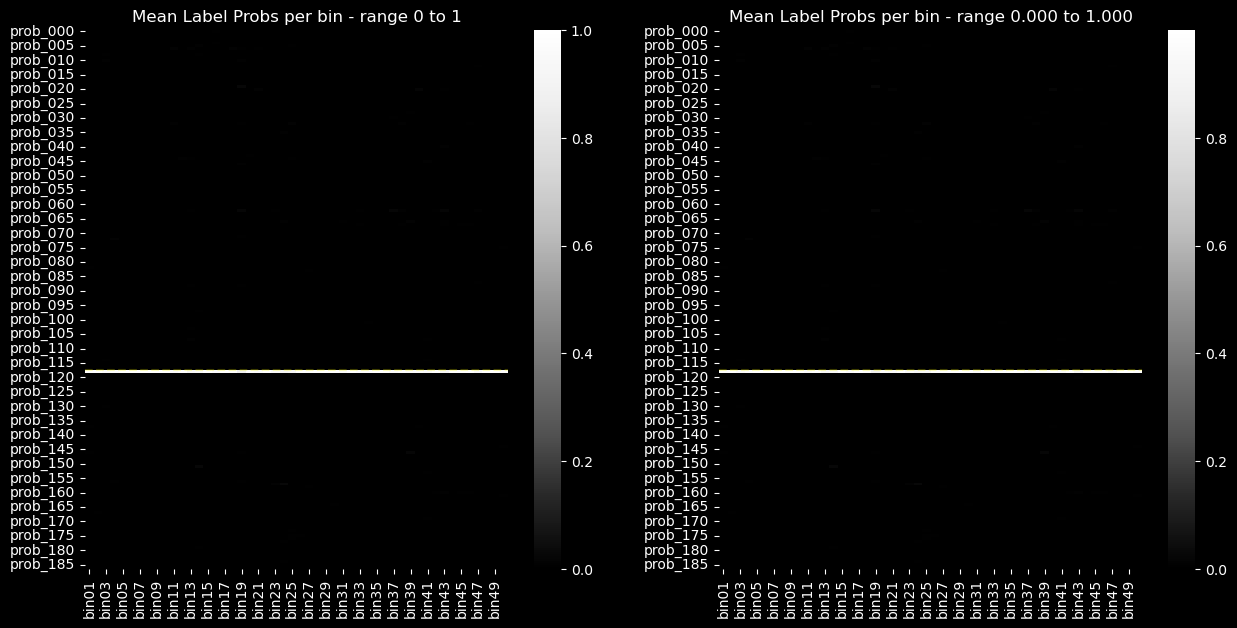

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
bin_min = bins_probs_mean.min().min()
bin_max = bins_probs_mean.max().max()
ax1.set_title(f"Mean Label Probs per bin - range 0 to 1")
ax2.set_title(f"Mean Label Probs per bin - range {bin_min:.3f} to {bin_max:.3f}")
ax1.hlines(y=118, xmin=0, xmax=50, color='yellow', linestyles='dashed', alpha=0.25)
ax2.hlines(y=118, xmin=0, xmax=50, color='yellow', linestyles='dashed', alpha=0.25)
sns.heatmap(bins_probs_mean.T, ax=ax1, cmap='Greys_r', cbar=True, vmax=1, vmin=0);
sns.heatmap(bins_probs_mean.T, ax=ax2, cmap='Greys_r', cbar=True);

We need to reshape `bins_probs_sum` to fit the `reads_prob_00i_sum` columns in `df_page_stats`:

In [ ]:
def flatten_probs(df):
    flattened_data = df.values.flatten()
    new_column_names = [f"{idx}_{col}" for idx in df.index for col in df.columns]
    return pd.DataFrame([flattened_data], columns=new_column_names)

cols = 'prob_000 prob_001 prob_002 prob_003 prob_004'.split(' ')
idx = 'bin01 bin02 bin03'.split(' ')
x = pd.DataFrame(np.arange(len(cols) * len(idx)).reshape(len(idx),len(cols)), columns=cols, index=idx)
display(x)
display(flatten_probs(x))
display(df_page_stats.iloc[0:1, 3 + 187:])

prob_000  prob_001  prob_002  prob_003  prob_004
bin01         0         1         2         3         4
bin02         5         6         7         8         9
bin03        10        11        12        13        14

bin01_prob_000  bin01_prob_001  bin01_prob_002  bin01_prob_003  \
0               0               1               2               3   

   bin01_prob_004  bin02_prob_000  bin02_prob_001  bin02_prob_002  \
0               4               5               6               7   

   bin02_prob_003  bin02_prob_004  bin03_prob_000  bin03_prob_001  \
0               8               9              10              11   

   bin03_prob_002  bin03_prob_003  bin03_prob_004  
0              12              13              14

Empty DataFrame
Columns: [bin01_prob_000_sum, bin01_prob_001_sum, bin01_prob_002_sum, bin01_prob_003_sum, bin01_prob_004_sum, bin01_prob_005_sum, bin01_prob_006_sum, bin01_prob_007_sum, bin01_prob_008_sum, bin01_prob_009_sum, bin01_prob_010_sum, bin01_prob_011_sum, bin01_prob_012_sum, bin01_prob_013_sum, bin01_prob_014_sum, bin01_prob_015_sum, bin01_prob_016_sum, bin01_prob_017_sum, bin01_prob_018_sum, bin01_prob_019_sum, bin01_prob_020_sum, bin01_prob_021_sum, bin01_prob_022_sum, bin01_prob_023_sum, bin01_prob_024_sum, bin01_prob_025_sum, bin01_prob_026_sum, bin01_prob_027_sum, bin01_prob_028_sum, bin01_prob_029_sum, bin01_prob_030_sum, bin01_prob_031_sum, bin01_prob_032_sum, bin01_prob_033_sum, bin01_prob_034_sum, bin01_prob_035_sum, bin01_prob_036_sum, bin01_prob_037_sum, bin01_prob_038_sum, bin01_prob_039_sum, bin01_prob_040_sum, bin01_prob_041_sum, bin01_prob_042_sum, bin01_prob_043_sum, bin01_prob_044_sum, bin01_prob_045_sum, bin01_prob_046_sum, bin01_prob_047_sum, bin01_prob_048_sum, bin01_prob_049_sum, bin01_prob_050_sum, bin01_prob_051_sum, bin01_prob_052_sum, bin01_prob_053_sum, bin01_prob_054_sum, bin01_prob_055_sum, bin01_prob_056_sum, bin01_prob_057_sum, bin01_prob_058_sum, bin01_prob_059_sum, bin01_prob_060_sum, bin01_prob_061_sum, bin01_prob_062_sum, bin01_prob_063_sum, bin01_prob_064_sum, bin01_prob_065_sum, bin01_prob_066_sum, bin01_prob_067_sum, bin01_prob_068_sum, bin01_prob_069_sum, bin01_prob_070_sum, bin01_prob_071_sum, bin01_prob_072_sum, bin01_prob_073_sum, bin01_prob_074_sum, bin01_prob_075_sum, bin01_prob_076_sum, bin01_prob_077_sum, bin01_prob_078_sum, bin01_prob_079_sum, bin01_prob_080_sum, bin01_prob_081_sum, bin01_prob_082_sum, bin01_prob_083_sum, bin01_prob_084_sum, bin01_prob_085_sum, bin01_prob_086_sum, bin01_prob_087_sum, bin01_prob_088_sum, bin01_prob_089_sum, bin01_prob_090_sum, bin01_prob_091_sum, bin01_prob_092_sum, bin01_prob_093_sum, bin01_prob_094_sum, bin01_prob_095_sum, bin01_prob_096_sum, bin01_prob_097_sum, bin01_prob_098_sum, bin01_prob_099_sum, ...]
Index: []

[0 rows x 9399 columns]

In [ ]:
flatten_probs(bins_probs_sum)

bin01_prob_000  bin01_prob_001  bin01_prob_002  bin01_prob_003  \
0         0.00067    4.741137e-07        0.000054        0.000121   

   bin01_prob_004  bin01_prob_005  bin01_prob_006  bin01_prob_007  \
0        0.014024    3.920837e-08        0.027131    2.758536e-08   

   bin01_prob_008  bin01_prob_009  ...  bin50_prob_177  bin50_prob_178  \
0    4.979009e-09    1.204013e-07  ...    3.626004e-08    1.077517e-12   

   bin50_prob_179  bin50_prob_180  bin50_prob_181  bin50_prob_182  \
0    1.923064e-08    4.523960e-10    7.825627e-09    1.458659e-08   

   bin50_prob_183  bin50_prob_184  bin50_prob_185  bin50_prob_186  
0    9.383632e-11        0.000001        0.000128    1.813254e-09  

[1 rows x 9350 columns]

In [ ]:
print(page_reads_stats_cols)
print(page_reads_probs_cols[:5])
print(page_bins_stats_cols[:5])

['reads_count', 'reads_acc_sum']
['reads_prob_000_sum', 'reads_prob_001_sum', 'reads_prob_002_sum', 'reads_prob_003_sum', 'reads_prob_004_sum']
['bin01_count', 'bin01_prob_000_sum', 'bin01_prob_001_sum', 'bin01_prob_002_sum', 'bin01_prob_003_sum']


Now we can update the stats in df_page_stats with the new values:
- build one row_page_stats for each page
- append the row_page_stats to df_page_stats for each page

In [ ]:
row_page_stats = pd.DataFrame(data=0, index=[0], columns=page_stats_cols)
row_page_stats.loc[0, page_reads_stats_cols] = [reads_count, reads_acc_sum]
assert len(page_reads_probs_cols) == len(reads_probs_sum)
row_page_stats.loc[0, page_reads_probs_cols] = reads_probs_sum.values
for b in range(n_position_bins):
    row_page_stats.loc[0, f"bin{b+1:02d}_count"] = bins_count.iloc[b]
    bin_probs_cols = [c for c in row_page_stats.columns if f"bin{b+1:02d}_prob_" in c]
    assert len(bin_probs_cols) == len(bins_probs_sum.iloc[b])
    row_page_stats.loc[0, bin_probs_cols] = bins_probs_sum.iloc[b].values


display(row_page_stats.loc[:, [c for c in row_page_stats.columns if 'count' in c]])
display(row_page_stats.loc[:, [c for c in row_page_stats.columns if '_prob_005' in c]])

reads_count  bin01_count  bin02_count  bin03_count  bin04_count  \
0        25250          505          505          505          404   

   bin05_count  bin06_count  bin07_count  bin08_count  bin09_count  ...  \
0          303          404          101          505          303  ...   

   bin41_count  bin42_count  bin43_count  bin44_count  bin45_count  \
0          606          404          404          404          606   

   bin46_count  bin47_count  bin48_count  bin49_count  bin50_count  
0          505          606          606          505          202  

[1 rows x 51 columns]

reads_prob_005_sum  bin01_prob_005_sum  bin02_prob_005_sum  \
0            7.110216        3.920837e-08            0.015132   

   bin03_prob_005_sum  bin04_prob_005_sum  bin05_prob_005_sum  \
0        3.265128e-09        8.129643e-07        8.932029e-10   

   bin06_prob_005_sum  bin07_prob_005_sum  bin08_prob_005_sum  \
0        1.185902e-09        4.734942e-11        8.698869e-09   

   bin09_prob_005_sum  ...  bin41_prob_005_sum  bin42_prob_005_sum  \
0        6.242393e-09  ...            0.000049        4.995971e-08   

   bin43_prob_005_sum  bin44_prob_005_sum  bin45_prob_005_sum  \
0            0.000008        4.216251e-09            0.000005   

   bin46_prob_005_sum  bin47_prob_005_sum  bin48_prob_005_sum  \
0        7.711012e-07            0.000104            0.000002   

   bin49_prob_005_sum  bin50_prob_005_sum  
0        1.093456e-08            0.006282  

[1 rows x 51 columns]

## Plot mean probabilities

In [93]:
def plot_mean_probabilities(df, figsize=(15,3)):
    prob_cols = [c for c in df.columns if c.startswith('prob_')]
    mean_probs = df.loc[:, prob_cols].mean(axis=0)
    mean_probs.index = range(len(mean_probs))

    fig, ax = plt.subplots(1,1, figsize=figsize)
    mean_probs.plot(kind='bar', ax=ax)
    ax.vlines(x=118, ymin=0, ymax=1, colors='gray', alpha=0.5)
    ax.hlines(xmin=0, xmax=186, y=0.9, colors='gray', alpha=0.5)
    ax.set_ylim((0,1))
    plt.show()

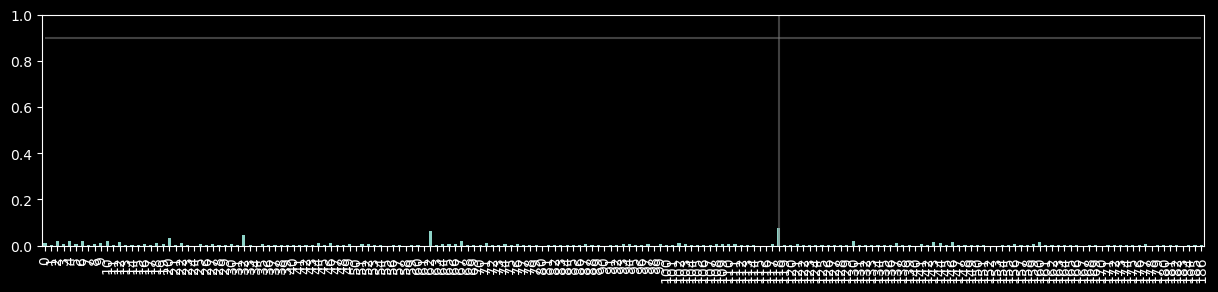

In [94]:
plot_mean_probabilities(df_probs)

In [161]:
# for b in sorted(df_probs.pos_bin.unique()):
#     plot_mean_probabilities(df_probs.loc[df_probs.pos_bin == b,:])

## Plot label probs per 50-mer read

In [137]:
def plot_label_mean_probs(probs, pos_bin=None):
    nb_seq, _ , nb_lbls = probs.shape
    assert nb_lbls == 187
    fig = plt.figure(figsize=(16, 2 * nb_seq - 1));
    # fig.suptitle('Suptitle')
    axs = []
    for i in range(nb_seq):
        cmap = 'afmhot'  # 'YlOrRd_r' 'YlGn_r' 'PuBu' 'YlGnBu_r' 'afmhot'
        axs.append(plt.subplot2grid((nb_seq,1), (i,0), rowspan=1, colspan=1))
        # axs[i].axis('off')
        axs[i].imshow(probs[i,:,:], cmap=cmap, aspect='auto')
        axs[i].set_title(f"Mean 50-mer Probabilities (Position bin: {pos_bin if pos_bin else 'all'})")

    fig.subplots_adjust(top=1.5, bottom=0.2, hspace=0.5)
    plt.show()

# plot_label_mean_probs(np.expand_dims(dfdf.values, 0))

In [104]:
dfdf = df_probs[prob_cols+['read_50mer_nb']].groupby('read_50mer_nb').mean()
df_probs.shape, dfdf.shape

((50500, 202), (101, 187))

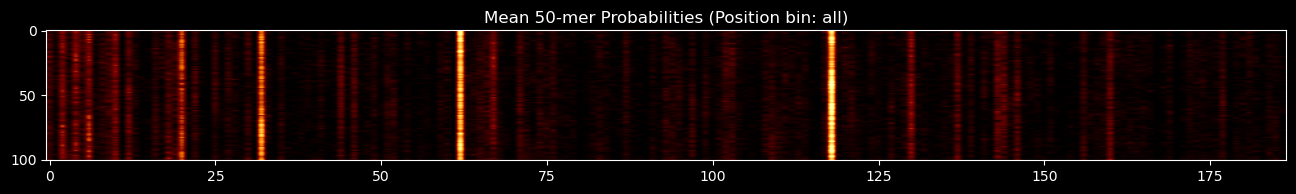

In [138]:
plot_label_mean_probs(np.expand_dims(dfdf.values, 0))

In [110]:
dfdfdf = df_probs[['pos_bin', 'read_50mer_nb'] + prob_cols].groupby(['pos_bin', 'read_50mer_nb']).mean()

In [82]:
dfdfdf.loc[(1, slice(None)), :]

prob_000      prob_001  prob_002      prob_003  \
pos_bin read_50mer_nb                                                       
1       0              5.067904e-05  5.993972e-07  0.017199  4.108684e-09   
        1              2.526477e-07  1.366579e-12  0.074097  5.335485e-08   
        2              2.320591e-05  6.127543e-12  0.033168  7.637674e-05   
        3              1.168287e-07  6.736310e-11  0.065980  5.918660e-05   
        4              1.327895e-08  6.917753e-09  0.001716  1.552400e-08   
...                             ...           ...       ...           ...   
        96             1.996202e-07  5.894185e-05  0.172780  4.372350e-08   
        97             1.450459e-06  1.508041e-10  0.009056  2.811314e-08   
        98             5.529503e-06  7.030084e-08  0.000955  2.915940e-07   
        99             3.899877e-05  1.984825e-06  0.044094  1.603227e-07   
        100            5.193669e-06  1.907886e-06  0.005791  5.129502e-09   

                       prob_004      prob_005      prob_006      prob_007  \
pos_bin read_50mer_nb                                                       
1       0              0.030113  3.406494e-10  6.017990e-07  2.458540e-06   
        1              0.000001  2.484385e-08  2.760795e-08  4.262330e-04   
        2              0.000039  1.602084e-08  7.263936e-05  3.908913e-03   
        3              0.000347  6.870188e-09  9.410992e-07  1.186960e-05   
        4              0.115106  4.266132e-13  1.991560e-07  9.696282e-09   
...                         ...           ...           ...           ...   
        96             0.032079  3.209101e-06  9.933687e-08  1.633060e-09   
        97             0.001369  7.731129e-04  1.140941e-08  7.864150e-08   
        98             0.007308  3.808865e-07  3.101433e-05  2.010219e-07   
        99             0.012434  4.239362e-09  6.518161e-06  1.253214e-07   
        100            0.002836  1.029941e-05  7.818632e-08  7.323236e-11   

                           prob_008      prob_009  ...      prob_177  \
pos_bin read_50mer_nb                              ...                 
1       0              9.286059e-10  4.510764e-08  ...  1.731345e-08   
        1              2.129618e-11  2.375891e-10  ...  1.369647e-08   
        2              3.295860e-12  5.230509e-09  ...  6.435008e-03   
        3              3.683200e-08  2.655489e-09  ...  3.453928e-04   
        4              8.262650e-09  6.029276e-08  ...  1.030558e-08   
...                             ...           ...  ...           ...   
        96             9.996333e-07  2.790312e-03  ...  2.802706e-03   
        97             1.590303e-08  3.294723e-08  ...  5.284202e-06   
        98             9.188743e-09  8.298832e-09  ...  3.492986e-06   
        99             2.147930e-07  8.098762e-08  ...  5.671781e-04   
        100            1.862649e-09  3.159331e-07  ...  2.622214e-05   

                           prob_178      prob_179      prob_180      prob_181  \
pos_bin read_50mer_nb                                                           
1       0              1.447166e-07  7.210717e-07  4.998805e-12  7.880604e-07   
        1              3.788906e-09  3.954021e-10  3.931263e-09  3.272376e-11   
        2              2.665808e-06  6.245586e-09  6.074816e-14  3.280704e-10   
        3              9.849925e-08  2.264858e-09  8.039886e-10  3.435533e-08   
        4              3.549616e-09  1.533239e-09  7.161604e-10  3.144220e-11   
...                             ...           ...           ...           ...   
        96             2.651745e-11  1.515620e-06  4.767635e-02  3.936595e-10   
        97             1.192783e-10  9.582923e-11  1.141276e-01  3.386189e-12   
        98             2.464075e-11  8.531349e-08  7.383371e-04  2.001050e-11   
        99             2.511018e-09  2.728945e-09  3.014377e-08  5.371723e-04   
        100            1.815038e-07  3.390525e-08  1.451902e-04  8.455052e-11   

                           prob_

In [112]:
dfdfdf.loc[(slice(None), 0), :].head()

prob_000      prob_001      prob_002      prob_003  \
pos_bin read_50mer_nb                                                           
1       0              5.067904e-05  5.993972e-07  1.719878e-02  4.108684e-09   
2       0              5.122645e-07  4.062378e-05  8.950027e-05  1.219833e-03   
3       0              9.353386e-04  3.238074e-06  2.780455e-08  1.033361e-09   
4       0              2.168899e-02  1.835682e-06  2.344609e-06  2.361963e-08   
5       0              9.250908e-10  2.265166e-09  1.277759e-05  1.378406e-07   

                       prob_004      prob_005      prob_006      prob_007  \
pos_bin read_50mer_nb                                                       
1       0              0.030113  3.406494e-10  6.017990e-07  2.458540e-06   
2       0              0.000864  9.651420e-06  8.066119e-07  4.593035e-04   
3       0              0.075079  1.406227e-09  2.695516e-05  1.454708e-11   
4       0              0.000074  2.477134e-10  2.803866e-02  6.776841e-12   
5       0              0.001523  6.527713e-08  8.068590e-04  1.972146e-05   

                           prob_008      prob_009  ...      prob_177  \
pos_bin read_50mer_nb                              ...                 
1       0              9.286059e-10  4.510764e-08  ...  1.731345e-08   
2       0              1.560989e-03  1.882731e-08  ...  7.536068e-09   
3       0              5.714326e-08  6.951616e-08  ...  1.568796e-07   
4       0              8.965831e-07  2.890712e-03  ...  3.401127e-06   
5       0              4.359873e-12  1.001727e-01  ...  2.155008e-03   

                           prob_178      prob_179      prob_180      prob_181  \
pos_bin read_50mer_nb                                                           
1       0              1.447166e-07  7.210717e-07  4.998805e-12  7.880604e-07   
2       0              5.849848e-05  4.547258e-06  4.452349e-08  4.829858e-09   
3       0              1.766685e-08  3.185508e-05  3.761685e-03  1.847326e-06   
4       0              8.500062e-08  1.474403e-10  1.720545e-11  2.871227e-07   
5       0              2.661414e-12  7.364066e-06  4.405080e-10  6.813264e-09   

                           prob_182      prob_183      prob_184      prob_185  \
pos_bin read_50mer_nb                                                           
1       0              4.579868e-09  4.585445e-13  5.878870e-10  2.154018e-13   
2       0              3.745027e-07  2.406230e-06  6.322227e-09  1.141457e-04   
3       0              3.228750e-12  1.064687e-10  9.910607e-06  4.568835e-08   
4       0              2.503385e-07  2.017946e-07  1.891762e-06  7.317120e-11   
5       0              9.903893e-02  1.633508e-15  7.138325e-06  1.135666e-06   

                           prob_186  
pos_bin read_50mer_nb                
1       0              1.821190e-11  
2       0              1.019268e-09  
3       0              8.199399e-08  
4       0              1.186656e-11  
5       0              5.958216e-06  

[5 rows x 187 columns]

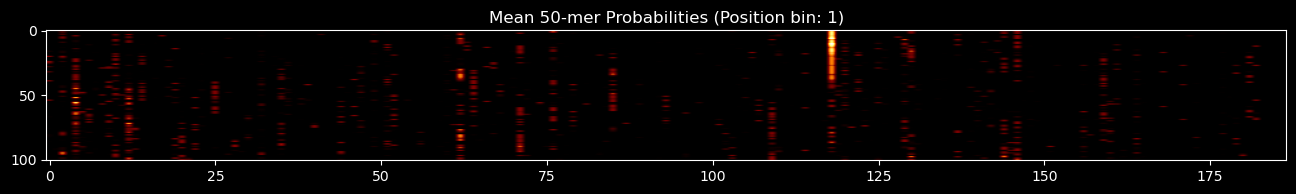

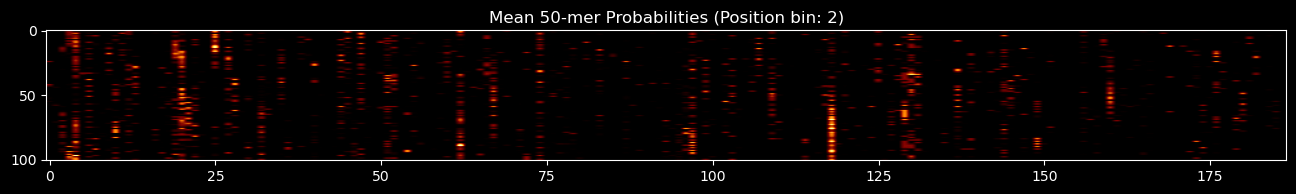

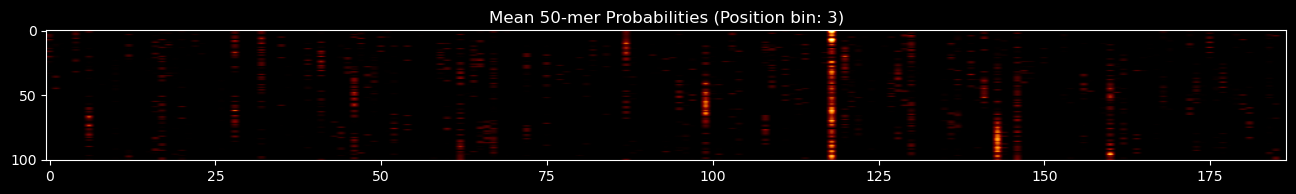

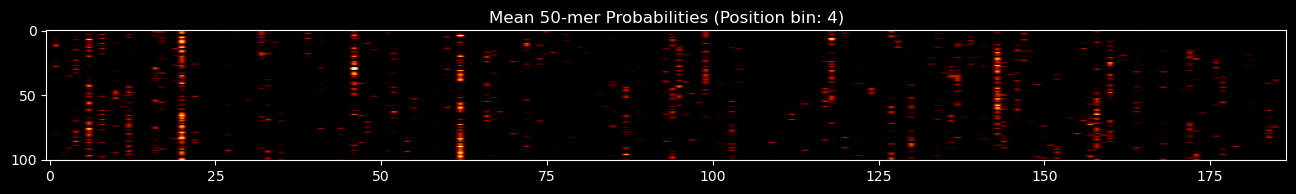

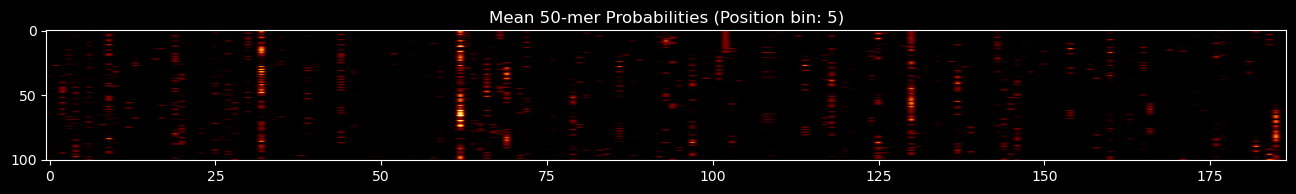

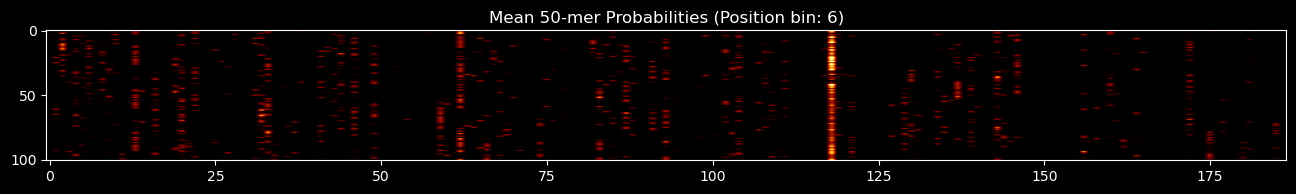

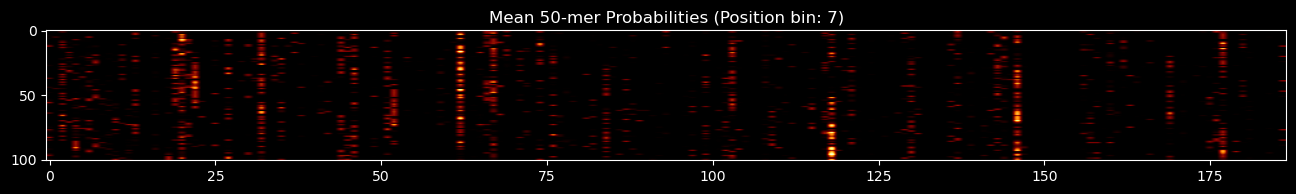

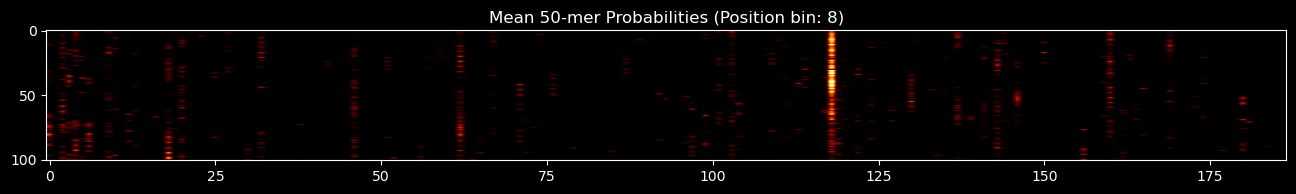

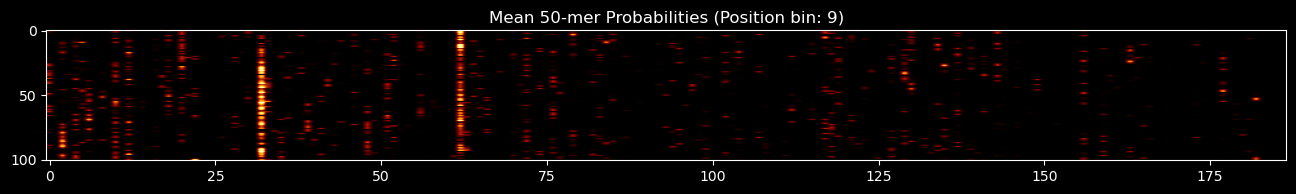

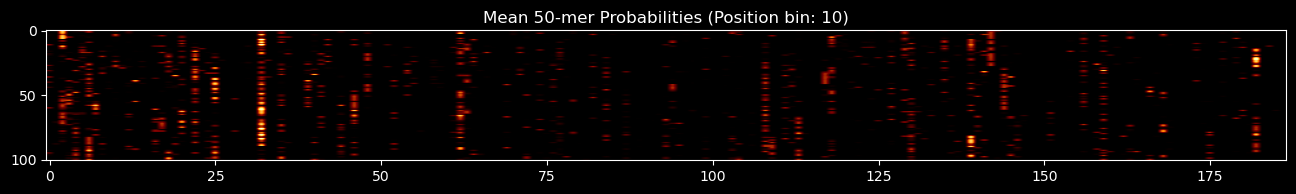

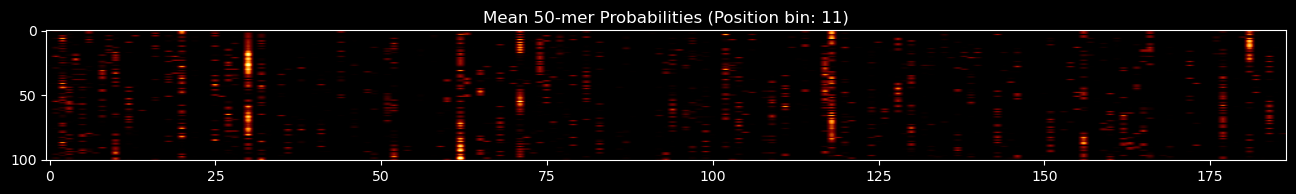

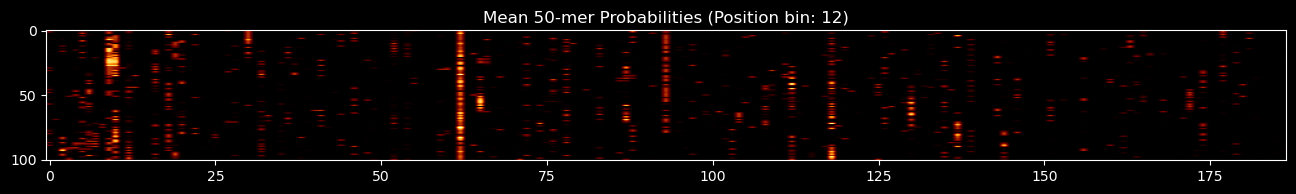

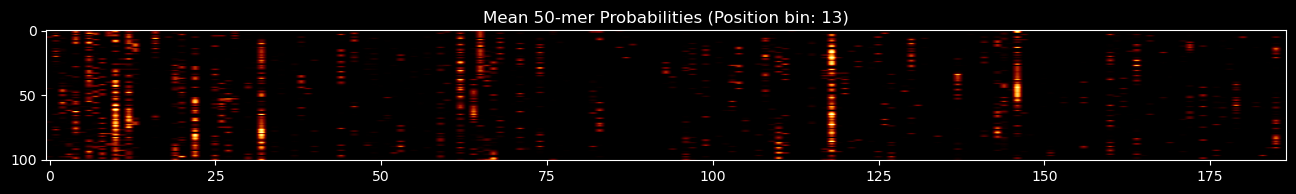

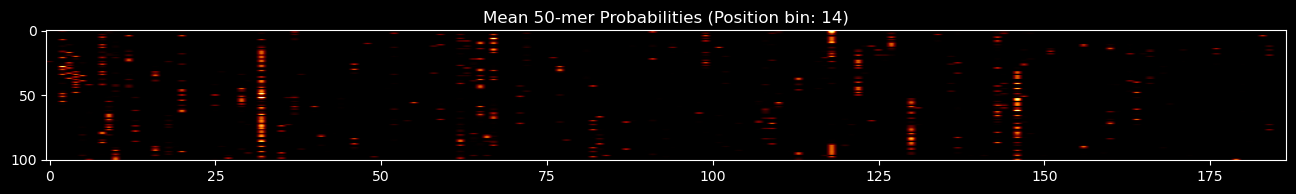

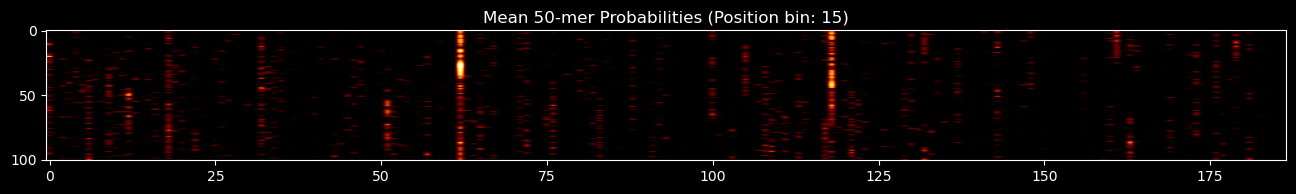

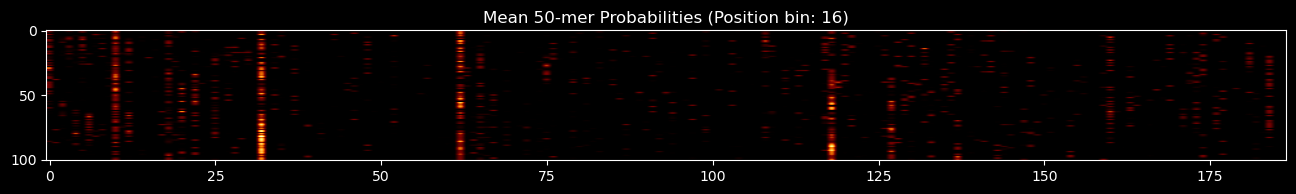

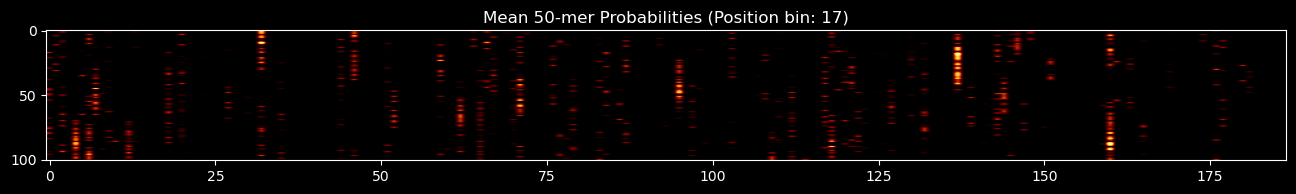

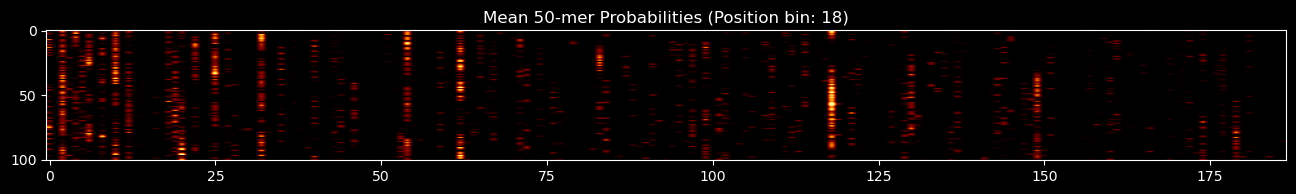

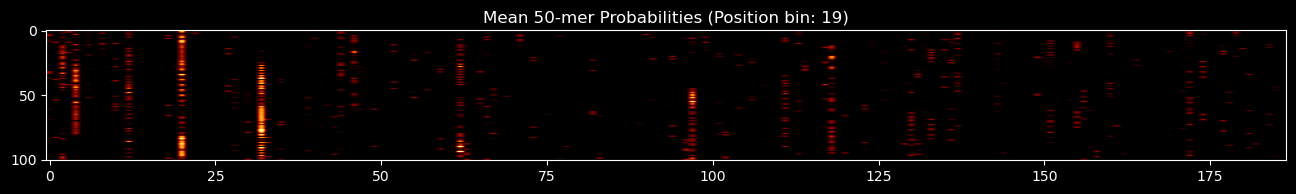

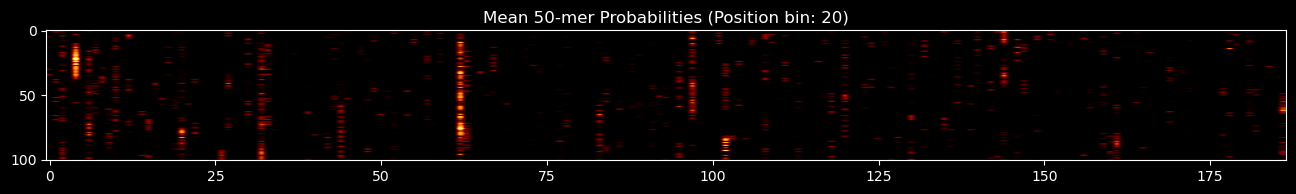

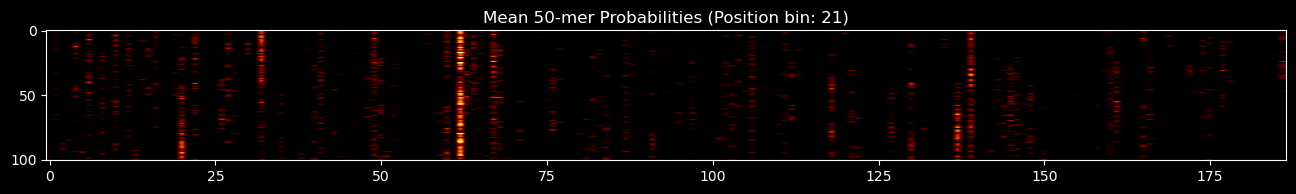

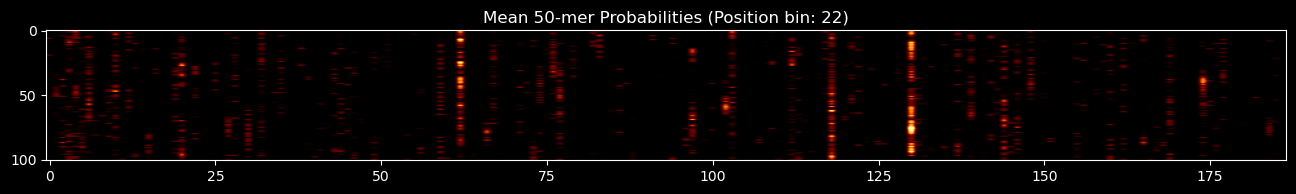

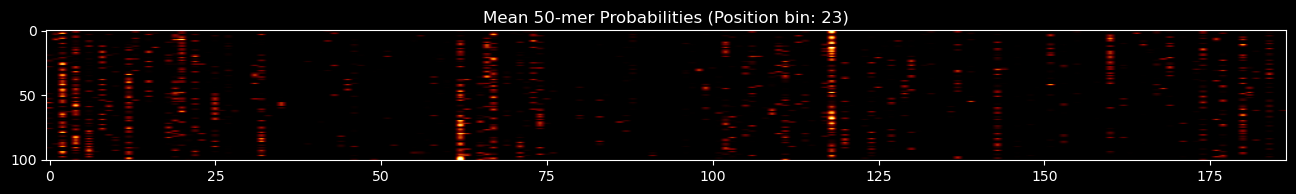

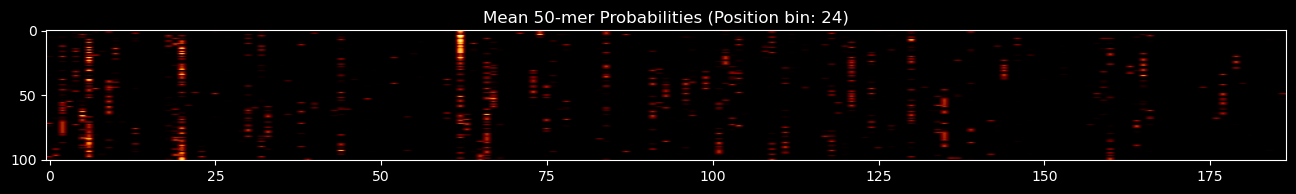

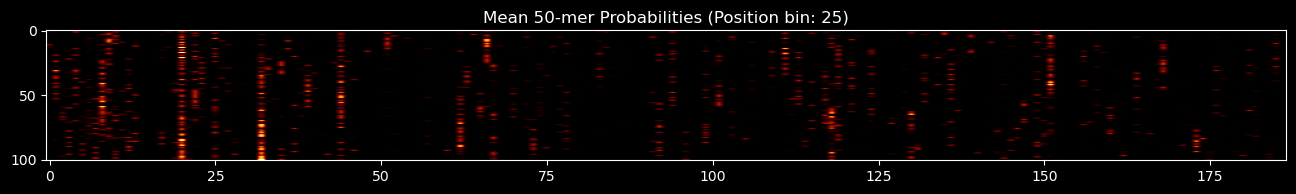

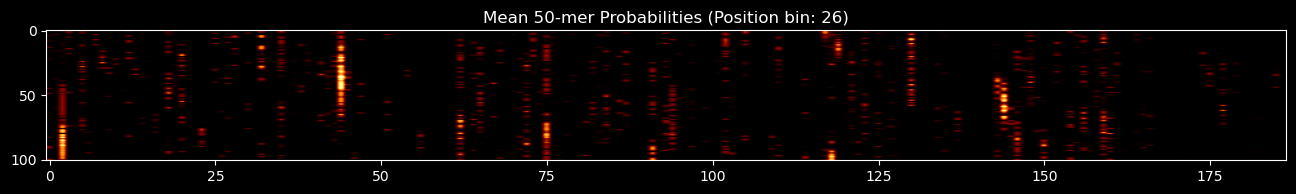

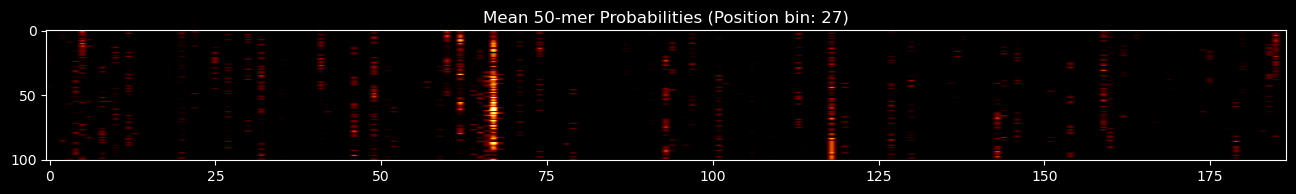

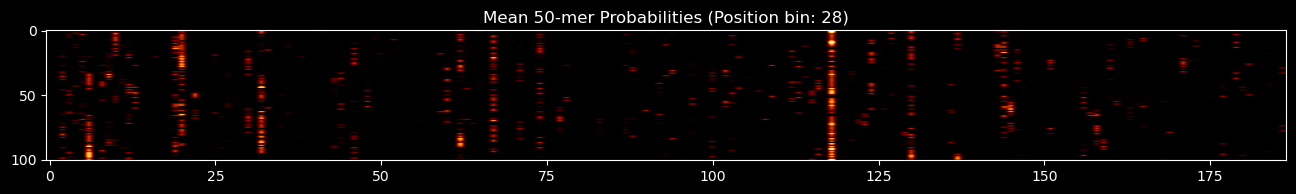

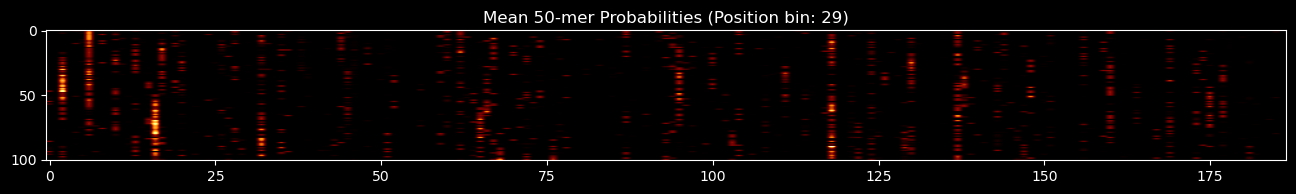

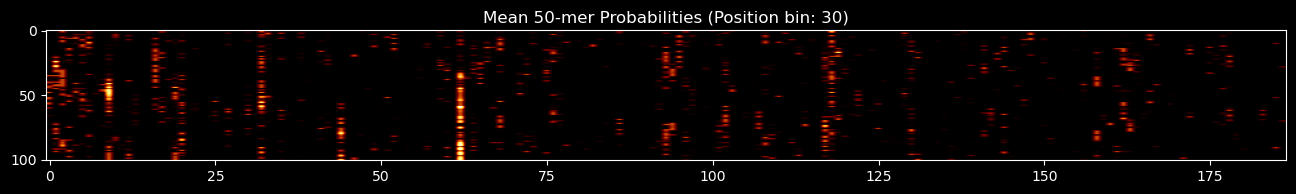

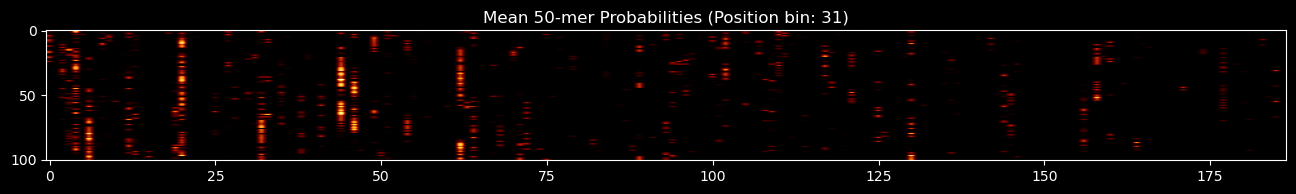

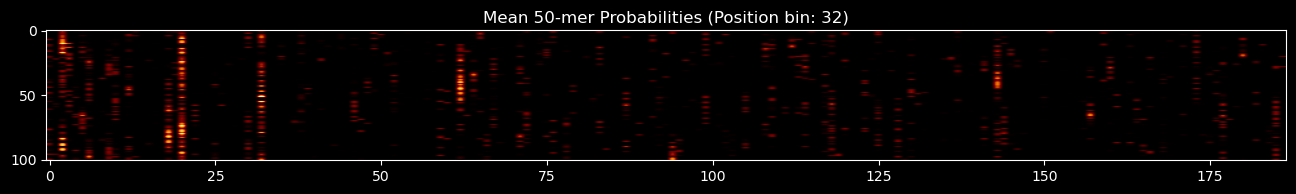

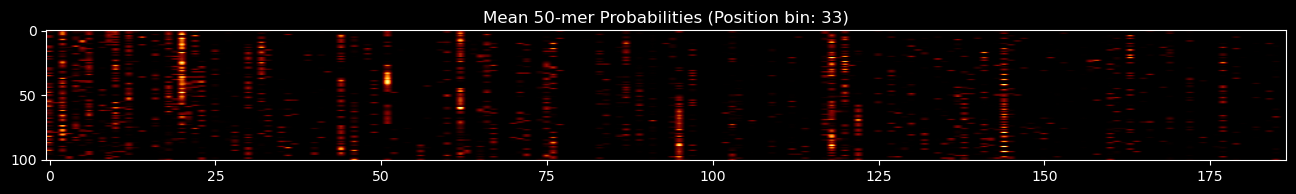

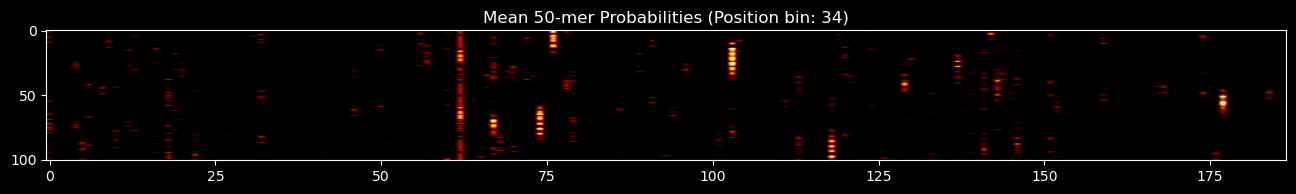

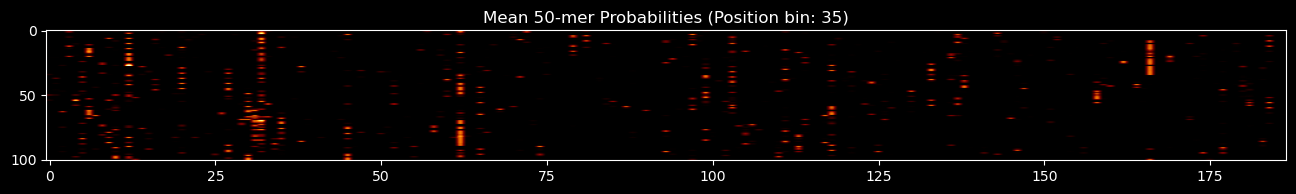

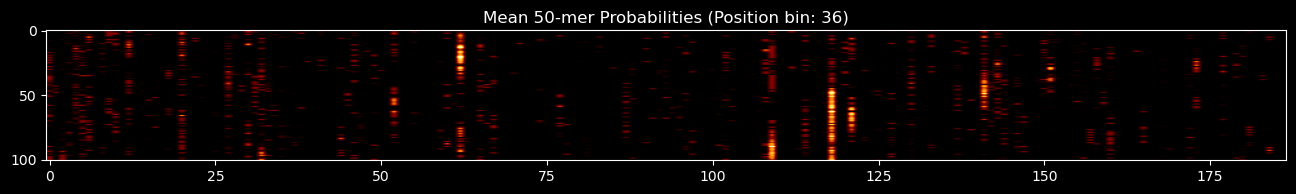

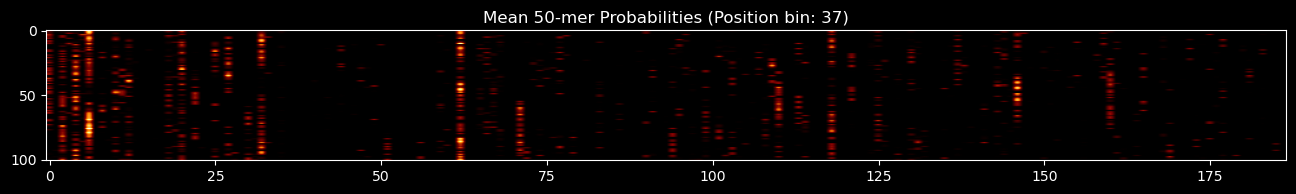

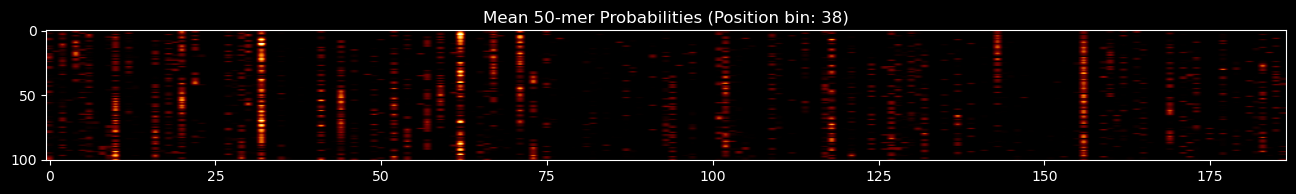

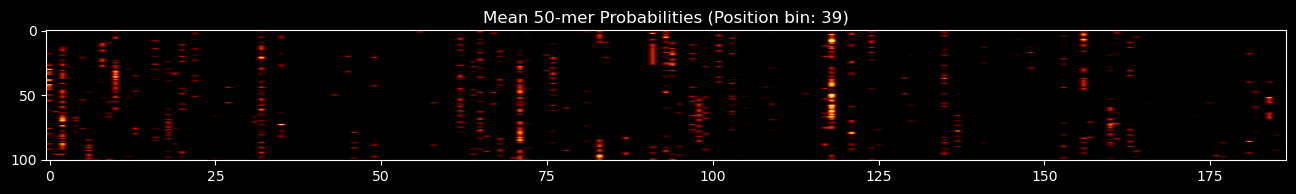

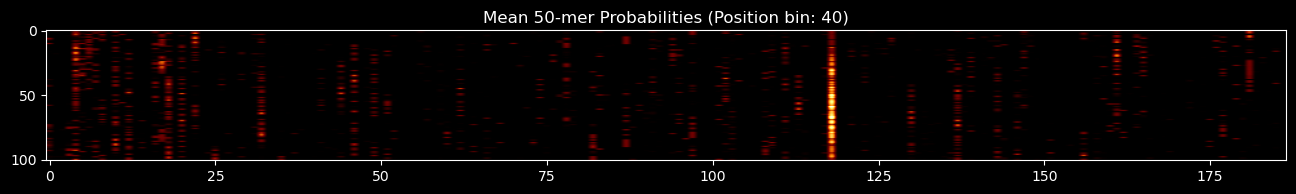

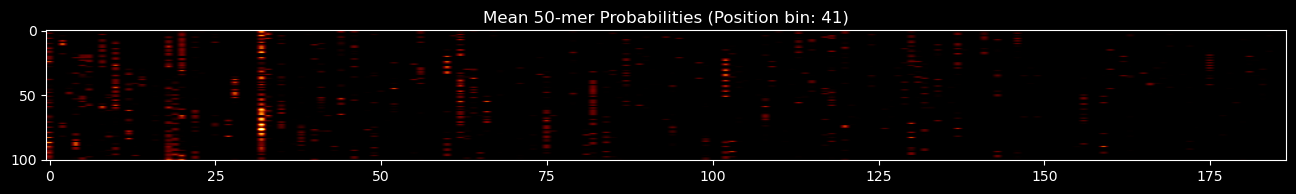

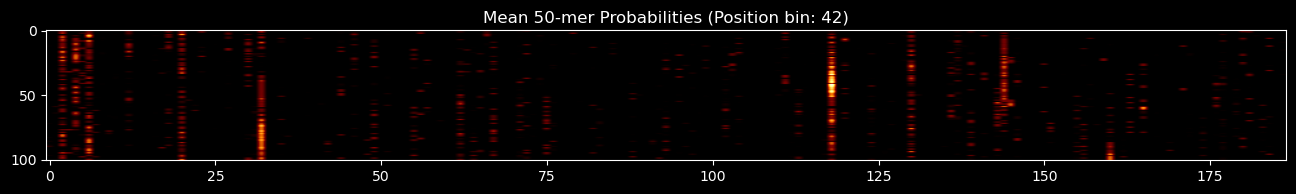

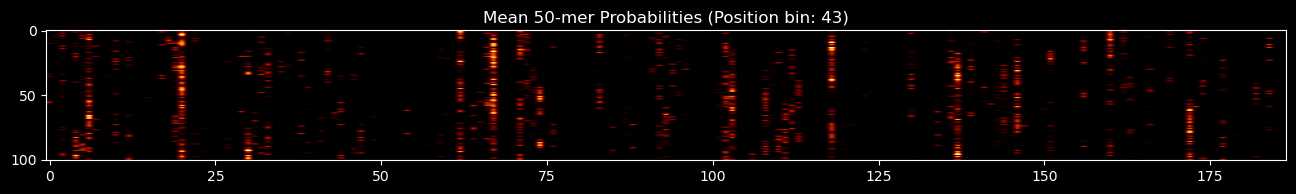

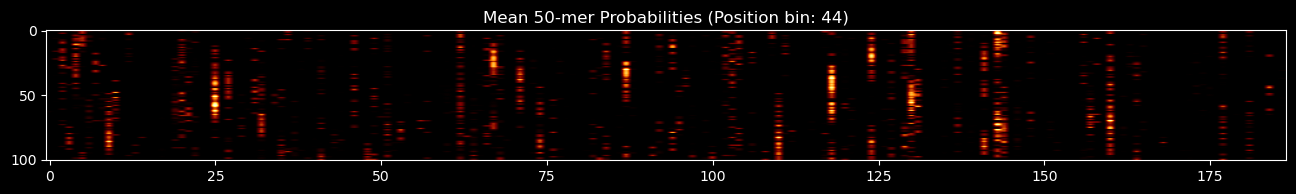

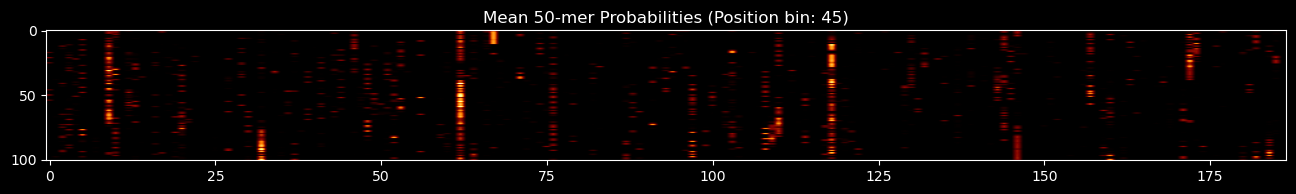

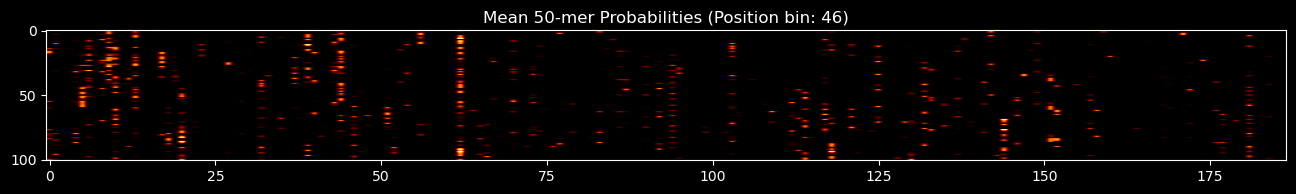

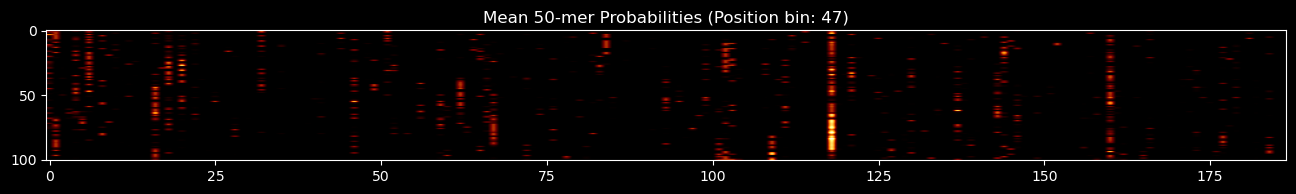

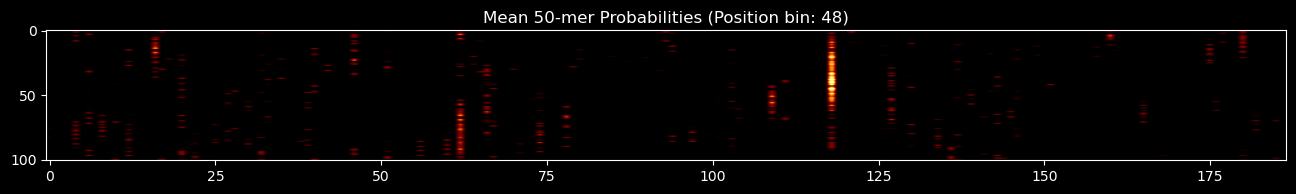

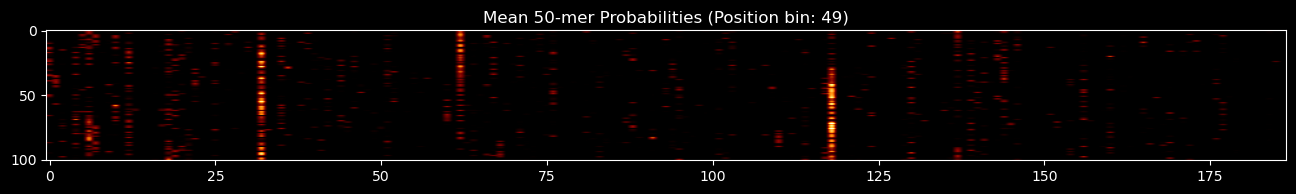

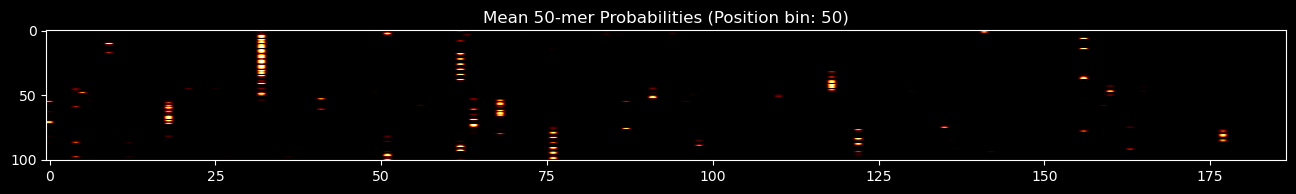

In [139]:
for i in range(1,51):
    plot_label_mean_probs(np.expand_dims(dfdfdf.loc[(i, slice(None)), :].values, 0), pos_bin=i)

In [157]:
ollbl = OriginalLabels()
ollbl.label2species(32)

'Human_gammaherpesvirus_8'

In [178]:
i = 2
counts, np.argmax(counts), np.argpartition(counts, -i)[-i]

(array([ 2,  1,  1,  1,  8, 28,  1,  5,  9,  4,  7,  7,  1,  2,  1,  6,  4,
         1,  1,  5,  1,  1,  4]),
 5,
 8)

118 Yellow_fever_virus  |  62 Human_gammaherpesvirus_4


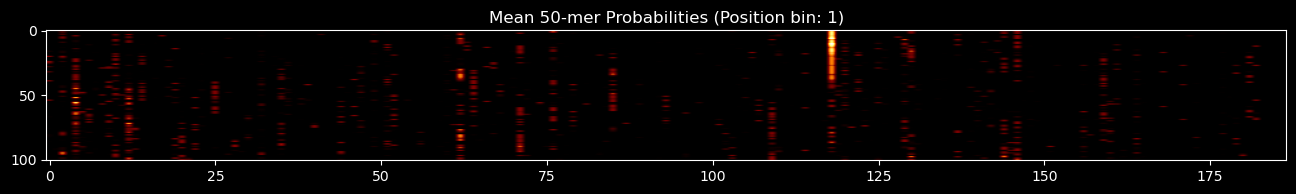

118 Yellow_fever_virus  |  20 Cercopithecine_betaherpesvirus_5


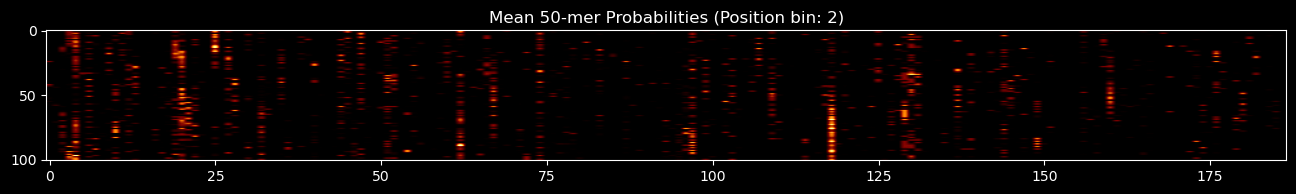

118 Yellow_fever_virus  |  143 Powassan_virus


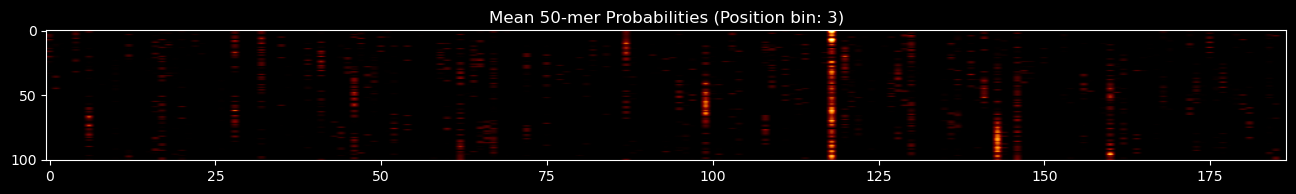

20 Cercopithecine_betaherpesvirus_5  |  62 Human_gammaherpesvirus_4


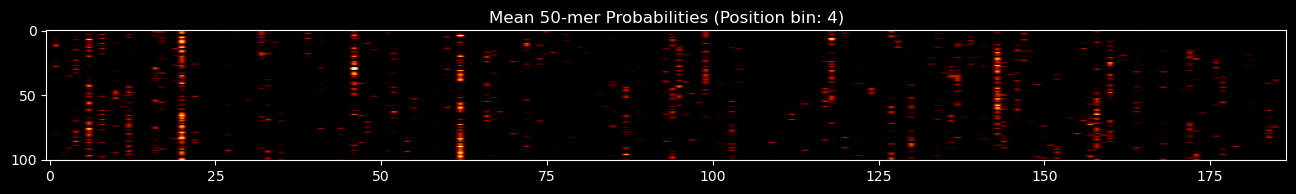

62 Human_gammaherpesvirus_4  |  32 Human_gammaherpesvirus_8


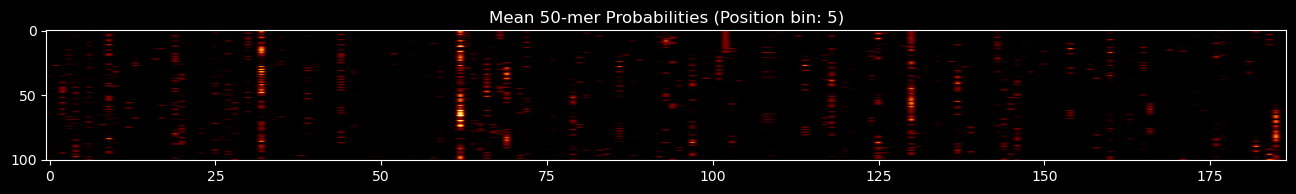

118 Yellow_fever_virus  |  62 Human_gammaherpesvirus_4


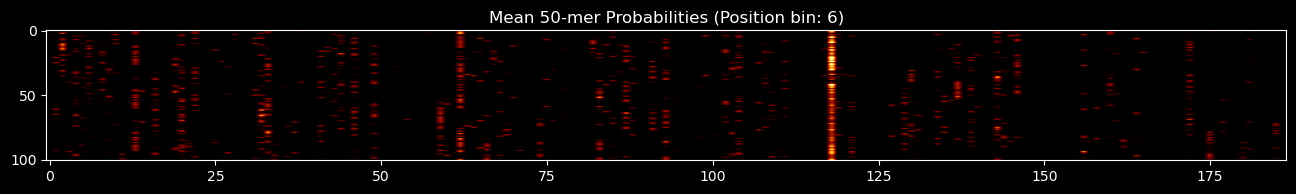

62 Human_gammaherpesvirus_4  |  118 Yellow_fever_virus


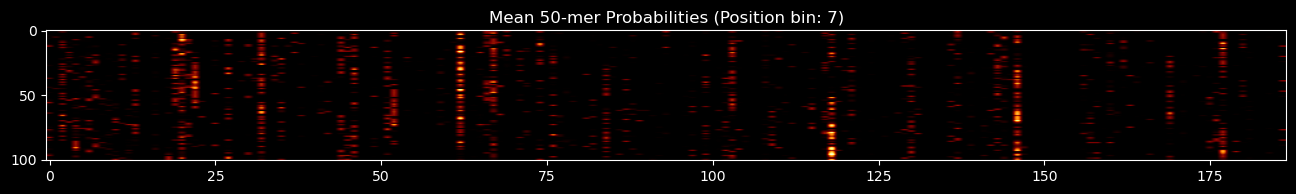

118 Yellow_fever_virus  |  62 Human_gammaherpesvirus_4


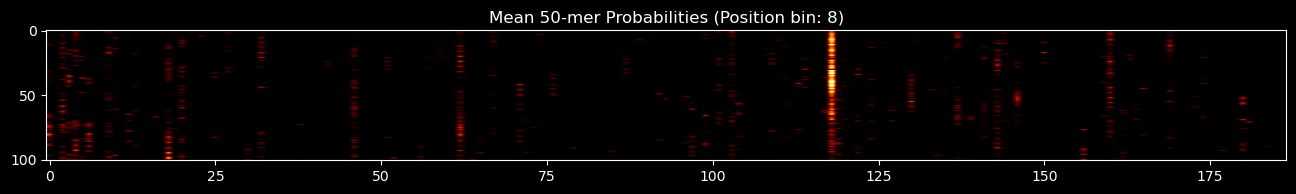

32 Human_gammaherpesvirus_8  |  62 Human_gammaherpesvirus_4


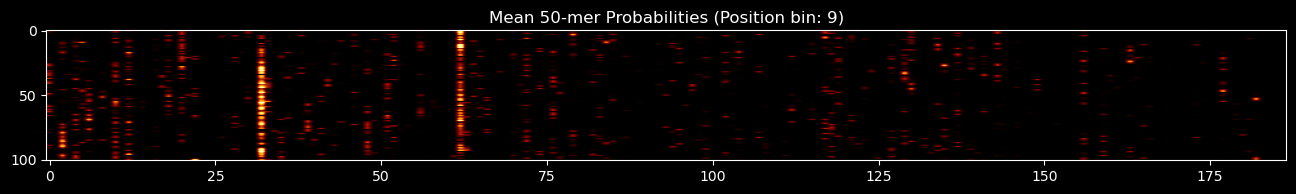

32 Human_gammaherpesvirus_8  |  25 Human_alphaherpesvirus_1


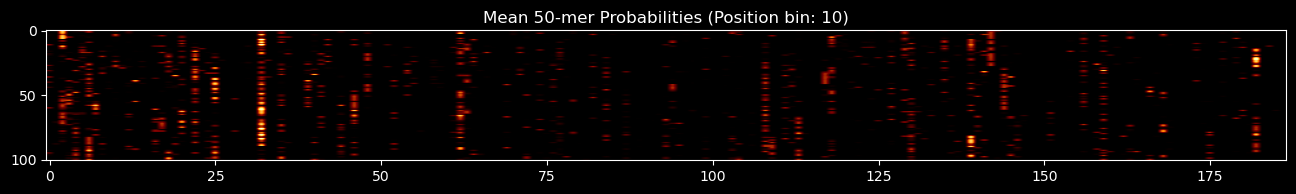

30 Human_mastadenovirus_E  |  118 Yellow_fever_virus


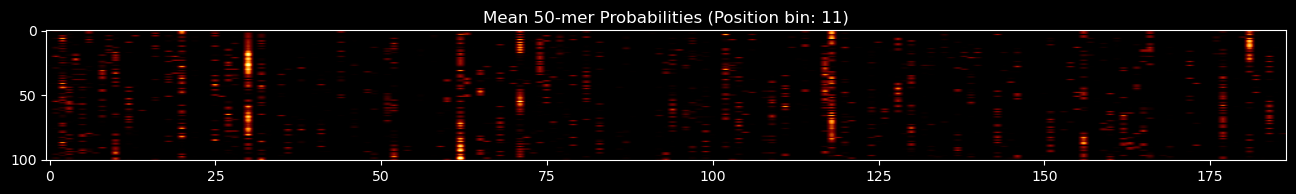

62 Human_gammaherpesvirus_4  |  10 Human_alphaherpesvirus_3


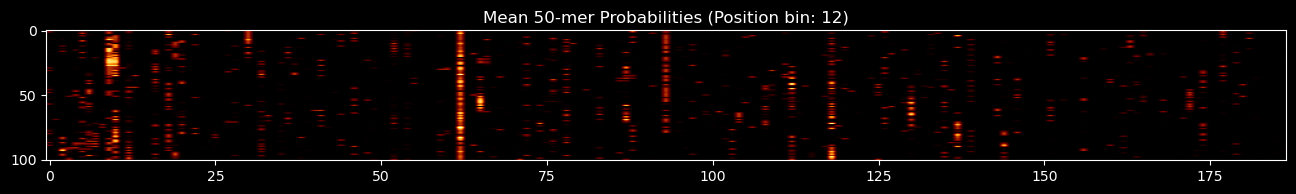

118 Yellow_fever_virus  |  10 Human_alphaherpesvirus_3


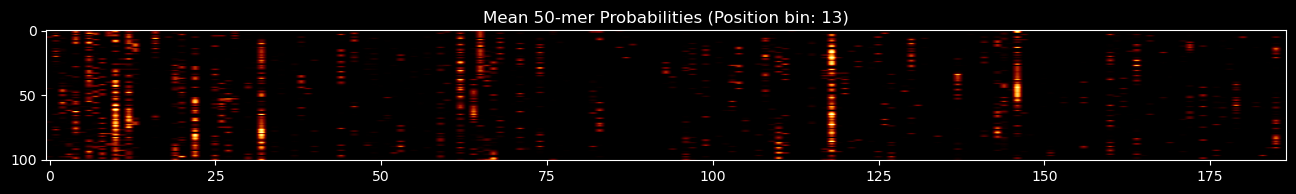

32 Human_gammaherpesvirus_8  |  146 West_Nile_virus


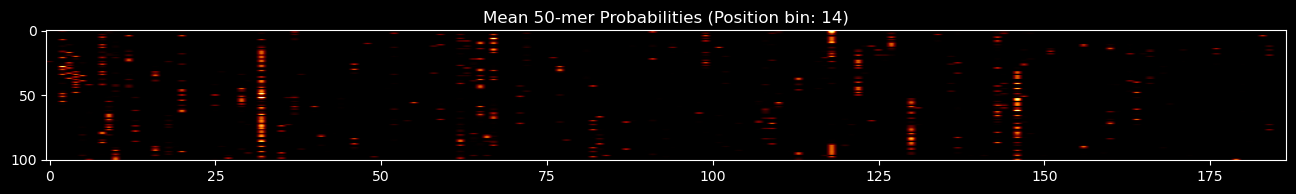

62 Human_gammaherpesvirus_4  |  118 Yellow_fever_virus


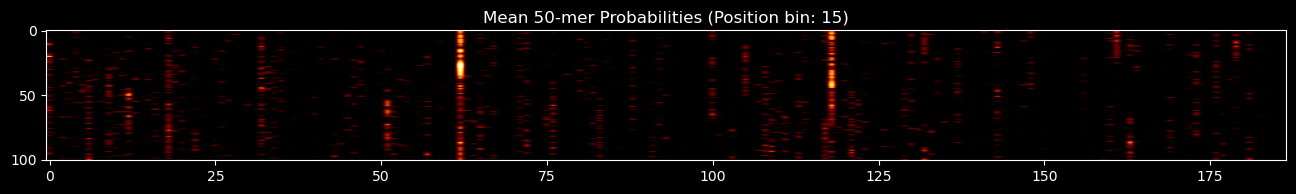

32 Human_gammaherpesvirus_8  |  62 Human_gammaherpesvirus_4


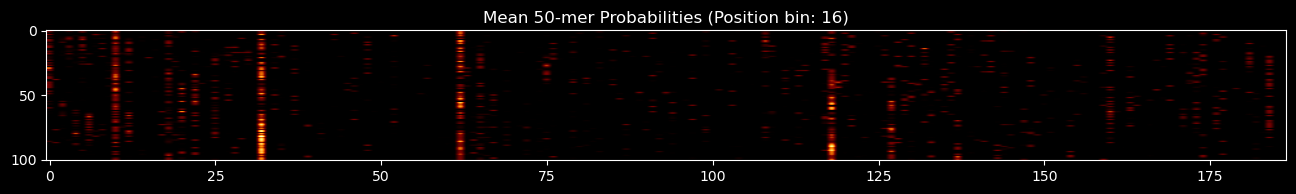

137 Japanese_encephalitis_virus  |  160 Langat_virus


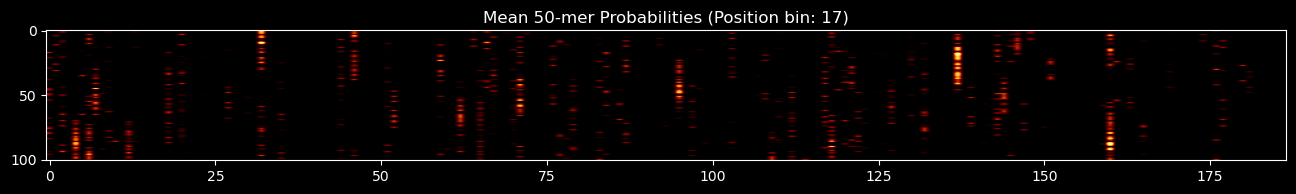

118 Yellow_fever_virus  |  62 Human_gammaherpesvirus_4


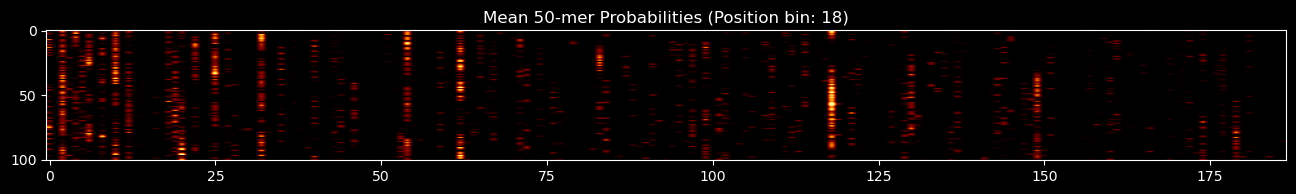

32 Human_gammaherpesvirus_8  |  20 Cercopithecine_betaherpesvirus_5


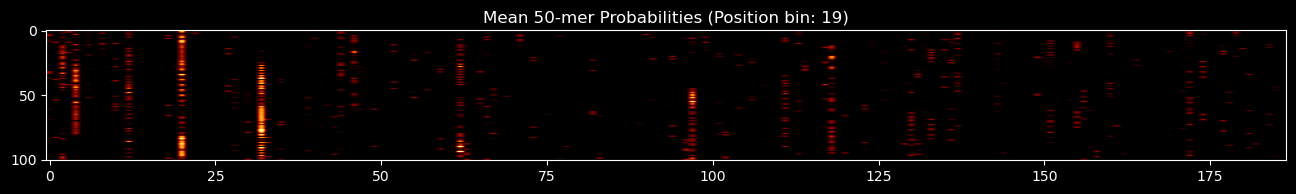

62 Human_gammaherpesvirus_4  |  4 Human_betaherpesvirus_6B


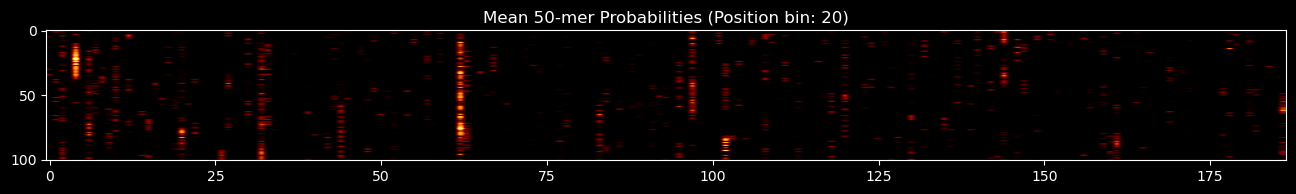

62 Human_gammaherpesvirus_4  |  137 Japanese_encephalitis_virus


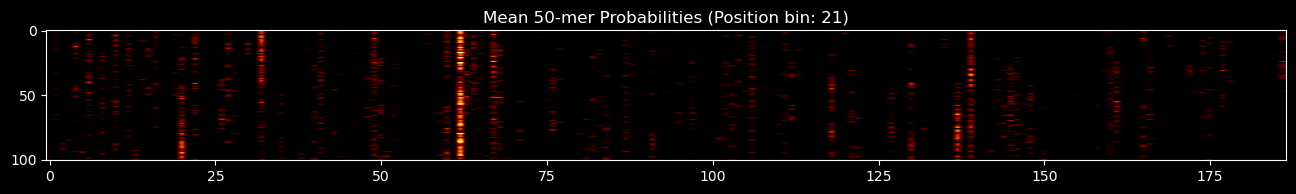

130 Zika_virus  |  62 Human_gammaherpesvirus_4


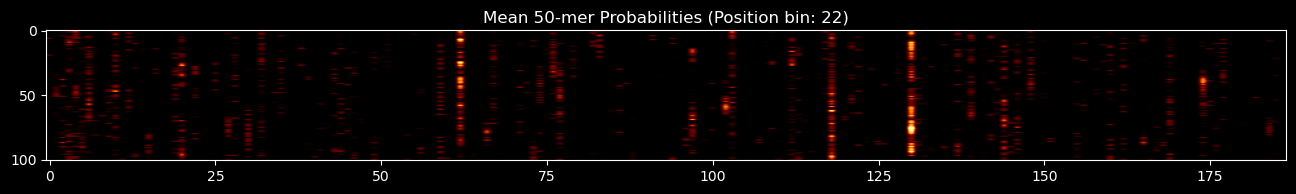

118 Yellow_fever_virus  |  2 Molluscum_contagiosum_virus


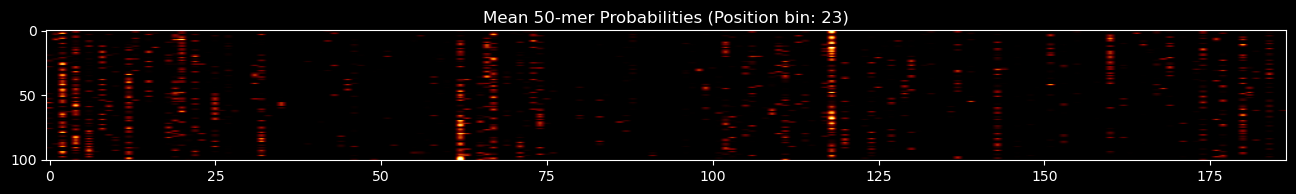

6 Human_betaherpesvirus_5  |  6 Human_betaherpesvirus_5


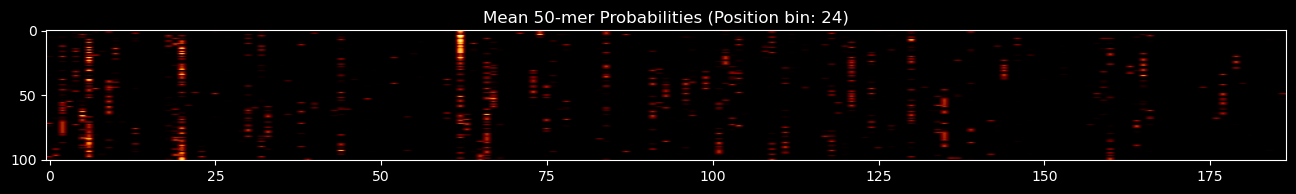

20 Cercopithecine_betaherpesvirus_5  |  32 Human_gammaherpesvirus_8


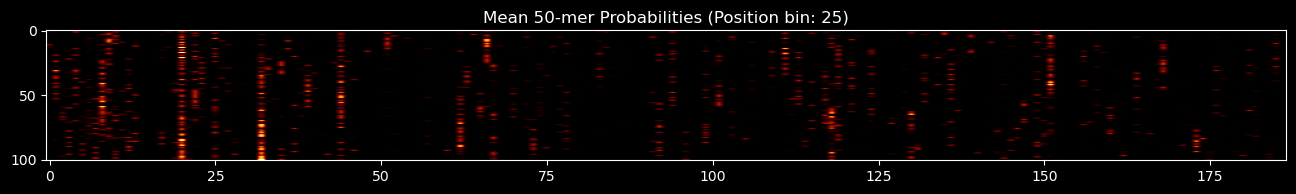

44 Venezuelan_equine_encephalitis_virus  |  2 Molluscum_contagiosum_virus


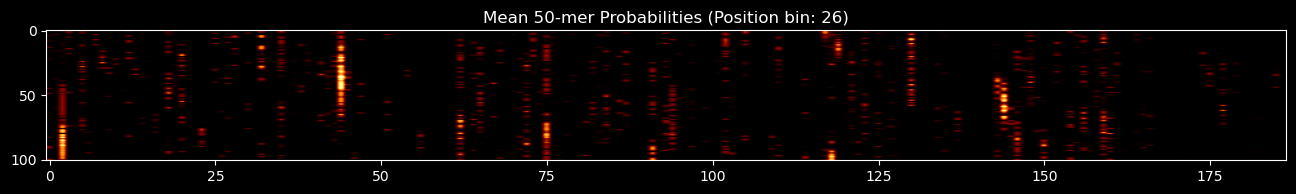

67 Louping_ill_virus  |  118 Yellow_fever_virus


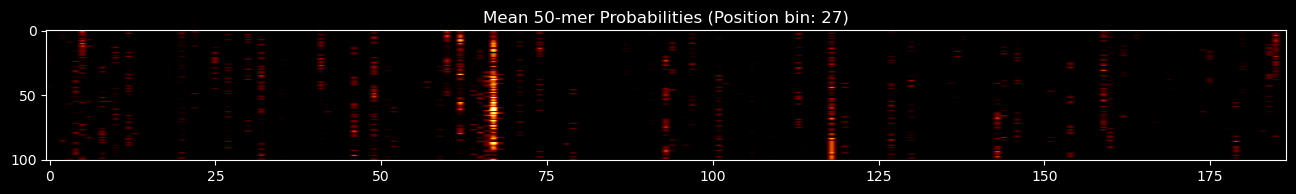

118 Yellow_fever_virus  |  20 Cercopithecine_betaherpesvirus_5


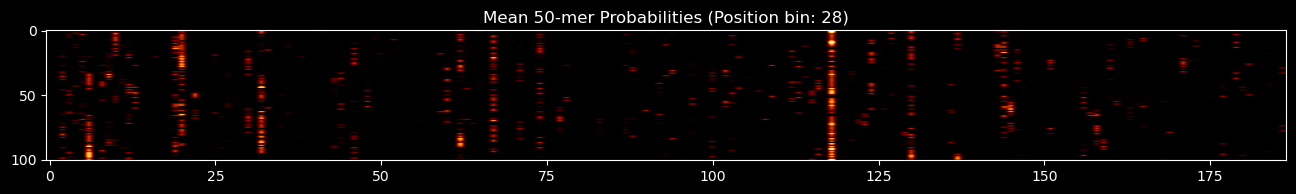

16 Hendra_henipavirus  |  6 Human_betaherpesvirus_5


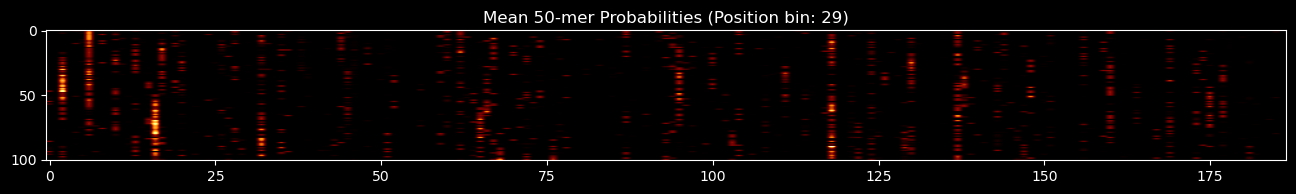

62 Human_gammaherpesvirus_4  |  9 Alphapapillomavirus_3


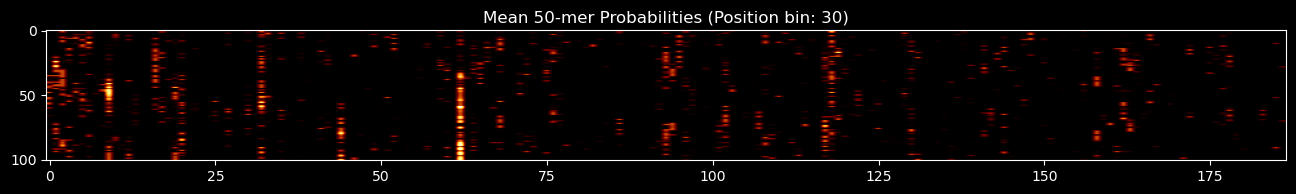

44 Venezuelan_equine_encephalitis_virus  |  20 Cercopithecine_betaherpesvirus_5


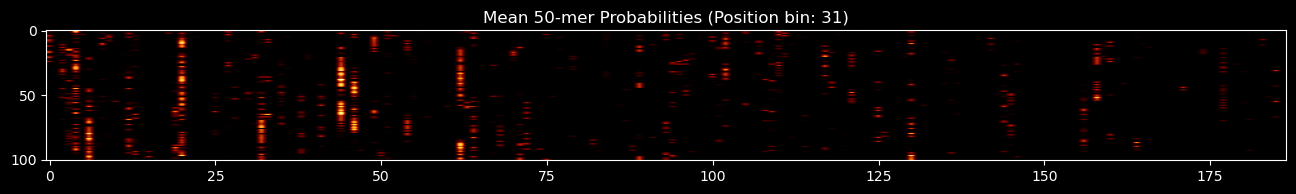

20 Cercopithecine_betaherpesvirus_5  |  32 Human_gammaherpesvirus_8


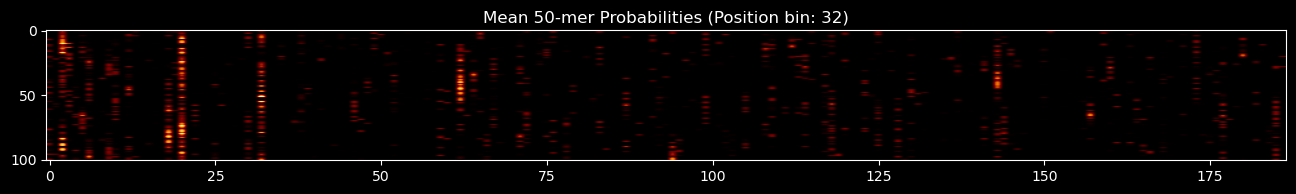

20 Cercopithecine_betaherpesvirus_5  |  144 Saint_Louis_encephalitis_virus


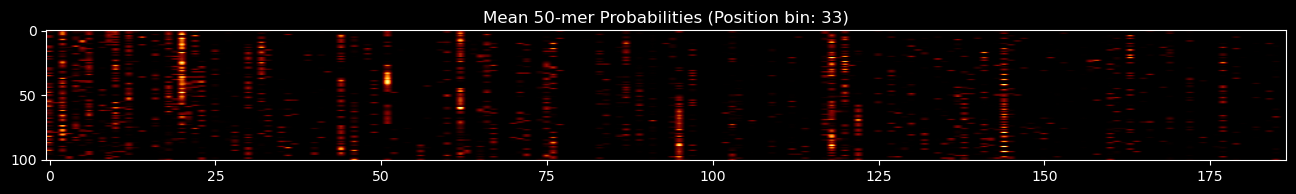

103 Murray_Valley_encephalitis_virus  |  177 Uukuniemi_phlebovirus


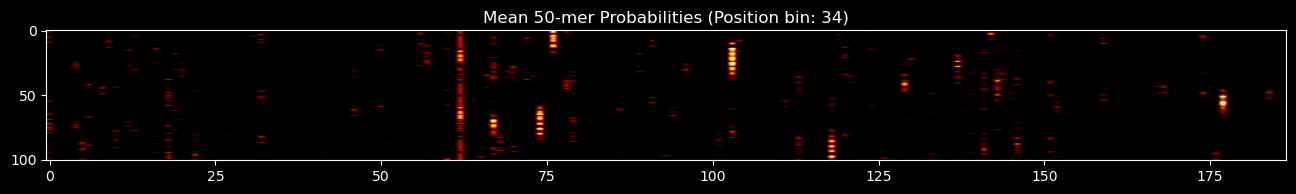

62 Human_gammaherpesvirus_4  |  12 Human_betaherpesvirus_6A


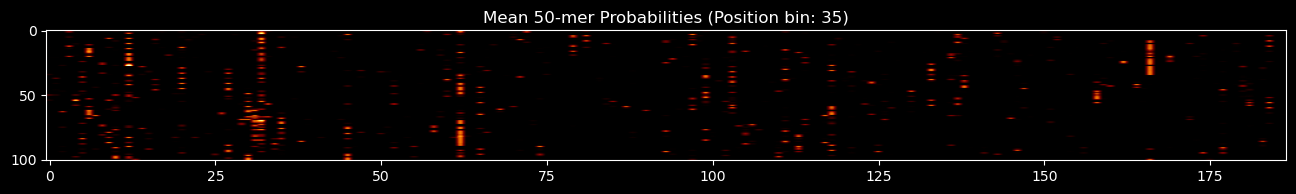

118 Yellow_fever_virus  |  62 Human_gammaherpesvirus_4


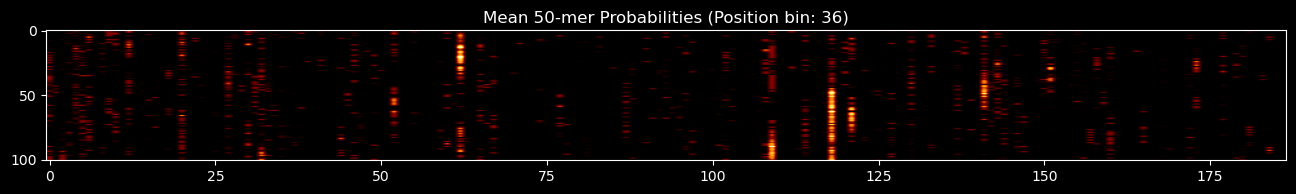

6 Human_betaherpesvirus_5  |  62 Human_gammaherpesvirus_4


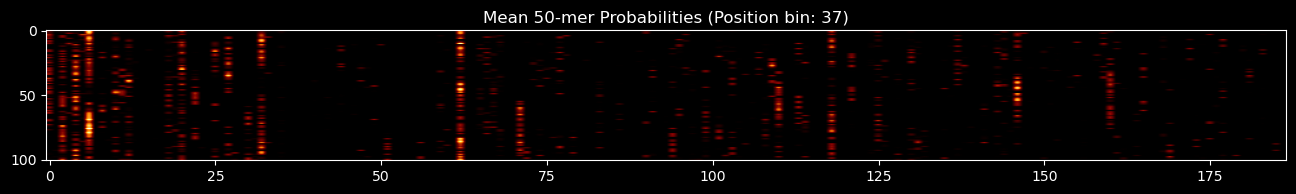

32 Human_gammaherpesvirus_8  |  62 Human_gammaherpesvirus_4


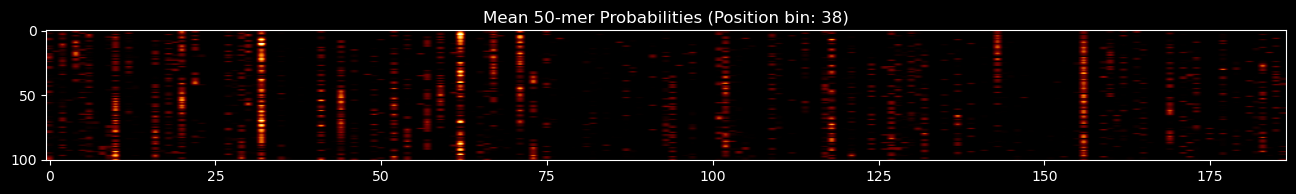

118 Yellow_fever_virus  |  71 Orf_virus


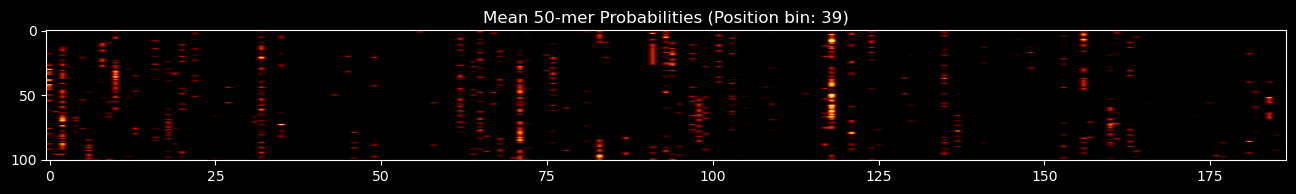

118 Yellow_fever_virus  |  4 Human_betaherpesvirus_6B


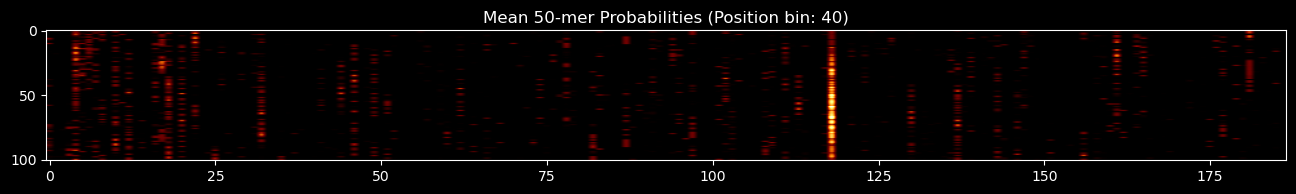

32 Human_gammaherpesvirus_8  |  102 Sindbis_virus


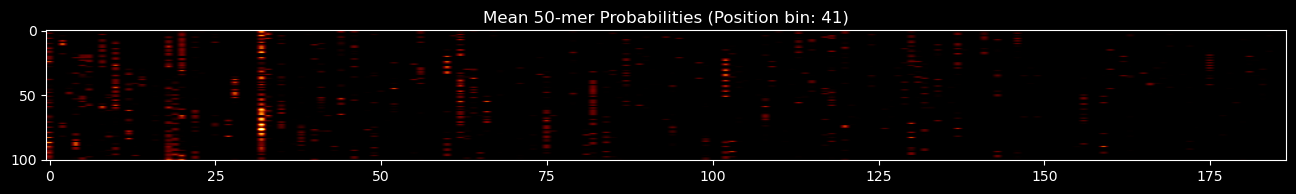

118 Yellow_fever_virus  |  32 Human_gammaherpesvirus_8


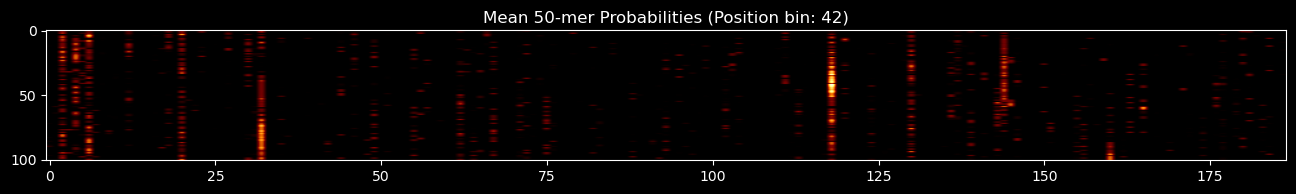

67 Louping_ill_virus  |  20 Cercopithecine_betaherpesvirus_5


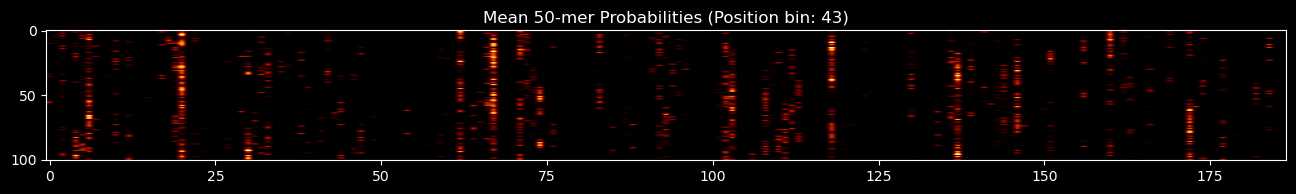

118 Yellow_fever_virus  |  143 Powassan_virus


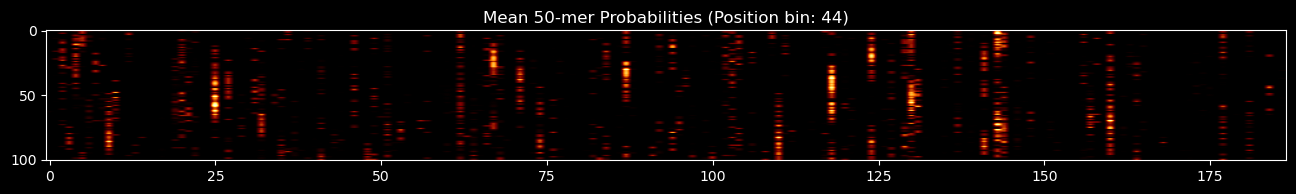

118 Yellow_fever_virus  |  62 Human_gammaherpesvirus_4


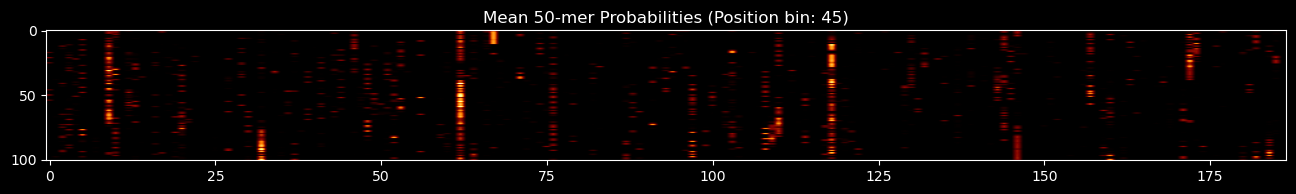

62 Human_gammaherpesvirus_4  |  44 Venezuelan_equine_encephalitis_virus


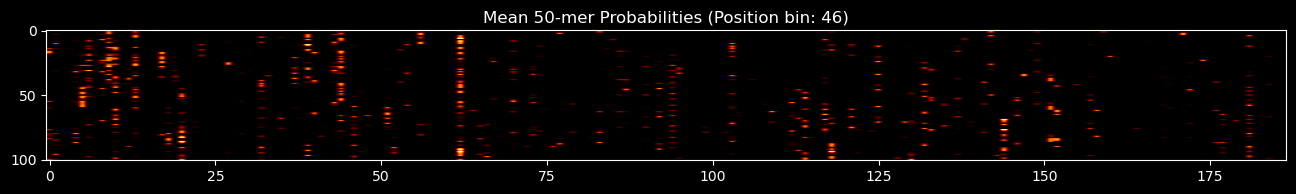

118 Yellow_fever_virus  |  160 Langat_virus


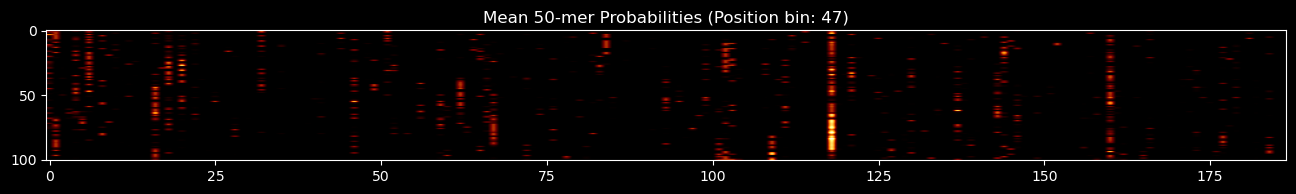

118 Yellow_fever_virus  |  62 Human_gammaherpesvirus_4


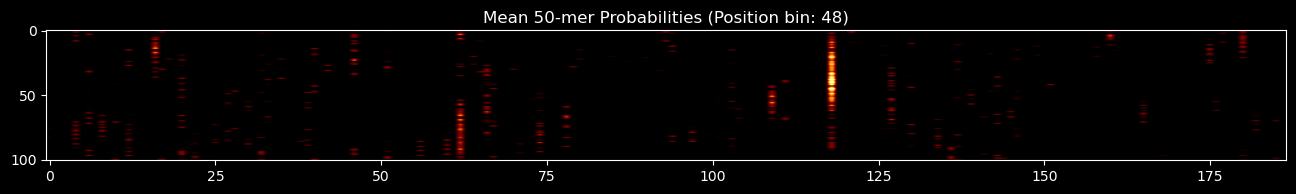

118 Yellow_fever_virus  |  32 Human_gammaherpesvirus_8


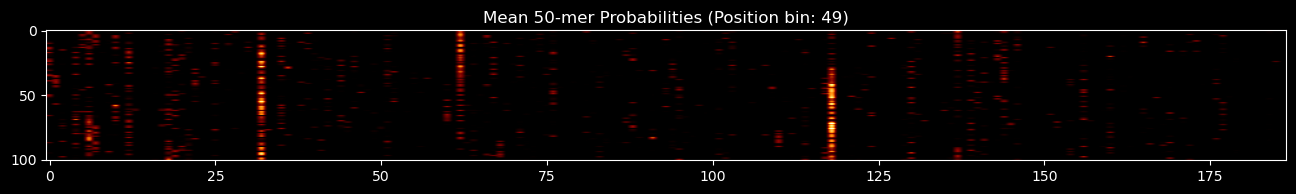

32 Human_gammaherpesvirus_8  |  62 Human_gammaherpesvirus_4


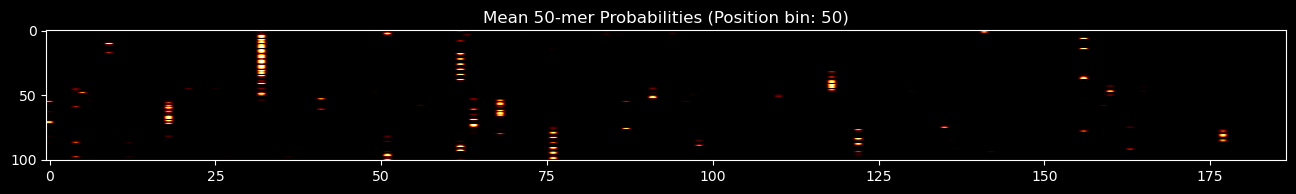

In [185]:
o = OriginalLabels()

for pos_bin in range(1, 51):
    probs = dfdfdf.loc[(pos_bin, slice(None)), :].values
    preds = np.argmax(probs, axis=1)
    preds_significant = probs.max(axis=1) >= 0.9
    labels, counts = np.unique(preds, return_counts=True)
    pred_1 =labels[np.argmax(counts)] 
    pred_2 =labels[np.argpartition(counts, -2)[-2]] 
    print(pred_1, o.label2species(pred_1),' | ', pred_2, o.label2species(pred_2))
    plot_label_mean_probs(np.expand_dims(probs, 0), pos_bin=pos_bin)

using `asyncio`

```python
# Python
import sqlite3
import asyncio
import aiosqlite

# Create an index on refseqid
conn = sqlite3.connect('your_database.db')
c = conn.cursor()
c.execute('CREATE INDEX IF NOT EXISTS idx_refseqid ON preds_probs(refseqid);')
conn.commit()

# Use asyncio for asynchronous database queries
async def get_data(refseqid, limit, offset):
    async with aiosqlite.connect('your_database.db') as db:
        async with db.cursor() as cursor:
            await cursor.execute(f"""
                SELECT refseqid, pos_true, read_kmer_id, read_50mer_nb, prob_001, prob_002
                FROM preds_probs 
                WHERE refseqid = '{refseqid}'
                LIMIT {limit} OFFSET {offset};
            """)
            rows = await cursor.fetchall()
            return rows

# Fetch and process data in batches
async def process_data_in_batches(refseqid, batch_size):
    offset = 0
    while True:
        batch = await get_data(refseqid, batch_size, offset)
        if not batch:
            break
        # Process batch here...
        offset += batch_size

# Run the async function
asyncio.run(process_data_in_batches('11089:ncbi:1', 500))
```

In [ ]:
def plot_label_probs(probs, top_preds, true_labels=[118]):
    nb_seq, _ , nb_lbls = probs.shape
    assert nb_lbls == 187
    fig = plt.figure(figsize=(16, 2 * nb_seq - 1));
    # fig.suptitle('Suptitle')
    axs = []
    for i in range(nb_seq):
        if top_preds[i, 0] in true_labels: cmap = 'YlGn_r'
        else: cmap = 'YlOrRd_r'
        axs.append(plt.subplot2grid((nb_seq,1), (i,0), rowspan=1, colspan=1))
        # axs[i].axis('off')
        axs[i].imshow(probs[i,:,:], cmap=cmap, aspect='auto')
        axs[i].set_title(f"Seq {i+1} - Pred: {top_preds[i,0]} - Top Predictions; {top_preds[i]}")

    fig.subplots_adjust(top=1.5, bottom=0.2, hspace=0.5)
    plt.show()

# Sandbox

## Experimenting how to query the database for probabilities

In [ ]:
%%time
# Retrieve three columns filtering on a list of id
# CPU times: user 86.4 ms, sys: 27.7 ms, total: 114 ms
# Wall time: 3.03 s
query = f"""
SELECT id, read_kmer_id, read_50mer_nb
FROM label_probabilities 
WHERE id IN ({','.join([str(x) for x in range(20_000)])})
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail(5))

(1000, 3)


id        read_kmer_id  read_50mer_nb
995   996  11089:ncbi:1-16517              1
996   997  11089:ncbi:1-16516              1
997   998  11089:ncbi:1-16515              1
998   999  11089:ncbi:1-16514              1
999  1000  11089:ncbi:1-16513              1

CPU times: user 64 ms, sys: 38.7 ms, total: 103 ms
Wall time: 3.27 s


In [ ]:
%%time
# Retrieve three columns filtering on a list of id
# CPU times: user 86.4 ms, sys: 27.7 ms, total: 114 ms
# Wall time: 3.03 s

query = f"""
SELECT id, read_kmer_id, read_50mer_nb
FROM label_probabilities 
WHERE id IN ({','.join([str(x) for x in range(20_000)])})
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail(5))

(1000, 3)


id        read_kmer_id  read_50mer_nb
995   996  11089:ncbi:1-16517              1
996   997  11089:ncbi:1-16516              1
997   998  11089:ncbi:1-16515              1
998   999  11089:ncbi:1-16514              1
999  1000  11089:ncbi:1-16513              1

CPU times: user 1.26 ms, sys: 41.1 ms, total: 42.3 ms
Wall time: 165 ms


In [ ]:
%%time
# Retrieve all colomns filtering on a list of id
# CPU times: user 146 ms, sys: 33.2 ms, total: 179 ms
# Wall time: 3.69 s
query = f"""
SELECT *
FROM label_probabilities 
WHERE id IN ({','.join([str(x) for x in range(20000)])})
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail(5))

(1000, 190)


id        read_kmer_id  read_50mer_nb       prob_000        prob_001  \
995   996  11089:ncbi:1-16517              1   8.754474e-05   1.7678653e-21   
996   997  11089:ncbi:1-16516              1  7.5915164e-13   4.9807175e-17   
997   998  11089:ncbi:1-16515              1  2.7855967e-06  1.00908907e-19   
998   999  11089:ncbi:1-16514              1  1.2838345e-12    1.223785e-15   
999  1000  11089:ncbi:1-16513              1  1.9092526e-05   4.6979976e-13   

         prob_002       prob_003      prob_004       prob_005       prob_006  \
995  3.634549e-05   0.0038874687  9.118338e-09   9.198738e-05     0.25078282   
996  5.303934e-15  3.7269323e-15  1.045666e-08  1.1862427e-15  2.4500586e-11   
997  1.289632e-13  1.2527812e-08  2.140582e-07  5.2963238e-11   3.072991e-08   
998  2.734925e-11   1.731637e-22       0.94311  2.3930939e-16  4.2285706e-12   
999  2.834131e-12  1.0610391e-06   0.117659755  1.1744167e-11  1.1163678e-14   

     ...       prob_177       prob_178       prob_179       prob_180  \
995  ...   0.0004519505  2.1182933e-09   4.094599e-12  2.3100396e-18   
996  ...  2.5184195e-14   2.095439e-18   9.399496e-17   3.814011e-19   
997  ...   4.875204e-10  1.1337102e-11   1.684754e-11  5.9170376e-18   
998  ...  2.3002339e-10    9.64501e-21  1.0266413e-16   3.043349e-24   
999  ...   8.021518e-15    7.36918e-18   6.466401e-16  3.1235835e-17   

          prob_181       prob_182       prob_183       prob_184  \
995  1.3200581e-17  8.3177587e-10   9.040084e-16  1.1082036e-19   
996   6.360825e-15  1.5203839e-13  5.7828874e-19   1.778119e-17   
997   3.030622e-19    4.96021e-18  1.8964816e-16  3.3222575e-20   
998   4.858454e-17   9.689134e-17  5.8541106e-18  6.4746914e-27   
999  4.1697658e-18   9.649253e-16  3.6909373e-08  2.5215108e-13   

          prob_185      prob_186  
995   9.195436e-15  1.281601e-05  
996  3.0860775e-19  2.622951e-18  
997  1.0954248e-15  3.198112e-16  
998  2.3560985e-25  1.425361e-24  
999  8.0728805e-21  3.898578e-15  

[5 rows x 190 columns]

CPU times: user 167 ms, sys: 29.1 ms, total: 196 ms
Wall time: 341 ms


In [ ]:
%%time
# Retrieve 4 columns filtering on a specific read_kmer_id
# CPU times: user 25.1 ms, sys: 15.3 ms, total: 40.4 ms
# Wall time: 1.61 s

# id, read_kmer_id, read_50mer_nb, prob_001
query = f"""
SELECT id, read_kmer_id, read_50mer_nb, prob_001
FROM label_probabilities 
WHERE read_kmer_id = '11089:ncbi:1-1'
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail())

(101, 4)


id    read_kmer_id  read_50mer_nb        prob_001
96   1755752  11089:ncbi:1-1             96    9.605288e-18
97   1756264  11089:ncbi:1-1             97  1.05488615e-20
98   1756776  11089:ncbi:1-1             98   1.7379728e-17
99   1757288  11089:ncbi:1-1             99    8.715563e-21
100  1757800  11089:ncbi:1-1            100    7.744164e-18

CPU times: user 29.5 ms, sys: 12.4 ms, total: 41.8 ms
Wall time: 1.69 s


In [ ]:
%%time
# Retrieve 4 columns filtering on a list of read_kmer_id
# CPU times: user 54.8 ms, sys: 10.1 ms, total: 64.9 ms
# Wall time: 1.82 s

# id, read_kmer_id, read_50mer_nb, prob_001
query = f"""
SELECT id, read_kmer_id, read_50mer_nb, prob_001
FROM label_probabilities 
WHERE read_kmer_id IN ('11089:ncbi:1-1', '11089:ncbi:1-2', '11089:ncbi:1-3', '11089:ncbi:1-4')
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail())

(404, 4)


id    read_kmer_id  read_50mer_nb       prob_001
399  1755749  11089:ncbi:1-4             96   4.901561e-16
400  1756261  11089:ncbi:1-4             97    6.86821e-16
401  1756773  11089:ncbi:1-4             98  2.2368514e-14
402  1757285  11089:ncbi:1-4             99  3.8160105e-15
403  1757797  11089:ncbi:1-4            100   7.088436e-17

CPU times: user 32.1 ms, sys: 15.1 ms, total: 47.3 ms
Wall time: 4.27 s


List all indexes in the database

In [ ]:
db.list_indexes()

List of indexes in database 'single_69seq_150bp.db' and indexed columns:
- idx_preds for table 'predictions':
    - readid
    - refseqid
    - pos_true
- idx_probs for table 'label_probabilities':
    - read_kmer_id
    - read_50mer_nb


Creating a view to combine `predictions` and `label_probabilities`

In [ ]:
def create_view_preds_probs(self):
    
    # Create view joining predictions and label_probabilities
    view_name = 'preds_probs'

    # top prediction columns from table predictions:
    top_lbl_pred_n = ','.join([f"p.top_5_lbl_pred_{i}" for i in range(5)])
    print(top_lbl_pred_n)

    # probabilities columns from table label_probabilities 
    probs_n = ','.join([f"lp.prob_{i:03d}" for i in range(187)])

    query = f"""
    CREATE VIEW IF NOT EXISTS {view_name} AS
    SELECT 
        lp.id,
        p.refseqid,
        p.lbl_true, p.lbl_pred,
        p.pos_true, p.pos_pred,
        {top_lbl_pred_n},
        lp.read_kmer_id, lp.read_50mer_nb,
        {probs_n}
    FROM 
        label_probabilities lp
    INNER JOIN 
        predictions p
    ON 
        lp.read_kmer_id = p.readid
    """
    print(query)
    self.execute(query)

def drop_view_preds_probs(self):
    
    self.execute('DROP VIEW IF EXISTS preds_probs')
    
# drop_view_preds_probs(db)
# create_view_preds_probs(db)
# db.print_schema()


- 1 refseqid -> 17,000 read_kmer_id
- 1 read_kmer_id -> 101 read_50mer_nb
- 1 refseqid -> 1,717,000 read_50mer_nb

If we read in pages of 200 read_kmer_id:
- 1 refseqid -> 85 pages of 200 read_kmer_id
- 1 page of 200 read_kmer_id -> 20,200 read_50mer_nb
- each page will take about 20,200 * 3.5 ms = 70 sec

If we read in pages of 250 read_kmer_id:
- 1 refseqid -> 68 pages of 250 read_kmer_id
- 1 page of 250 read_kmer_id -> 25,250 read_50mer_nb
- each page will take about 25,250 * 3.5 ms = 88 sec

|# read_50mer_nb|wall time|wall time per row|
|---:|:---:|:---:|
|1,000|6 sec|6 ms|
|10,000|35 sec|3.5 ms|
|25,250|1 min 23 sec| 3.3 ms|
|50,000|2 min 57 sec| 3.5 ms|
|100,000|6 min 11 sec | 3.6 ms|

Seems that the page size of 25,250 is a good comprimise between speed and number of queries.


## Distance Matrix

In [56]:
p2matrix = pfs.data / 'ncbi/other/yf/YF_2023_envelop_percentage_distance_matrix.csv'
dist_mx = pd.read_csv(p2matrix, index_col=0)
for col in dist_mx.columns:
    dist_mx[col] = dist_mx[col].str.rstrip('%').astype(float)/100
dist_mx

YFV_Cameroon_2023  YFV_CAR_2019  \
                                                                   
YFV_Cameroon_2023                             0.00          0.04   
YFV_CAR_2019                                  0.04          0.00   
U21056_senegal_1927                           0.19          0.19   
JX898870_senegal_1996                         0.19          0.18   
U23574_Senegal_1965                           0.19          0.18   
...                                            ...           ...   
MK760660_Netherlands_2018                     0.19          0.19   
MK333805_Brazil_IlhaGrande_2018               0.19          0.19   
MW308135_Brazil_2019                          0.19          0.19   
MZ604867_Brazil_2019                          0.19          0.19   
MZ712143_Brazil_2021                          0.19          0.19   

                                 U21056_senegal_1927  JX898870_senegal_1996  \
                                                                              
YFV_Cameroon_2023                               0.19                   0.19   
YFV_CAR_2019                                    0.19                   0.18   
U21056_senegal_1927                             0.00                   0.04   
JX898870_senegal_1996                           0.04                   0.00   
U23574_Senegal_1965                             0.04                   0.03   
...                                              ...                    ...   
MK760660_Netherlands_2018                       0.15                   0.15   
MK333805_Brazil_IlhaGrande_2018                 0.15                   0.15   
MW308135_Brazil_2019                            0.15                   0.15   
MZ604867_Brazil_2019                            0.15                   0.15   
MZ712143_Brazil_2021                            0.15                   0.15   

                                 U23574_Senegal_1965  JX898868_Senegal_1995  \
                                                                              
YFV_Cameroon_2023                               0.19                   0.19   
YFV_CAR_2019                                    0.18                   0.18   
U21056_senegal_1927                             0.04                   0.04   
JX898870_senegal_1996                           0.03                   0.00   
U23574_Senegal_1965                             0.00                   0.03   
...                                              ...                    ...   
MK760660_Netherlands_2018                       0.15                   0.15   
MK333805_Brazil_IlhaGrande_2018                 0.15                   0.15   
MW308135_Brazil_2019                            0.15                   0.15   
MZ604867_Brazil_2019                            0.15                   0.15   
MZ712143_Brazil_2021                            0.15                   0.15   

                                 JX898873_ArD149214_Senegal_2000  \
                                                                   
YFV_Cameroon_2023                                           0.19   
YFV_CAR_2019                                                0.18   
U21056_senegal_1927                                         0.05   
JX898870_senegal_1996                                       0.03   
U23574_Senegal_1965                                         0.04   
...                                                          ...   
MK760660_Netherlands_2018                                   0.15   
MK333805_Brazil_IlhaGrande_2018                             0.15   
MW308135_Brazil_2019                                        0.15   
MZ604867_Brazil_2019                                        0.16   
MZ712143_Brazil_2021                                        0.15   

                                 JX898874_ArD149194_Senegal_2000  \
                                                                   
YFV_Cameroon_2023                                           0.19   
YFV

In [57]:
distance_accessions = {}
missing=[]
for col in dist_mx.columns:
    regex = re.compile(r'^(?P<accession>\w{1,2}\d*)_(?P<country>.*)_(?P<year>\d\d\d\d)$')
    match = regex.search(col)
    if match: 
        accession = match.group('accession')
        subdict = {
            'accession': accession, 
            'country': match.group('country'), 
            'year': match.group('year'),
            'definition line': col
            } 
        distance_accessions[accession] = subdict
    else:
        missing =+ 1
        print(col, 'could not find the accession')

YFV_Cameroon_2023 could not find the accession
YFV_CAR_2019 could not find the accession
Yellow_fever_YF118_CAR_2018 could not find the accession


In [58]:
included, not_included = [], []
for refseqid,v in refseq_metadata.items():
    dist_dict = distance_accessions.get(v['refseq_accession'], None)
    if dist_dict:
        included.append(v['refseq_accession'])
    else:
        not_included.append(refseqid)

print(f"{len(included)} out of 69 accessions in distance matrix, {len(not_included)} not:")
print('\n'.join([f"  - {refseq_metadata[rsid]['refseq_accession']} {refseq_metadata[rsid]['organism']}" for rsid in not_included]))

46 out of 69 accessions in distance matrix, 23 not:
  - DQ235229 Ethiopia_1961
  - MF405338 Ghana_Hsapiens_1927
  - JX898871 ArD114896_Senegal_1995
  - JX898872 Senegal_Aedes-aegypti_1995
  - DQ118157 Spain_Vaccine_2004
  - JX898879 ArD181676_Senegal_2005
  - JX898881 Senegal_Aedes_luteocephalus_2005
  - JX898880 ArD181564_Senegal_2005
  - MK457701 Nigeria_Hsapiens_2018
  - JF912183 Brazil_Hsapiens_1984
  - KM388817 Venezuela_Guarico_Allouetta_seniculus_2004
  - KM388816 Venezuela_Monagas_Asiniculus_2010
  - MK583166 Brazil_SaoPaulo_Hsapiens_2018
  - MK760665 Netherlands_Hsapiens-from-brazil_2018
  - MF370535 Brazil_Allouatta_sp_2016
  - MF370533 Brazil_Hsapiens_2017
  - MF370530 Brazil_Haemagogus-janthinomys_2017
  - MW960207 Yellow_fever_YF118_CAR_2018
  - KY495641 China_Hsapiens_2016
  - KX268355 China_Hsapiens_2016
  - KY587416 China_Hsapiens_2016
  - MF004383 432429_S4_MF004383
  - MW960207 yp


In [76]:
for selected in selected_refseqs:
    accession = refseq_metadata[selected]['refseq_accession']
    print(f"{selected:14s}    {refseq_metadata[selected]['organism']:25s}    {refseq_metadata[selected]['refseq_accession']:20s}   {distance_accessions[accession]['definition line']:30s}")

11089:ncbi:10     Peru_Hsapiens_2007           GQ379163               GQ379163_Peru_2007            
11089:ncbi:13     Sudan_Hsapiens_1941          KU978764               KU978764_Sudan_1941           
11089:ncbi:30     Nigeria_Hsapiens_1946        KU978763               KU978763_Nigeria_1946         
11089:ncbi:37     Brazil_Hsapiens_2002         JF912190               JF912190_Brazil_2002          
11089:ncbi:32     Brazil_Hsapiens_1983         JF912181               JF912181_Brazil_1983          
11089:ncbi:35     Brazil_Hsapiens_1984         JF912182               JF912182_Brazil_1984          
11089:ncbi:1      Angola_1971                  AY968064               AY968064_angola_1971          


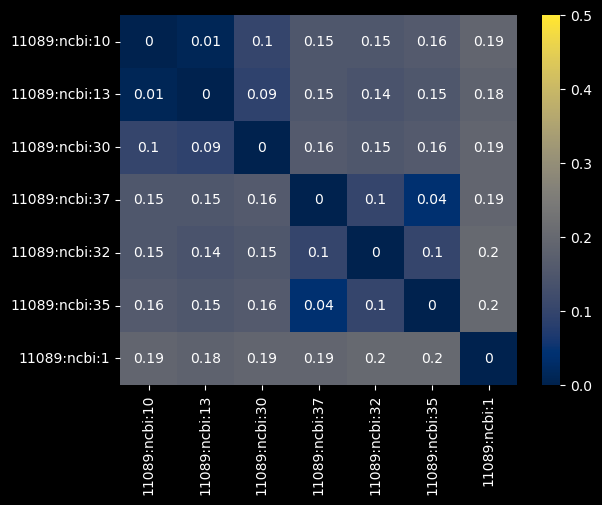

In [89]:
refseqid2dist_mx_idx = {}
dist_mx_idx2refseqid = {}

for refseqid in selected_refseqs:
    accession = refseq_metadata[refseqid]['refseq_accession']
    idx = distance_accessions[accession]['definition line']
    refseqid2dist_mx_idx[refseqid] = idx
    dist_mx_idx2refseqid[idx] = refseqid

selected_dist_idxs = [refseqid2dist_mx_idx[rsid] for rsid in selected_refseqs]
selected_dist = dist_mx.loc[selected_dist_idxs, selected_dist_idxs]
selected_dist.index=selected_refseqs
selected_dist.columns=selected_refseqs
sns.heatmap(selected_dist, cmap='cividis', annot=True, vmin=0, vmax=0.5);

Accuracy vs Distance

In [113]:
%%time
df_reads = db.get_dataframe('SELECT id, refseqid, lbl_true, lbl_pred, pos_true FROM predictions')
df_reads.shape

CPU times: user 112 ms, sys: 27.2 ms, total: 139 ms
Wall time: 4.45 s


(53248, 5)

In [114]:
df_reads['accuracy'] = df_reads.lbl_pred == df_reads.lbl_true

In [115]:
bins = [0 + n * 10237/n_position_bins for n in range(n_position_bins+1)]
df_reads['pos_bin'] = pd.cut(df_reads['pos_true'], bins, retbins=False)
df_reads['pos_bin'].cat.categories = range(1, n_position_bins+1) # rename categories from 1 to n_position_bins

In [116]:
df_reads.head()

id      refseqid  lbl_true  lbl_pred  pos_true  accuracy pos_bin
0   1  11089:ncbi:1       118        10      7804     False      39
1   2  11089:ncbi:1       118         2      6069     False      30
2   3  11089:ncbi:1       118       144      5317     False      26
3   4  11089:ncbi:1       118        32      1717     False       9
4   5  11089:ncbi:1       118       118      9658      True      48

In [144]:
r_group = df_reads.groupby('refseqid')
r_acc_sum = r_group['accuracy'].sum()
r_counts = r_group['accuracy'].count().replace(0,1)
r_acc_mean = r_acc_sum.div(r_counts)
# display(r_acc_mean)

bin_group = df_reads.groupby(['refseqid','pos_bin'])
bin_acc_mean = bin_group.mean().loc[(slice(None),slice(None)), ['accuracy']]
# bin_acc_mean

In [159]:
set(selected_dist.index).difference(set(selected_refseqs))

set()

In [169]:
common_refseqid = list(set(df_reads.refseqid.unique()).intersection(set(selected_refseqs)))

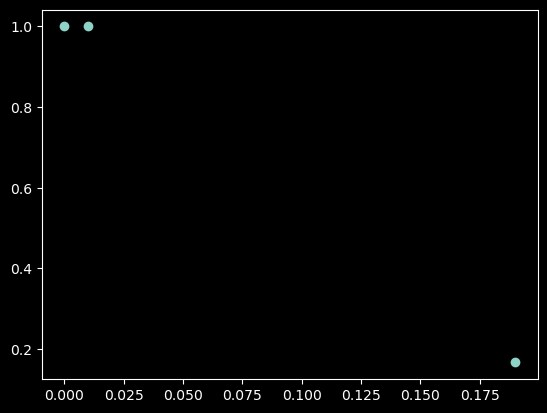

In [172]:
plt.scatter(x=selected_dist.loc[common_refseqid[2], common_refseqid], y=r_acc_mean.loc[common_refseqid]);

## Successive predictions

#### Successive identical predictions (integer)

To evaluate and compare multiple lists of integers based on the criteria you've described, you can use a custom scoring function that takes into account both the number of elements equal to the given value y and the length of sequences of identical elements. Here's a suggested approach using a mathematical function as a metric:

Proposed Scoring Function

Let's define a scoring function S(L, y) for a list L and target value y:
```
S(L, y) = (C / N) * (1 + (M / N) * (1 - F / C))
```
Where:
- N is the total number of elements in the list
- C is the count of elements equal to y
- M is the maximum length of any continuous sequence of y in the list
- F is the number of "fragments" or separate sequences of y in the list

Explanation of the Function Components

1. (C / N): This represents the proportion of elements in the list that are equal to y. It ranges from 0 to 1.

2. (1 + (M / N) * (1 - F / C)): This factor rewards longer sequences and penalizes fragmentation.
   - (M / N) rewards longer continuous sequences of y
   - (1 - F / C) penalizes fragmentation; it's 1 when there's only one sequence (F = 1) and decreases as the number of fragments increases

Properties of the Scoring Function

1. The score will be highest (1.0) when all elements are equal to y (C = N, M = N, F = 1).
2. For the same number of matching elements (C), lists with longer continuous sequences will score higher.
3. For the same number of matching elements (C) and maximum sequence length (M), lists with fewer fragments will score higher.

Example Calculations

Let's say y = 1 and we have the following lists:

1. [1, 1, 1, 1, 1] (N=5, C=5, M=5, F=1)
   S = (5/5) * (1 + (5/5) * (1 - 1/5)) = 1 * (1 + 1 * 0.8) = 1.8

2. [1, 1, 1, 0, 1] (N=5, C=4, M=3, F=2)
   S = (4/5) * (1 + (3/5) * (1 - 2/4)) = 0.8 * (1 + 0.6 * 0.5) = 1.04

3. [1, 0, 1, 0, 1] (N=5, C=3, M=1, F=3)
   S = (3/5) * (1 + (1/5) * (1 - 3/3)) = 0.6 * 1 = 0.6

This scoring function provides a single metric that you can use to evaluate and compare multiple lists based on your specified criteria. The higher the score, the better the list matches your requirements.

[ref](https://www.perplexity.ai/search/successive-integers-scoring-pxKaeZFQQWGuvgiXuXPAGw)

### Successive close probabilities (float)

To evaluate your lists of probabilities based on the criteria you've described, you can use a custom scoring function that takes into account both the individual values and their sequence. Here's a suggested approach:

## Proposed Scoring Function

You can use a combination of techniques to create a scoring function that meets your requirements:

1. Average proximity to 1
2. Longest sequence bonus
3. Weighted scoring

Here's a Python function that implements this approach:

```python
import numpy as np

def score_probability_list(prob_list, sequence_threshold=0.9, sequence_weight=0.3):
    # Convert to numpy array for easier operations
    probs = np.array(prob_list)
    
    # 1. Calculate average proximity to 1
    base_score = np.mean(probs)
    
    # 2. Find the longest sequence of numbers above the threshold
    sequence_length = 0
    max_sequence = 0
    for prob in probs:
        if prob >= sequence_threshold:
            sequence_length += 1
            max_sequence = max(max_sequence, sequence_length)
        else:
            sequence_length = 0
    
    # Normalize the sequence bonus
    sequence_bonus = max_sequence / len(probs)
    
    # 3. Combine the scores with weighting
    final_score = (1 - sequence_weight) * base_score + sequence_weight * sequence_bonus
    
    return final_score
```

## How It Works

1. **Average proximity to 1**: This is simply the mean of all probabilities in the list. It ensures that lists with many elements close to 1 get a good score.

2. **Longest sequence bonus**: This part finds the longest continuous sequence of probabilities above a certain threshold (default 0.9). It's then normalized by dividing by the list length.

3. **Weighted scoring**: The final score is a weighted combination of the average proximity and the sequence bonus. You can adjust the `sequence_weight` to give more or less importance to the sequence aspect.

## Usage and Customization

You can call this function like this:

```python
list1 = [0.9, 0.95, 0.98, 0.99, 0.7, 0.8]
list2 = [0.7, 0.8, 0.9, 0.95, 0.98, 0.99]

score1 = score_probability_list(list1)
score2 = score_probability_list(list2)

print(f"Score for list1: {score1}")
print(f"Score for list2: {score2}")
```

You can customize the function by adjusting:

- `sequence_threshold`: The minimum value to consider as part of a "good" sequence.
- `sequence_weight`: How much importance to give to the sequence bonus vs. the average proximity.

## Advantages

This scoring function:
- Rewards lists with many elements close to 1
- Gives a bonus for longer sequences of high probabilities
- Is flexible and can be easily adjusted to emphasize different aspects

Remember to test this function with various input lists to ensure it behaves as expected for your specific use case.

# End of Section